In [1]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import category_encoders as ce
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from yellowbrick.classifier.threshold import discrimination_threshold
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve



import nltk
from nltk.corpus import stopwords

from tqdm import tqdm

import warnings
from collections import Counter
from typing import Iterable
from itertools import product
from pathlib import Path
from dataclasses import dataclass

pd.options.display.max_columns = None
sns.set_theme()

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/berkayg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
@dataclass
class FilePaths:
    database_path: Path = Path(".")

In [3]:
def read_csv_file(file_name):
    file_path = FilePaths.database_path.joinpath(file_name)
    return pd.read_csv(file_path)

In [4]:
df_train = read_csv_file("df_target_train.csv")
print(df_train.shape)
df_train.head()

(27086, 2)


userid currentbugroupname
0  28704634                 GM
1  13506108                 Ev
2   5893128                NaN
3  15209082            Mobilya
4   1109976           Kozmetik

In [5]:
# I just want to take a moment to check if users with a null currentbugroupname might actually have non-null values in the dataset.
na_users = df_train.loc[df_train["currentbugroupname"].isna()].userid
df_train.dropna().loc[df_train.dropna().userid.isin(na_users)]

# No. Therefore I can conclude that the null values are not referring to a hidden or missing currentbugroupname
# Rather it refers that the corresponding user has not done any purchases. (Just wanted to make sure I got the dataset right.)

Empty DataFrame
Columns: [userid, currentbugroupname]
Index: []

In [6]:
df_train.currentbugroupname.fillna("No Purchase").value_counts(normalize=True)

currentbugroupname
Branded Tekstil             0.192646
FMCG                        0.155246
GM                          0.123680
Ev                          0.098723
No Purchase                 0.086835
Private Label               0.073396
Ayakkabı & Çanta            0.068781
Elektronik                  0.065938
Kozmetik                    0.050100
GAS                         0.033080
Aksesuar & Saat & Gözlük    0.028539
Mobilya                     0.020859
Digital Goods               0.002178
Name: proportion, dtype: float64

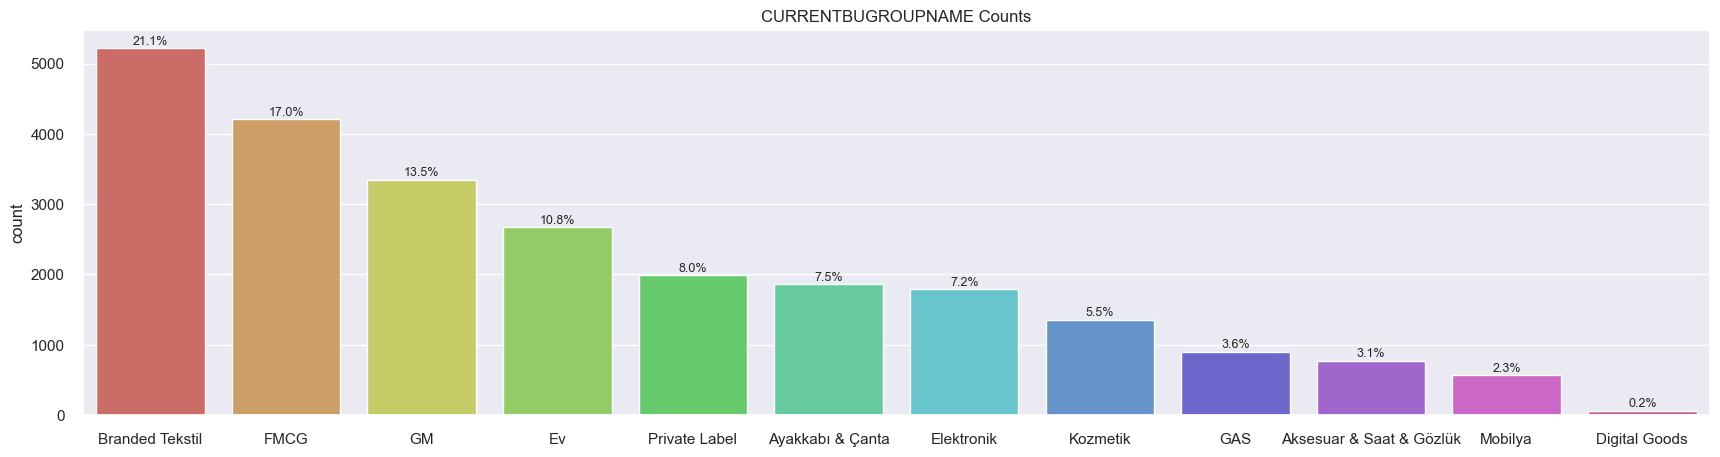

In [7]:
plt.figure(figsize=(21, 5))
ax = sns.countplot(x=df_train.currentbugroupname, order=df_train.currentbugroupname.value_counts().index, palette=sns.color_palette("hls", 12))
total = df_train.dropna(subset=["currentbugroupname"]).shape[0]
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=9)
plt.title("CURRENTBUGROUPNAME Counts")
plt.xlabel(None)
plt.show()

In [8]:
print(f"Unique User Percentage: %{round(df_train.userid.nunique() / df_train.shape[0], 3) * 100}")

Unique User Percentage: %75.3


In [9]:
print("df_train null values:")
(df_train.isnull().sum() / df_train.shape[0]).round(3).sort_values(ascending=False)

df_train null values:


currentbugroupname    0.087
userid                0.000
dtype: float64

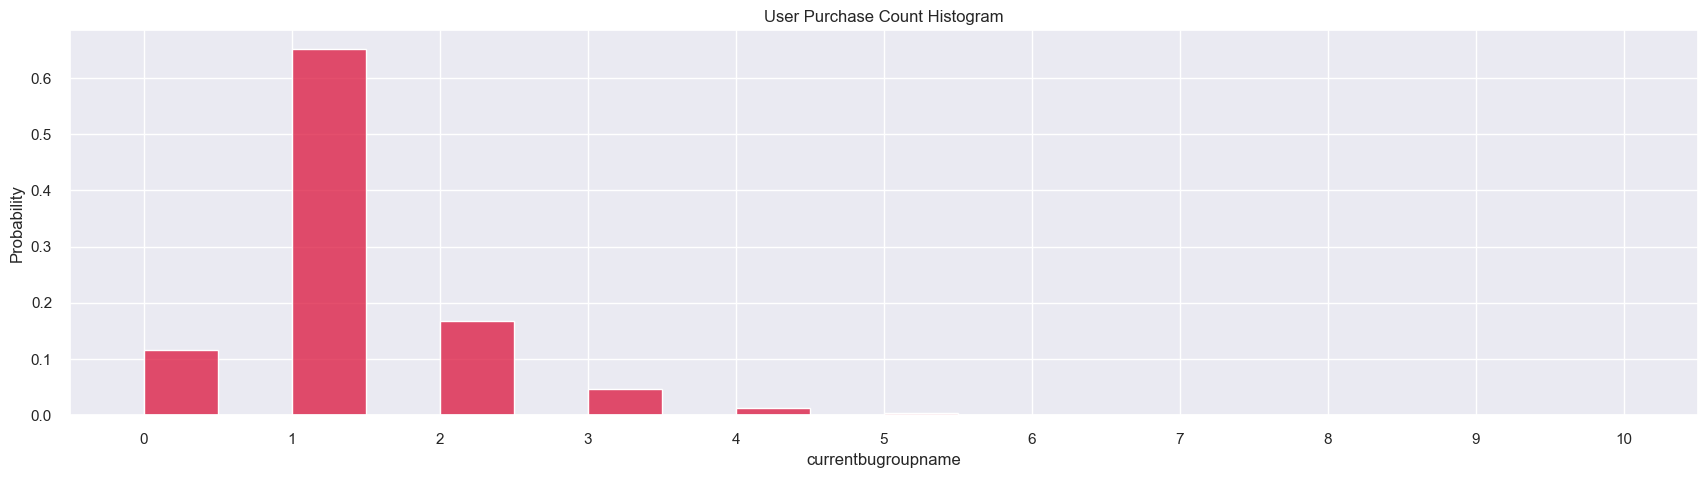

In [10]:
# Number of unique BU group purchase counts
df_purchase_agg = df_train.groupby("userid").count().sort_values("currentbugroupname", ascending=False)
plt.figure(figsize=(21, 5))
sns.histplot(data=df_purchase_agg, x="currentbugroupname", bins=20, cumulative=False, color="crimson", stat="probability")
plt.title("User Purchase Count Histogram")
plt.xticks(np.arange(0, 11, 1));

In [11]:
df_test = read_csv_file("df_test.csv")
df_test.drop(columns=["probability"], inplace=True)
df_test.head()

userid currentbugroupname  target
0  20152944      Private Label     NaN
1   6662068      Private Label     NaN
2  11941706      Private Label     NaN
3  12406170      Private Label     NaN
4  20939786      Private Label     NaN

In [12]:
train_unique_userids = df_train.userid.unique()
test_unique_userids = df_test.userid.unique()

In [13]:
np.intersect1d(train_unique_userids.shape, test_unique_userids)

array([], dtype=int64)

In [14]:
# Here I can create a long formatted dataframe that contains one-to-one user - currentbugroupname pairs
# The pairs that are not in df_train will be provided "0" in the target column meaning not purchased otherwise labeled as "1"
def melt_user_bu_pairs(data):
    df_train_matrix = data.pivot(index="userid", columns=["currentbugroupname"], values=["currentbugroupname"]).droplevel(axis=1, level=0)
    df_train_melt = df_train_matrix.reset_index().melt(id_vars=["userid"], value_name="target")
    df_train_melt["target"] = np.where(df_train_melt["target"].isna(), 0, 1)
    del df_train_matrix
    df_train_melt.dropna(subset=["currentbugroupname"], inplace=True)
    return df_train_melt

In [15]:
df_train_melt_ = melt_user_bu_pairs(df_train)
df_train_melt_.query("userid == 2086")

userid        currentbugroupname  target
20402     2086  Aksesuar & Saat & Gözlük       0
40804     2086          Ayakkabı & Çanta       1
61206     2086           Branded Tekstil       0
81608     2086             Digital Goods       0
102010    2086                Elektronik       0
122412    2086                        Ev       0
142814    2086                      FMCG       0
163216    2086                       GAS       0
183618    2086                        GM       0
204020    2086                  Kozmetik       0
224422    2086                   Mobilya       0
244824    2086             Private Label       1

In [16]:
df_test["target"] = "test_set"
df_train_melt = pd.concat([df_train_melt_, df_test])
df_train_melt.query("userid == 20152944 or userid == 12810")

userid        currentbugroupname    target
20403      12810  Aksesuar & Saat & Gözlük         0
40805      12810          Ayakkabı & Çanta         1
61207      12810           Branded Tekstil         0
81609      12810             Digital Goods         0
102011     12810                Elektronik         0
122413     12810                        Ev         0
142815     12810                      FMCG         0
163217     12810                       GAS         0
183619     12810                        GM         0
204021     12810                  Kozmetik         0
224423     12810                   Mobilya         0
244825     12810             Private Label         1
0       20152944             Private Label  test_set
20403   20152944                  Kozmetik  test_set
40806   20152944                        Ev  test_set
61209   20152944           Branded Tekstil  test_set
81612   20152944          Ayakkabı & Çanta  test_set
102015  20152944                Elektronik  test_set
122418  20152944                        GM  test_set
142821  20152944                      FMCG  test_set
163224  20152944                   Mobilya  test_set
183627  20152944                       GAS  test_set
204030  20152944  Aksesuar & Saat & Gözlük  test_set
224433  20152944             Digital Goods  test_set

In [17]:
df_train_melt.target.value_counts(normalize=True)

target
test_set    0.500012
0           0.449475
1           0.050513
Name: proportion, dtype: float64

In [18]:
df_demo = read_csv_file("df_demo.csv")
df_demo.head()

userid gender   age  tenure
0   9798852  Bayan  41.0      89
1  11413556  Bayan  33.0      61
2    818188  Bayan  32.0     125
3  12049002  Bayan  30.0      54
4  10083038  Bayan  39.0      84

In [19]:
df_demo["userid"].nunique() / df_demo.shape[0]

1.0

In [20]:
df_demo.isna().sum()

userid        0
gender        0
age       15603
tenure        0
dtype: int64

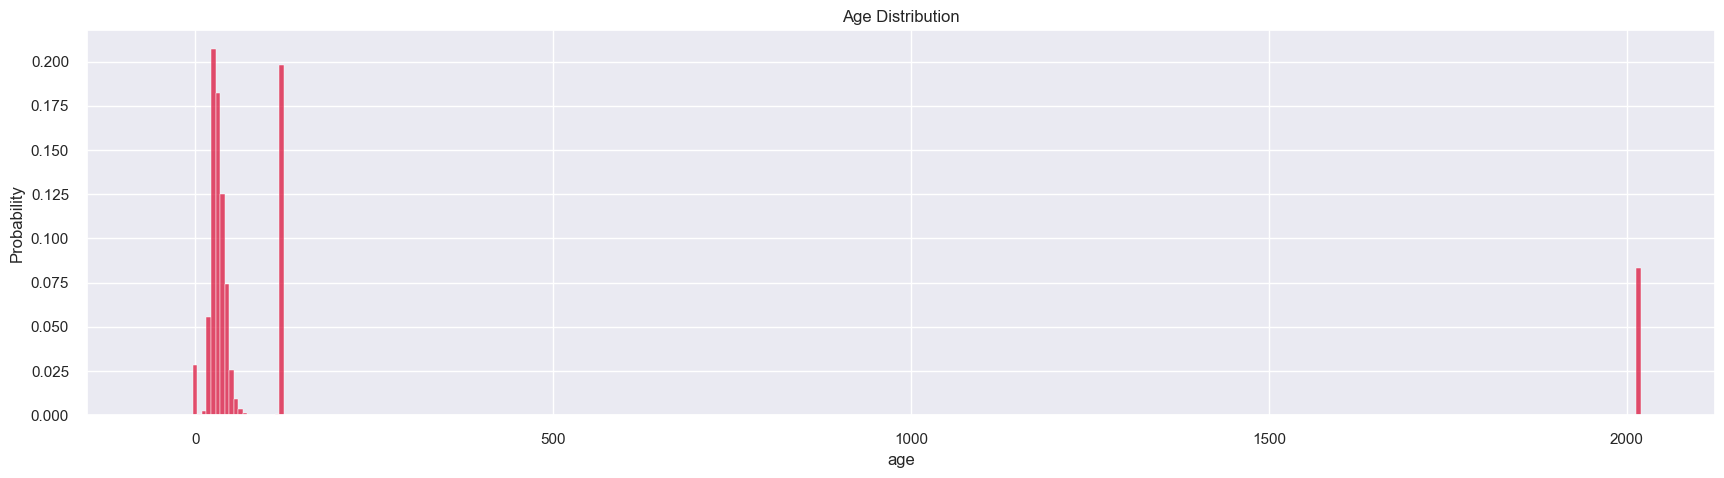

In [21]:
plt.figure(figsize=(21, 5))
sns.histplot(data=df_demo, x="age", color="crimson", stat="probability");
plt.title("Age Distribution");
# There seems to be discrepancies in the data in terms of age.

In [22]:
# Counter-intuitive values will be replaced with NaN values
df_demo["age"] = np.where((df_demo["age"] >= 90) | (df_demo["age"] <= 10), np.nan, df_demo["age"])

In [23]:
print(df_demo["age"].mean())

32.227661048256756


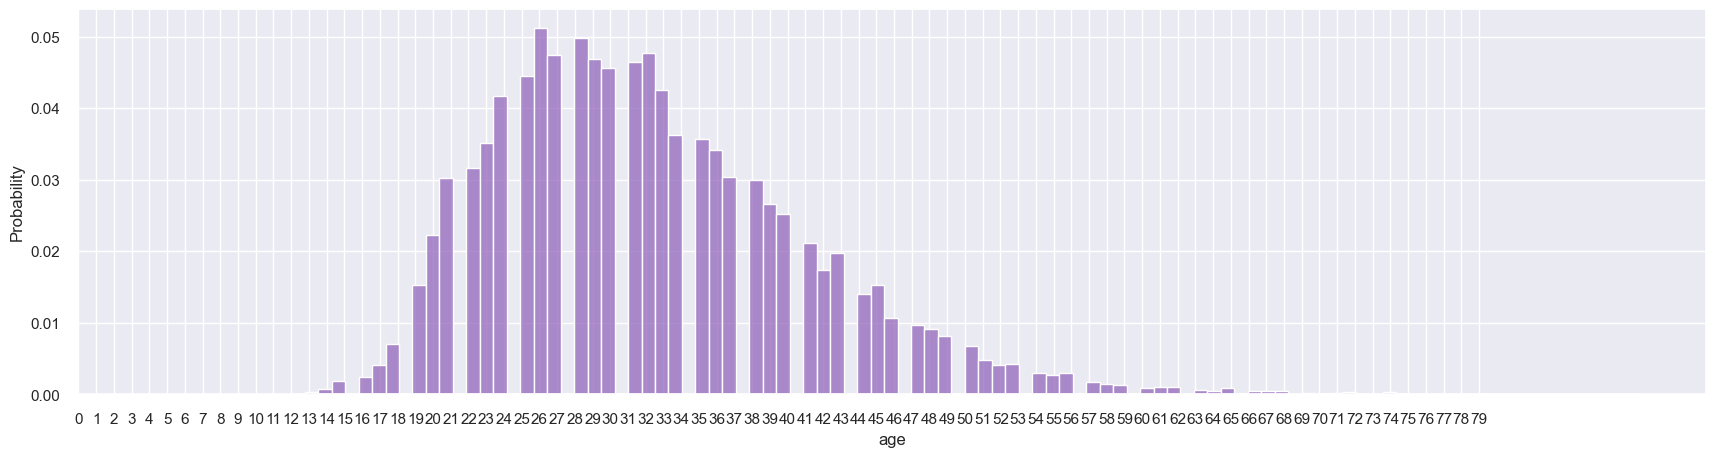

In [24]:
# New display of the Age Distribution when the values replaced
plt.figure(figsize=(21, 5))
sns.histplot(data=df_demo[["age"]], bins=100, x="age", color="tab:purple", stat="probability");
plt.xticks(np.arange(0, 80, 1));
plt.show();

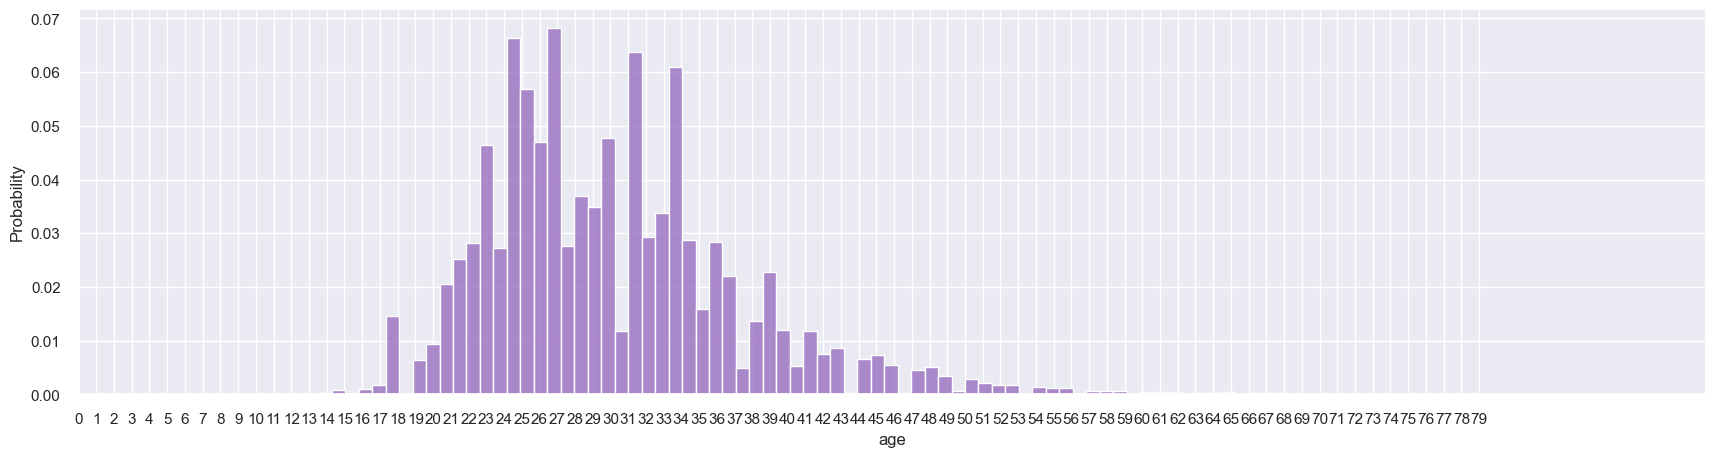

In [25]:
imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(df_demo.set_index("userid").replace({"UNKNOWN": np.nan, "kvkktalepsilindi": np.nan}).replace({"Bayan": 1, "Bay": 0}))
df_demo = pd.DataFrame(imputed, columns=df_demo.set_index("userid").columns, index=df_demo["userid"])
df_demo.reset_index(drop=True)

plt.figure(figsize=(21, 5))
sns.histplot(data=df_demo[["age"]], bins=100, x="age", color="tab:purple", stat="probability");
plt.xticks(np.arange(0, 80, 1));
plt.show();


In [26]:
df_train_merge = df_train_melt.merge(df_demo, how="left", on="userid")
df_train_merge.head()

userid        currentbugroupname target  gender   age  tenure
0    2086  Aksesuar & Saat & Gözlük      0     1.0  44.0   129.0
1   12810  Aksesuar & Saat & Gözlük      0     1.0  37.0   128.0
2   14302  Aksesuar & Saat & Gözlük      0     0.0  34.0   127.0
3   15148  Aksesuar & Saat & Gözlük      0     1.0  39.0   127.0
4   32508  Aksesuar & Saat & Gözlük      0     1.0  35.0   127.0

In [27]:
df_train_merge.isna().sum() / df_train_merge.shape[0]

userid                0.0
currentbugroupname    0.0
target                0.0
gender                0.0
age                   0.0
tenure                0.0
dtype: float64

### Search Term
Search terms table carries a great deal of potential to encrich the dataset. We first need to use text vectorization techniques to create a structural data. To this end we will use Term Frequency–Inverse Document Frequency (TFIDF). Simply put, we will try to match the search terms with the content category names so that we can see if a searching event can be linked to a content in the df_products table.

Experimenting with other techniques such as Siamese Neural Nets would worth trying

In [28]:
df_search = read_csv_file("df_search_term.csv")
df_search.head()

userid partition_date       search_term
0  29474088     2020-10-05       tum urunler
1  29474088     2020-10-07              nike
2  29474088     2020-10-07  hummel hmlkansas
3  29474088     2020-10-07  adidas superstar
4  29474088     2020-10-09       tum urunler

In [29]:
# The plan here is to use the query texts to match the currentbugroupname values using TFIDF.
# Firstly, we need to clean the text data for text vectorization.
df_search = df_search.dropna().drop_duplicates(subset=["search_term"]).query("search_term != 'tum urunler'")
df_search = df_search.replace("[^\w ]", "", regex=True)
df_search["search_term"] = df_search["search_term"].str.strip()
df_search["partition_date"] = pd.to_datetime(df_search["partition_date"], format="%Y%m%d")
df_search.shape

(373425, 3)

In [30]:
# Get category names from the product table
df_cats = read_csv_file("df_product.csv")
df_cats = df_cats.dropna().drop_duplicates(subset=["categoryname"])
df_cats = df_cats.replace("[^\w ]", "", regex=True)
print(df_cats.shape)

(1885, 7)


In [31]:
df_cats.head()

contentid currentbugroupname  brandid  gender       age   
0   40100964    Ayakkabı  Çanta    37787   Erkek  Yetişkin  \
1   40427970    Branded Tekstil      169   Kadın  Yetişkin   
2   41026644               FMCG    20150  Unisex  Yetişkin   
3   41227029    Branded Tekstil    11806   Kadın  Yetişkin   
4   40770080                 Ev     2195  Unisex  Yetişkin   

                                               title            categoryname  
0  Siyah Kauçuk Taban Büyük Numara Spor Ayakkab R...         Klasik Ayakkabı  
1         Kadın Siyah Çizgili Cepli Kuşaklı Pantolon                Pantolon  
2  Color Growth Healt Formula 8001200 100gr Açık Yem  Akvaryum Balık Yemleri  
3              Kadın  Pamuk Paçalı Ribana Külot B005                   Külot  
4                           Suki  Sushi Seti 8 Parça                   Tabak

In [32]:
# Retrieve turkish stop words list from NLTK library.
stopWords = list(set(stopwords.words('turkish')))

In [33]:
# We keep the initial search terms data for later use and further clean some of the unwanted characters from the processed text data.
search_terms = df_search["search_term"].drop_duplicates()
search_terms_clean = search_terms.str.replace('[!"#$%&\'()*+,/:;<=>?@[\\]^_`{|}~\d]', ' ',regex=True).str.replace('-', ' ',regex=True).str.replace('  ', '',regex=True).str.strip()

# Initialize a TFIDF vectorizer to create structural text data
vectorizer_ntf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), stop_words=stopWords)

# Transform both Vector 1 (Category Names) and Vector 2 (Search Terms)
X_ntf_cats = vectorizer_ntf.fit_transform(df_cats["categoryname"])
X_ntf_search = vectorizer_ntf.transform(search_terms_clean)

In [34]:
# Calculate cosine similarities of each pair
X_ntf = cosine_similarity(X_ntf_search, X_ntf_cats, dense_output=True)
X_ntf.shape


(363593, 1885)

In [35]:
# The data occupies a huge area in the memory so we try to get rid of the unsignificant rows/columns with 0 score
df_similarity = pd.concat([pd.DataFrame(X_ntf,index=search_terms, columns=df_cats["categoryname"])],axis=1).replace(0, np.nan)
df_similarity.dropna(how="all", inplace=True)
df_similarity.dropna(how="all", inplace=True, axis=1)
df_similarity.shape

(186787, 1854)

In [36]:
# An example of a matching pair (e.g., "Kazak" and "ananaslı kazak")
a = "ananaslı kazak"
df_similarity.loc[a].sort_values(ascending=False).head(10)

categoryname
Kazak                     1.000000
Tesettür Kazak            0.607864
Büyük Beden Kazak         0.445689
Klasik Ayakkabı                NaN
Pantolon                       NaN
Akvaryum Balık Yemleri         NaN
Külot                          NaN
Tabak                          NaN
Spor Eşofman Altı              NaN
Deneme  İnceleme               NaN
Name: ananaslı kazak, dtype: float64

In [37]:
# Some of the examples may contain close semantic relations which cannot be distinguished easily.
# To tackle this, I will create a list of possible matches next to the corresponding search term.
# So that, rather than pointing the highest similarity score categoryname we will check every item on the list.
# If there is a match in the list we will count it as one.
# Bear with me here.
a = "nike ayakkabı"
df_similarity.loc[a].sort_values(ascending=False).head(10)

categoryname
Ayakkabı Bakım      0.527324
Abiye Ayakkabı      0.485860
Ayakkabı Boyası     0.482760
Ayakkabı Spreyi     0.469752
Ayakkabı Kalıbı     0.463082
Klasik Ayakkabı     0.463082
Outdoor Ayakkabı    0.463082
Oxford Ayakkabı     0.453734
Ayakkabı Bağcığı    0.453734
Loafer Ayakkabı     0.453734
Name: nike ayakkabı, dtype: float64

In [38]:
# Now we will be storing every single unique search term with its closely related category names. (e.g. 'nike ayakkabı' with ['Ayakkabı Bakım', 'Abiye Ayakkabı', 'Ayakkabı Boyası' and others])
melted = df_similarity.reset_index().melt(id_vars="search_term", value_vars=[k for k in df_similarity.columns if k != "search_term"]).dropna(subset=["value"])

# Here I will drop low-scoring candidates (similarity score less than 0.25).
search_terms = melted.query("value >= 0.25").sort_values(["search_term", "value"], ascending=False)
search_terms["currentbugroupname"] = search_terms["categoryname"].map(df_cats.set_index("categoryname")["currentbugroupname"])
search_terms.dropna(subset="currentbugroupname", inplace=True)
search_terms.query("search_term == 'nike ayakkabı'")

search_term              categoryname     value   
177964403  nike ayakkabı            Ayakkabı Bakım  0.527324  \
50575669   nike ayakkabı            Abiye Ayakkabı  0.485860   
307221007  nike ayakkabı           Ayakkabı Boyası  0.482760   
302924906  nike ayakkabı           Ayakkabı Spreyi  0.469752   
143179     nike ayakkabı           Klasik Ayakkabı  0.463082   
5373215    nike ayakkabı          Outdoor Ayakkabı  0.463082   
308902090  nike ayakkabı           Ayakkabı Kalıbı  0.463082   
10042890   nike ayakkabı           Casual Ayakkabı  0.453734   
34511987   nike ayakkabı           Loafer Ayakkabı  0.453734   
111468231  nike ayakkabı           Oxford Ayakkabı  0.453734   
232319420  nike ayakkabı          Ayakkabı Bağcığı  0.453734   
322163967  nike ayakkabı           Ayakkabı Cilası  0.453734   
244460575  nike ayakkabı  Motosiklet Ayakkabı  Bot  0.334546   
270610755  nike ayakkabı    Ayakkabı Bakım Süngeri  0.332290   
183941587  nike ayakkabı       Kayak Ayakkabı  Bot  0.322729   
3878919    nike ayakkabı   Klasik Topuklu Ayakkabı  0.315268   
52443539   nike ayakkabı    Dolgu Topuklu Ayakkabı  0.312270   

               currentbugroupname  
177964403         Ayakkabı  Çanta  
50575669          Ayakkabı  Çanta  
307221007                    FMCG  
302924906  Aksesuar  Saat  Gözlük  
143179            Ayakkabı  Çanta  
5373215                       GAS  
308902090  Aksesuar  Saat  Gözlük  
10042890                      GAS  
34511987          Ayakkabı  Çanta  
111468231         Ayakkabı  Çanta  
232319420         Ayakkabı  Çanta  
322163967                      GM  
244460575         Ayakkabı  Çanta  
270610755  Aksesuar  Saat  Gözlük  
183941587                     GAS  
3878919           Ayakkabı  Çanta  
52443539          Ayakkabı  Çanta

In [39]:
# Aggregate each candidate into a list
search_terms_listed = search_terms.sort_values("value", ascending=False).groupby("search_term").agg({"currentbugroupname": pd.Series.unique})
search_terms_listed.query("search_term == 'nike ayakkabı'")

currentbugroupname
search_term                                                     
nike ayakkabı  [Ayakkabı  Çanta, FMCG, Aksesuar  Saat  Gözlük...

In [40]:
del df_similarity
del search_terms
del melted
del X_ntf

In [41]:
search_terms_listed.head()

currentbugroupname
search_term                                                               
0 1 yas bebek kitaplari  [GM, Branded Tekstil, FMCG, Ev, Mobilya, Kozme...
0 1 yaş oyuncak                                                       [GM]
0 2yaş puzzle                                                         [GM]
0 3 ay bebek kita        [GM, Branded Tekstil, FMCG, Ev, Mobilya, Kozme...
0 3 ay emzik                                                          [GM]

In [42]:
# Merging the result with the original df_search data
df_search_dropna = df_search.merge(search_terms_listed, left_on="search_term", right_index=True, how="left").dropna(subset=["currentbugroupname"])
df_search_dropna.head()

userid partition_date    search_term   
5   29474088     2020-10-09  güneş gözlüğü  \
8   29474088     2020-10-20         elbise   
14  23556540     2020-10-20   toz deterjan   
15  23556540     2020-10-20   detarjan toz   
17  23556540     2020-10-20  temizlik seti   

                        currentbugroupname  
5   [Aksesuar  Saat  Gözlük, Kozmetik, GM]  
8                        [Branded Tekstil]  
14                            [Elektronik]  
15                            [Elektronik]  
17                                  [FMCG]

In [43]:
df_search["partition_date"].agg(["max", "min"])

max   2020-10-31
min   2020-10-01
Name: partition_date, dtype: datetime64[ns]

In [44]:
df_search_dropna.query("userid == 44625651")

userid partition_date             search_term   
927300  44625651     2020-10-31  yapışkanlı folyo siyah  \
927301  44625651     2020-10-31  yapışkanlı folyo ahşap   
927303  44625651     2020-10-31        yapışkanlı folyo   
927304  44625651     2020-10-31   yapışkanlı folyo deri   
927305  44625651     2020-10-31           nike ayakkabı   

                                       currentbugroupname  
927300                                         [Ev, FMCG]  
927301                                         [Ev, FMCG]  
927303                                         [Ev, FMCG]  
927304                                         [Ev, FMCG]  
927305  [Ayakkabı  Çanta, FMCG, Aksesuar  Saat  Gözlük...

In [45]:
# This data will be joined into a base table later on.
df_search_dropna.query("userid == 12810")

userid partition_date           search_term   
291720   12810     2020-10-09  deri görünumlu ceket  \
291744   12810     2020-10-14            cannes ruj   
291756   12810     2020-10-14       bordo deri tayt   
291770   12810     2020-10-23  tırtıklı tabanlı bot   

                currentbugroupname  
291720      [Branded Tekstil, GAS]  
291744                  [Kozmetik]  
291756           [Branded Tekstil]  
291770  [GM, Ayakkabı  Çanta, GAS]

In [46]:
df_train_melt.query("userid == 12810")

userid        currentbugroupname target
20403    12810  Aksesuar & Saat & Gözlük      0
40805    12810          Ayakkabı & Çanta      1
61207    12810           Branded Tekstil      0
81609    12810             Digital Goods      0
102011   12810                Elektronik      0
122413   12810                        Ev      0
142815   12810                      FMCG      0
163217   12810                       GAS      0
183619   12810                        GM      0
204021   12810                  Kozmetik      0
224423   12810                   Mobilya      0
244825   12810             Private Label      1

## df_basket

In [47]:
df_basket = read_csv_file("df_basket.csv")
df_basket["partition_date"] = pd.to_datetime(df_basket["partition_date"], format="%Y-%m-%d %H:%M:%S.%f")
df_basket.head()

userid  contentid      partition_date  addtobasket_count
0  42366578   41474373 2020-10-31 03:00:00                  1
1  35956834   43278838 2020-10-31 03:00:00                  1
2  26139571   31714898 2020-10-31 03:00:00                  2
3   3262246   47879560 2020-10-31 03:00:00                  1
4  20056671   44746302 2020-10-31 03:00:00                  1

In [48]:
df_product = read_csv_file("df_product.csv")
df_product.head()

contentid currentbugroupname  brandid  gender       age   
0   40100964   Ayakkabı & Çanta    37787   Erkek  Yetişkin  \
1   40427970    Branded Tekstil      169   Kadın  Yetişkin   
2   41026644               FMCG    20150  Unisex  Yetişkin   
3   41227029    Branded Tekstil    11806   Kadın  Yetişkin   
4   40770080                 Ev     2195  Unisex  Yetişkin   

                                               title            categoryname  
0  Siyah Kauçuk Taban Büyük Numara Spor Ayakkab R...         Klasik Ayakkabı  
1         Kadın Siyah Çizgili Cepli Kuşaklı Pantolon                Pantolon  
2  Color Growth Healt Formula (800-1200) 100gr Aç...  Akvaryum Balık Yemleri  
3              Kadın  Pamuk Paçalı Ribana Külot B005                   Külot  
4                          Suki - Sushi Seti 8 Parça                   Tabak

In [49]:
df_basket.merge(df_product, how="left", on="contentid").head()

userid  contentid      partition_date  addtobasket_count   
0  42366578   41474373 2020-10-31 03:00:00                  1  \
1  35956834   43278838 2020-10-31 03:00:00                  1   
2  26139571   31714898 2020-10-31 03:00:00                  2   
3   3262246   47879560 2020-10-31 03:00:00                  1   
4  20056671   44746302 2020-10-31 03:00:00                  1   

         currentbugroupname   brandid  gender       age   
0                      FMCG   22668.0  Unisex  Yetişkin  \
1  Aksesuar & Saat & Gözlük  981114.0  Unisex  Yetişkin   
2           Branded Tekstil     842.0   Erkek  Yetişkin   
3             Private Label      40.0   Kadın  Yetişkin   
4           Branded Tekstil    7651.0   Erkek  Yetişkin   

                                               title    categoryname  
0                     Tiryaki 2 kg x 2 8682718790187       Dökme Çay  
1  Çubuk Bar Kolye Siyah Renk Kaplamalı Halka Zin...  Bijuteri Kolye  
2                        Erkek Beyaz Çizgili T-Shirt         T-Shirt  
3       Indigo İncelten Etki Yüksek Bel Skinny Jeans           Jeans  
4                             Erkek Gri Eşofman Altı    Eşofman Altı

In [50]:
agg_funcs = {
    "addtobasket_count": [("addtobasket_count_sum", "sum")]
}

### Reformatting Time Dependent Data
From this section on the same procedure will be applied on each dataframe seperately. Namely, I will be reformatting table information into weekly display. The variables at hand will be processed in weekly granularity and added into seperate columns.

In [51]:
def agg_user_data(df_base_basket, agg_func_dict):
    """ This functions accepts a dataframe and a dictionary of aggregations to be made, and outputs another dataframe that contains desired aggregations made on weekly granularity.

    Args:
        df_base_basket (pd.DataFrame)
        agg_func_dict (dict)

    Returns:
        pd.DataFrame
    """

    # Resample user actions to weekly interval and add week stats as seperate columns.
    # agg_func_dict is a dictionary that is accepted by pandas groupby.agg function such as: {"addtobasket_count": [("addtobasket_count_sum", "sum")]}
    df_agg = df_base_basket.sort_values("partition_date").groupby(["userid", "currentbugroupname", pd.Grouper(key="partition_date", freq="W")]).agg(agg_func_dict).droplevel(axis=1, level=0).unstack().fillna(0).stack()
    
    # Make each column rolling (lookback 1 and lookback 2) and expanding
    agg_columns = df_agg.columns
    for agg_column in agg_columns:
        df_agg[f"{agg_column}_rolling_1_mean"] = df_agg.groupby(["userid", "currentbugroupname"])[agg_column].rolling(2).mean().droplevel(level=[0, 1])
        df_agg[f"{agg_column}_rolling_2_mean"] = df_agg.groupby(["userid", "currentbugroupname"])[agg_column].rolling(3).mean().droplevel(level=[0, 1])
        df_agg[f"{agg_column}_expanding_mean"] = df_agg.groupby(["userid", "currentbugroupname"])[agg_column].expanding(1).mean().droplevel(level=[0, 1])

    # Change week column names as w1, w2 etc.
    df_agg.index = df_agg.index.set_levels(pd.Series(pd.factorize(df_agg.index.get_level_values(2))[0] + 1).map(lambda x: f"week_{x}").unique(), level=2)
    df_agg = df_agg.unstack()

    # Flatten MultiIndex column levels
    df_agg.columns = ['_'.join(col) for col in df_agg.columns.values]
    return df_agg



In [52]:
# Let's merge df_basket and df_product first
df_basket_base = df_basket.merge(df_product, how="left", on="contentid").groupby(["userid", "currentbugroupname", pd.Grouper(key="partition_date", freq="D")], as_index=False)["addtobasket_count"].sum()

# Join basket data to our initially created training data
df_basket_base_final = df_train_melt.merge(df_basket_base, on=["userid", "currentbugroupname"], how="left", suffixes=("", "_y")).fillna({"addtobasket_count": 0, "partition_date": df_basket.partition_date.min()})
df_basket_base_final.query("userid == 12810")

userid        currentbugroupname target      partition_date   
1        12810  Aksesuar & Saat & Gözlük      0 2020-10-01 03:00:00  \
20407    12810          Ayakkabı & Çanta      1 2020-10-01 03:00:00   
40817    12810           Branded Tekstil      0 2020-10-01 03:00:00   
61292    12810             Digital Goods      0 2020-10-01 03:00:00   
81694    12810                Elektronik      0 2020-10-01 03:00:00   
102102   12810                        Ev      0 2020-10-01 03:00:00   
122527   12810                      FMCG      0 2020-10-01 03:00:00   
142949   12810                       GAS      0 2020-10-01 03:00:00   
163354   12810                        GM      0 2020-10-01 03:00:00   
183770   12810                  Kozmetik      0 2020-10-01 03:00:00   
204183   12810                   Mobilya      0 2020-10-01 03:00:00   
224587   12810             Private Label      1 2020-10-01 03:00:00   

        addtobasket_count  
1                     0.0  
20407                 0.0  
40817                 0.0  
61292                 0.0  
81694                 0.0  
102102                0.0  
122527                0.0  
142949                0.0  
163354                0.0  
183770                0.0  
204183                0.0  
224587                0.0

In [53]:

# Now we will feed the above dataframe into our custom function to obtain weekly differences
df_basket_base_final = agg_user_data(df_basket_base_final, agg_funcs)
df_basket_base_final.loc[12810]

addtobasket_count_sum_week_1   
currentbugroupname                                       
Aksesuar & Saat & Gözlük                           0.0  \
Ayakkabı & Çanta                                   0.0   
Branded Tekstil                                    0.0   
Digital Goods                                      0.0   
Elektronik                                         0.0   
Ev                                                 0.0   
FMCG                                               0.0   
GAS                                                0.0   
GM                                                 0.0   
Kozmetik                                           0.0   
Mobilya                                            0.0   
Private Label                                      0.0   

                          addtobasket_count_sum_week_2   
currentbugroupname                                       
Aksesuar & Saat & Gözlük                           0.0  \
Ayakkabı & Çanta                                   0.0   
Branded Tekstil                                    0.0   
Digital Goods                                      0.0   
Elektronik                                         0.0   
Ev                                                 0.0   
FMCG                                               0.0   
GAS                                                0.0   
GM                                                 0.0   
Kozmetik                                           0.0   
Mobilya                                            0.0   
Private Label                                      0.0   

                          addtobasket_count_sum_week_3   
currentbugroupname                                       
Aksesuar & Saat & Gözlük                           0.0  \
Ayakkabı & Çanta                                   0.0   
Branded Tekstil                                    0.0   
Digital Goods                                      0.0   
Elektronik                                         0.0   
Ev                                                 0.0   
FMCG                                               0.0   
GAS                                                0.0   
GM                                                 0.0   
Kozmetik                                           0.0   
Mobilya                                            0.0   
Private Label                                      0.0   

                          addtobasket_count_sum_week_4   
currentbugroupname                                       
Aksesuar & Saat & Gözlük                           0.0  \
Ayakkabı & Çanta                                   0.0   
Branded Tekstil                                    0.0   
Digital Goods                                      0.0   
Elektronik                                         0.0   
Ev                                                 0.0   
FMCG                                               0.0   
GAS                                                0.0   
GM                                                 0.0   
Kozmetik                                           0.0   
Mobilya                                            0.0   
Private Label                                      0.0   

                          addtobasket_count_sum_week_5   
currentbugroupname                                       
Aksesuar & Saat & Gözlük                           0.0  \
Ayakkabı & Çanta                                   0.0   
Branded Tekstil                                    0.0   
Digital Goods                                      0.0   
Elektronik                                         0.0   
Ev                                                 0.0   
FMCG                                               0.0   
GAS                                                0.0   
GM                                                 0.0   
Kozmetik                                           0.0   
Mobilya                                            0.0   
Private Label       

In [54]:
df_basket_base_final.loc[20152944]

addtobasket_count_sum_week_1   
currentbugroupname                                       
Aksesuar & Saat & Gözlük                           0.0  \
Ayakkabı & Çanta                                   0.0   
Branded Tekstil                                    0.0   
Digital Goods                                      0.0   
Elektronik                                         0.0   
Ev                                                 0.0   
FMCG                                               0.0   
GAS                                                0.0   
GM                                                 0.0   
Kozmetik                                           0.0   
Mobilya                                            0.0   
Private Label                                      0.0   

                          addtobasket_count_sum_week_2   
currentbugroupname                                       
Aksesuar & Saat & Gözlük                           0.0  \
Ayakkabı & Çanta                                   0.0   
Branded Tekstil                                    0.0   
Digital Goods                                      0.0   
Elektronik                                         0.0   
Ev                                                 0.0   
FMCG                                               0.0   
GAS                                                0.0   
GM                                                 0.0   
Kozmetik                                           0.0   
Mobilya                                            0.0   
Private Label                                      0.0   

                          addtobasket_count_sum_week_3   
currentbugroupname                                       
Aksesuar & Saat & Gözlük                           0.0  \
Ayakkabı & Çanta                                   0.0   
Branded Tekstil                                    0.0   
Digital Goods                                      0.0   
Elektronik                                         0.0   
Ev                                                 0.0   
FMCG                                               0.0   
GAS                                                0.0   
GM                                                 0.0   
Kozmetik                                           0.0   
Mobilya                                            0.0   
Private Label                                      0.0   

                          addtobasket_count_sum_week_4   
currentbugroupname                                       
Aksesuar & Saat & Gözlük                           0.0  \
Ayakkabı & Çanta                                   0.0   
Branded Tekstil                                    0.0   
Digital Goods                                      0.0   
Elektronik                                         0.0   
Ev                                                 0.0   
FMCG                                               0.0   
GAS                                                0.0   
GM                                                 0.0   
Kozmetik                                           0.0   
Mobilya                                            0.0   
Private Label                                      0.0   

                          addtobasket_count_sum_week_5   
currentbugroupname                                       
Aksesuar & Saat & Gözlük                           0.0  \
Ayakkabı & Çanta                                   0.0   
Branded Tekstil                                    0.0   
Digital Goods                                      0.0   
Elektronik                                         0.0   
Ev                                                 0.0   
FMCG                                               0.0   
GAS                                                0.0   
GM                                                 0.0   
Kozmetik                                           0.0   
Mobilya                                            0.0   
Private Label       

## df_search

In [55]:

# We will merge the list of possible matches that we previously created from search queries into our train data.
df_search_base = df_train_merge.merge(df_search_dropna, on="userid", how="left", suffixes=("", "_y"))

# Now I have created a searched variable that becomes True if currentbugroupname value is in the currentbugroupname_y
df_search_base["searched"] = df_search_base.apply(lambda x: x["currentbugroupname"] in x["currentbugroupname_y"] if isinstance(x["currentbugroupname_y"], Iterable) else False, axis=1)
df_search_base.query("userid == 12810")

userid        currentbugroupname target  gender   age  tenure   
1         12810  Aksesuar & Saat & Gözlük      0     1.0  37.0   128.0  \
2         12810  Aksesuar & Saat & Gözlük      0     1.0  37.0   128.0   
3         12810  Aksesuar & Saat & Gözlük      0     1.0  37.0   128.0   
4         12810  Aksesuar & Saat & Gözlük      0     1.0  37.0   128.0   
102220    12810          Ayakkabı & Çanta      1     1.0  37.0   128.0   
102221    12810          Ayakkabı & Çanta      1     1.0  37.0   128.0   
102222    12810          Ayakkabı & Çanta      1     1.0  37.0   128.0   
102223    12810          Ayakkabı & Çanta      1     1.0  37.0   128.0   
204439    12810           Branded Tekstil      0     1.0  37.0   128.0   
204440    12810           Branded Tekstil      0     1.0  37.0   128.0   
204441    12810           Branded Tekstil      0     1.0  37.0   128.0   
204442    12810           Branded Tekstil      0     1.0  37.0   128.0   
306658    12810             Digital Goods      0     1.0  37.0   128.0   
306659    12810             Digital Goods      0     1.0  37.0   128.0   
306660    12810             Digital Goods      0     1.0  37.0   128.0   
306661    12810             Digital Goods      0     1.0  37.0   128.0   
408877    12810                Elektronik      0     1.0  37.0   128.0   
408878    12810                Elektronik      0     1.0  37.0   128.0   
408879    12810                Elektronik      0     1.0  37.0   128.0   
408880    12810                Elektronik      0     1.0  37.0   128.0   
511096    12810                        Ev      0     1.0  37.0   128.0   
511097    12810                        Ev      0     1.0  37.0   128.0   
511098    12810                        Ev      0     1.0  37.0   128.0   
511099    12810                        Ev      0     1.0  37.0   128.0   
613315    12810                      FMCG      0     1.0  37.0   128.0   
613316    12810                      FMCG      0     1.0  37.0   128.0   
613317    12810                      FMCG      0     1.0  37.0   128.0   
613318    12810                      FMCG      0     1.0  37.0   128.0   
715534    12810                       GAS      0     1.0  37.0   128.0   
715535    12810                       GAS      0     1.0  37.0   128.0   
715536    12810                       GAS      0     1.0  37.0   128.0   
715537    12810                       GAS      0     1.0  37.0   128.0   
817753    12810                        GM      0     1.0  37.0   128.0   
817754    12810                        GM      0     1.0  37.0   128.0   
817755    12810                        GM      0     1.0  37.0   128.0   
817756    12810                        GM      0     1.0  37.0   128.0   
919972    12810                  Kozmetik      0     1.0  37.0   128.0   
919973    12810                  Kozmetik      0     1.0  37.0   128.0   
919974    12810                  Kozmetik      0     1.0  37.0   128.0   
919975    12810                  Kozmetik      0     1.0  37.0   128.0   
1022191   12810                   Mobilya      0     1.0  37.0   128.0   
1022192   12810                   Mobilya      0     1.0  37.0   128.0   
1022193   12810                   Mobilya      0     1.0  37.0   128.0   
1022194   12810                   Mobilya      0     1.0  37.0   128.0   
1124410   12810             Private Label      1     1.0  37.0   128.0   
1124411   12810             Private Label      1     1.0  37.0   128.0   
1124412   12810             Private Label      1     1.0  37.0   128.0   
1124413   12810             Private Label      1     1.0  37.0   128.0   

        partition_date           search_term        currentbugroupname_y   
1           2020-10-09  deri görünumlu ceket      [Branded Tekstil, GAS]  \
2           2020-10-14            cannes ruj                  [Kozmetik]   
3           2020-10-14       bordo deri tayt           [Branded Tekstil]   
4           2020-10-23  tırtıklı tabanlı bot  [GM, Ayakkabı  Çanta, GAS]   
10

In [56]:
def base_df_date_diff(df_obj, column_name):
    """ This function processes the time variables and generate time related variables. It receives a dataframe and outputs a dataframe that containt time features.
    You must specify a column name from which the new time features will be generated.
    Args:
        df_obj (pd.DataFrame)
        column_name (string)

    Returns:
        pd.DataFrame
    """
    
    # Reformat the data into daily granularity.
    original_df = df_obj.copy().sort_values("partition_date").groupby(["userid", "currentbugroupname", pd.Grouper(key="partition_date", freq="D")])[column_name].count().reset_index()

    # Add weekday variable 
    original_df["weekday"] = original_df["partition_date"].dt.weekday

    # Groupby user and BU name to process partition_dates
    group_obj = original_df.groupby(["userid", "currentbugroupname"])["partition_date"]

    # Daily differences between each transaction
    original_df[column_name + "_datediff"] = group_obj.diff().dt.days#.fillna(45)

    # Most frequent weekday for that user - BU pair has (Ex: user X has made the GM queries mostly on wednessday etc.)
    original_df[column_name + "_most_freq_weekday"] = original_df.groupby(["userid", "currentbugroupname"], as_index=False)["weekday"].transform(lambda x: Counter(x).most_common(1)[0][0])

    # Difference in days between latest day in the whole dataset and latest date for that user - BU pair has 
    original_df[column_name + "_maxdate_interval"] = (df_obj.partition_date.max() - group_obj.max().reset_index()["partition_date"]).dt.days

    # Difference in days between earliest day in the whole dataset and earliest date for that user - BU pair has
    original_df[column_name + "_mindate_interval"] = (df_obj.partition_date.max() - group_obj.min().reset_index()["partition_date"]).dt.days

    # Eliminate time differences and aggregate all transaction into a single user - BU pair
    original_df_agg = original_df.groupby(["userid", "currentbugroupname"]).agg({
        column_name + "_datediff": "mean",
        column_name + "_maxdate_interval": "min",
        column_name + "_mindate_interval": "max",
        column_name + "_most_freq_weekday": "last"
    })

    # Convert weekday variable with cyclic encoding
    original_df_agg[column_name + "_most_freq_weekday_sin"] = np.sin(2 * np.pi * original_df_agg[column_name + "_most_freq_weekday"] / 7.0)
    original_df_agg[column_name + "_most_freq_weekday_cos"] = np.cos(2 * np.pi * original_df_agg[column_name + "_most_freq_weekday"] / 7.0)
    return original_df_agg.drop(columns=[column_name + "_most_freq_weekday"])


In [57]:
df_search_base_final = agg_user_data(df_search_base, {"searched": [("searched_count", "sum")]})
df_search_base_final.loc[12810]

searched_count_week_1  searched_count_week_2   
currentbugroupname                                                       
Aksesuar & Saat & Gözlük                    0.0                    0.0  \
Ayakkabı & Çanta                            0.0                    0.0   
Branded Tekstil                             0.0                    1.0   
Digital Goods                               0.0                    0.0   
Elektronik                                  0.0                    0.0   
Ev                                          0.0                    0.0   
FMCG                                        0.0                    0.0   
GAS                                         0.0                    1.0   
GM                                          0.0                    0.0   
Kozmetik                                    0.0                    0.0   
Mobilya                                     0.0                    0.0   
Private Label                               0.0                    0.0   

                          searched_count_week_3  searched_count_week_4   
currentbugroupname                                                       
Aksesuar & Saat & Gözlük                    0.0                    0.0  \
Ayakkabı & Çanta                            0.0                    0.0   
Branded Tekstil                             1.0                    0.0   
Digital Goods                               0.0                    0.0   
Elektronik                                  0.0                    0.0   
Ev                                          0.0                    0.0   
FMCG                                        0.0                    0.0   
GAS                                         0.0                    1.0   
GM                                          0.0                    1.0   
Kozmetik                                    1.0                    0.0   
Mobilya                                     0.0                    0.0   
Private Label                               0.0                    0.0   

                          searched_count_week_5   
currentbugroupname                                
Aksesuar & Saat & Gözlük                    0.0  \
Ayakkabı & Çanta                            0.0   
Branded Tekstil                             0.0   
Digital Goods                               0.0   
Elektronik                                  0.0   
Ev                                          0.0   
FMCG                                        0.0   
GAS                                         0.0   
GM                                          0.0   
Kozmetik                                    0.0   
Mobilya                                     0.0   
Private Label                               0.0   

                          searched_count_rolling_1_mean_week_1   
currentbugroupname                                               
Aksesuar & Saat & Gözlük                                   NaN  \
Ayakkabı & Çanta                                           NaN   
Branded Tekstil                                            NaN   
Digital Goods                                              NaN   
Elektronik                                                 NaN   
Ev                                                         NaN   
FMCG                                                       NaN   
GAS                                                        NaN   
GM                                                         NaN   
Kozmetik                                                   NaN   
Mobilya                                                    NaN   
Private Label                                              NaN   

                          searched_count_rolling_1_mean_week_2   
currentbugroupname                                               
Aksesuar & Saat & Gözlük                                   0.0  \
Ayakkabı & Çanta                                           0.0   
Branded Tekstil                                 

## df_fav

In [58]:
df_fav = read_csv_file("df_fav.csv")
df_product = read_csv_file("df_product.csv")

intersections = np.intersect1d(df_product.contentid.unique(), df_fav.contentid.unique())
missing_products = df_fav.contentid.loc[df_fav.contentid.isin(intersections) == False].values
print(missing_products.shape[0])
print("Example contentid: ", missing_products[0])

# I've encountered a problem in the dataset.
# Namely, df_fav.csv seems to contain some contentids (n=187904) that do not stored in the df_product dataset.
# This seems counter-intuitive to me assuming df_product should contain every product that we are working with.
# Thus I've dropped the ones that do not belong to df_product dataset.

187904
Example contentid:  31759112


In [59]:
df_fav = read_csv_file("df_fav.csv")
df_product = read_csv_file("df_product.csv")

df_fav["partition_date"] = pd.to_datetime(df_fav["partition_date"], format="%Y-%m-%d %H:%M:%S.%f")
df_fav = df_fav.merge(df_product, how="left", on="contentid").dropna(subset=["currentbugroupname"])

# Change into daily frequency
df_fav = df_fav.groupby(["userid", "currentbugroupname", pd.Grouper(key="partition_date", freq="D")], as_index=False)["fav_count"].sum()

In [60]:
# Merge dataset into our base train dataset
df_fav_base = df_train_melt.merge(df_fav, on=["userid", "currentbugroupname"], how="left", suffixes=("", "_y")).fillna({"fav_count": 0, "partition_date": df_fav.partition_date.min()})
df_fav_base.query("userid == 4321478").head()

userid        currentbugroupname target partition_date  fav_count
2362   4321478  Aksesuar & Saat & Gözlük      0     2020-10-22        9.0
25523  4321478          Ayakkabı & Çanta      0     2020-10-01        0.0
52347  4321478           Branded Tekstil      0     2020-10-16        2.0
52348  4321478           Branded Tekstil      0     2020-10-26        5.0
52349  4321478           Branded Tekstil      0     2020-10-27        2.0

In [61]:
# Get to weekly format
df_fav_base_final = agg_user_data(df_fav_base, {"fav_count": [("fav_count", "sum")]})
df_fav_base_final.loc[4321478]

fav_count_week_1  fav_count_week_2   
currentbugroupname                                             
Aksesuar & Saat & Gözlük               0.0               0.0  \
Ayakkabı & Çanta                       0.0               0.0   
Branded Tekstil                        0.0               0.0   
Digital Goods                          0.0               0.0   
Elektronik                             0.0               0.0   
Ev                                     0.0               1.0   
FMCG                                   3.0               0.0   
GAS                                    0.0               1.0   
GM                                     0.0               0.0   
Kozmetik                               0.0               0.0   
Mobilya                                0.0               0.0   
Private Label                          0.0               1.0   

                          fav_count_week_3  fav_count_week_4   
currentbugroupname                                             
Aksesuar & Saat & Gözlük               0.0               9.0  \
Ayakkabı & Çanta                       0.0               0.0   
Branded Tekstil                        2.0               0.0   
Digital Goods                          0.0               0.0   
Elektronik                             0.0               1.0   
Ev                                     0.0               2.0   
FMCG                                   0.0               0.0   
GAS                                    0.0               0.0   
GM                                     0.0               0.0   
Kozmetik                               0.0               0.0   
Mobilya                                0.0               0.0   
Private Label                          0.0               0.0   

                          fav_count_week_5  fav_count_rolling_1_mean_week_1   
currentbugroupname                                                            
Aksesuar & Saat & Gözlük               0.0                              NaN  \
Ayakkabı & Çanta                       0.0                              NaN   
Branded Tekstil                       13.0                              NaN   
Digital Goods                          0.0                              NaN   
Elektronik                             0.0                              NaN   
Ev                                     4.0                              NaN   
FMCG                                   0.0                              NaN   
GAS                                    1.0                              NaN   
GM                                     0.0                              NaN   
Kozmetik                               0.0                              NaN   
Mobilya                                0.0                              NaN   
Private Label                          2.0                              NaN   

                          fav_count_rolling_1_mean_week_2   
currentbugroupname                                          
Aksesuar & Saat & Gözlük                              0.0  \
Ayakkabı & Çanta                                      0.0   
Branded Tekstil                                       0.0   
Digital Goods                                         0.0   
Elektronik                                            0.0   
Ev                                                    0.5   
FMCG                                                  1.5   
GAS                                                   0.5   
GM                                                    0.0   
Kozmetik                                              0.0   
Mobilya                                               0.0   
Private Label                                         0.5   

                          fav_count_rolling_1_mean_week_3   
currentbugroupname                                          
Aksesuar & Saat & Gözlük                              0.0  \
Ayakkabı & Çanta                                      0.0   
Branded Tekstil           

## df_visit

In [62]:
df_visit = read_csv_file("df_visit.csv")
df_product = read_csv_file("df_product.csv")

df_visit["partition_date"] = pd.to_datetime(df_visit["partition_date"], format="%Y-%m-%d %H:%M:%S.%f")
df_visit = df_visit.merge(df_product, how="left", on="contentid").dropna(subset=["currentbugroupname"])
df_visit = df_visit.groupby(["userid", "currentbugroupname", pd.Grouper(key="partition_date", freq="D")], as_index=False)["productdetailcount"].sum()
df_visit.query("userid == 4321478 and currentbugroupname == 'Branded Tekstil'").head(10)

userid currentbugroupname partition_date  productdetailcount
236806  4321478    Branded Tekstil     2020-10-03                  45
236807  4321478    Branded Tekstil     2020-10-04                   6
236808  4321478    Branded Tekstil     2020-10-07                   7
236809  4321478    Branded Tekstil     2020-10-09                   9
236810  4321478    Branded Tekstil     2020-10-10                  48
236811  4321478    Branded Tekstil     2020-10-11                   1
236812  4321478    Branded Tekstil     2020-10-16                  14
236813  4321478    Branded Tekstil     2020-10-18                   3
236814  4321478    Branded Tekstil     2020-10-22                   2
236815  4321478    Branded Tekstil     2020-10-23                  13

In [63]:
df_visit_base = df_train_melt.merge(df_visit, on=["userid", "currentbugroupname"], how="left", suffixes=("", "_y")).fillna({"productdetailcount": 0, "partition_date": df_fav.partition_date.min()})
df_visit_base.query("userid == 4321478 and currentbugroupname == 'Branded Tekstil'").head()

userid currentbugroupname target partition_date  productdetailcount
166184  4321478    Branded Tekstil      0     2020-10-03                45.0
166185  4321478    Branded Tekstil      0     2020-10-04                 6.0
166186  4321478    Branded Tekstil      0     2020-10-07                 7.0
166187  4321478    Branded Tekstil      0     2020-10-09                 9.0
166188  4321478    Branded Tekstil      0     2020-10-10                48.0

In [64]:
df_visit_base_final = agg_user_data(df_visit_base, {"productdetailcount": [("productdetailcount", "sum")]})
df_visit_base_final.loc[4321478]

productdetailcount_week_1   
currentbugroupname                                    
Aksesuar & Saat & Gözlük                        4.0  \
Ayakkabı & Çanta                                2.0   
Branded Tekstil                                51.0   
Digital Goods                                   0.0   
Elektronik                                      0.0   
Ev                                              7.0   
FMCG                                           26.0   
GAS                                             1.0   
GM                                              2.0   
Kozmetik                                        0.0   
Mobilya                                         2.0   
Private Label                                   0.0   

                          productdetailcount_week_2   
currentbugroupname                                    
Aksesuar & Saat & Gözlük                       38.0  \
Ayakkabı & Çanta                                2.0   
Branded Tekstil                                65.0   
Digital Goods                                   0.0   
Elektronik                                      4.0   
Ev                                             54.0   
FMCG                                           18.0   
GAS                                            33.0   
GM                                             16.0   
Kozmetik                                        6.0   
Mobilya                                         0.0   
Private Label                                  21.0   

                          productdetailcount_week_3   
currentbugroupname                                    
Aksesuar & Saat & Gözlük                        6.0  \
Ayakkabı & Çanta                                2.0   
Branded Tekstil                                17.0   
Digital Goods                                   0.0   
Elektronik                                      1.0   
Ev                                              0.0   
FMCG                                            0.0   
GAS                                             0.0   
GM                                              0.0   
Kozmetik                                        0.0   
Mobilya                                         0.0   
Private Label                                   0.0   

                          productdetailcount_week_4   
currentbugroupname                                    
Aksesuar & Saat & Gözlük                       21.0  \
Ayakkabı & Çanta                                8.0   
Branded Tekstil                                19.0   
Digital Goods                                   0.0   
Elektronik                                      2.0   
Ev                                             20.0   
FMCG                                            4.0   
GAS                                             1.0   
GM                                              0.0   
Kozmetik                                        0.0   
Mobilya                                         3.0   
Private Label                                   2.0   

                          productdetailcount_week_5   
currentbugroupname                                    
Aksesuar & Saat & Gözlük                        0.0  \
Ayakkabı & Çanta                                4.0   
Branded Tekstil                               104.0   
Digital Goods                                   0.0   
Elektronik                                      0.0   
Ev                                             91.0   
FMCG                                            0.0   
GAS                                            10.0   
GM                                             13.0   
Kozmetik                                        1.0   
Mobilya                                         0.0   
Private Label                                  13.0   

                          productdetailcount_rolling_1_mean_week_1   
currentbugroupname                                                   
Aksesuar & Saat & Gözlük       

## df_trx

In [65]:
df_trx = read_csv_file("df_trx.csv")
df_product = read_csv_file("df_product.csv")

df_trx["partition_date"] = pd.to_datetime(df_trx["orderdate"], format="%Y-%m-%d %H:%M:%S.%f")
df_trx.drop(columns=["orderdate"], inplace=True)
df_trx = df_trx.merge(df_product, how="left", on="contentid")#.dropna(subset=["currentbugroupname"])
display(df_trx.query("userid == 4321478").sort_values("partition_date").head(10))
# df_trx = df_trx.groupby(["userid", "currentbugroupname", pd.Grouper(key="partition_date", freq="D")], as_index=False)["productdetailcount"].sum()
# df_trx.query("userid == 4321478 and currentbugroupname == 'Branded Tekstil'").head(10)

userid   contentid  quantity  price      partition_date   
303203  4321478  32786342.0         1  69.99 2020-10-04 14:00:00  \
370764  4321478  33998600.0         1  14.99 2020-10-04 14:00:00   
368505  4321478  44070567.0         1  59.90 2020-10-04 18:00:00   

       currentbugroupname   brandid  gender       age   
303203                 Ev   11624.0  Unisex  Yetişkin  \
370764                 Ev  410551.0     NaN  Yetişkin   
368505                NaN       NaN     NaN       NaN   

                                                    title   
303203                             London Yağlık Sirkelik  \
370764  Raf Altı Kağıt Havlu Askılığı Pratik Kağıt Hav...   
368505                                                NaN   

                 categoryname  
303203  Servis&Sunum Ürünleri  
370764                   Askı  
368505                    NaN

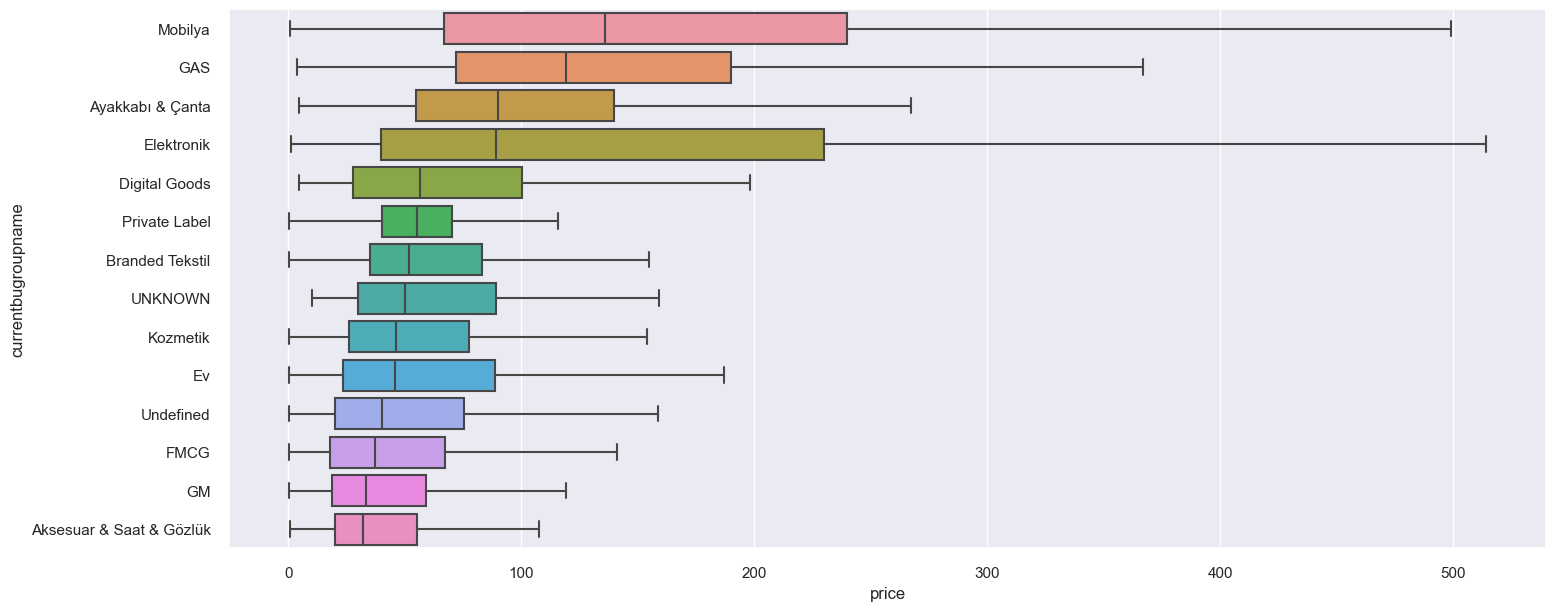

In [66]:
plt.figure(figsize=(17, 7))
box_plot_order = df_trx.fillna({"currentbugroupname": "Undefined"}).groupby("currentbugroupname").price.median().sort_values(ascending=False).index
sns.boxplot(x="price", y="currentbugroupname", data=df_trx.fillna({"currentbugroupname": "Undefined"}), showfliers=False, order=box_plot_order);
# plt.xticks(rotation=90);

In [67]:
df_trx_daily = df_trx.groupby(["userid", "currentbugroupname", pd.Grouper(key="partition_date", freq="D")], as_index=False).agg({"price": "sum", "quantity": "sum"})
df_trx_daily["price_per_product"] = df_trx_daily["price"] / df_trx_daily["quantity"]
df_trx_daily.query("userid == 12810").sort_values("partition_date")

userid currentbugroupname partition_date   price  quantity   
21   12810      Private Label     2020-10-04   59.49         1  \
3    12810   Ayakkabı & Çanta     2020-10-05   39.02         1   
22   12810      Private Label     2020-10-05  126.97         3   
23   12810      Private Label     2020-10-07  386.62         9   
17   12810            Mobilya     2020-10-07  251.44         2   
16   12810               FMCG     2020-10-07   13.90         1   
15   12810                 Ev     2020-10-07   36.42         3   
8    12810    Branded Tekstil     2020-10-07  153.89         3   
24   12810      Private Label     2020-10-08  715.89        16   
18   12810            Mobilya     2020-10-08   68.00         1   
9    12810    Branded Tekstil     2020-10-08  301.61         7   
4    12810   Ayakkabı & Çanta     2020-10-08  543.87         6   
25   12810      Private Label     2020-10-09   76.99         1   
10   12810    Branded Tekstil     2020-10-13  207.49         2   
26   12810      Private Label     2020-10-13   92.98         2   
11   12810    Branded Tekstil     2020-10-15  123.85         2   
5    12810   Ayakkabı & Çanta     2020-10-15  109.99         1   
12   12810    Branded Tekstil     2020-10-18  149.95         1   
6    12810   Ayakkabı & Çanta     2020-10-18  278.32         1   
7    12810   Ayakkabı & Çanta     2020-10-20  143.24         2   
19   12810            Mobilya     2020-10-21   82.65         1   
13   12810    Branded Tekstil     2020-10-21  539.93         3   
27   12810      Private Label     2020-10-23  115.78         3   
20   12810            Mobilya     2020-10-23   87.00         1   
14   12810    Branded Tekstil     2020-10-27   99.90         2   
28   12810      Private Label     2020-10-27   71.99         1   

    price_per_product  
21          59.490000  
3           39.020000  
22          42.323333  
23          42.957778  
17         125.720000  
16          13.900000  
15          12.140000  
8           51.296667  
24          44.743125  
18          68.000000  
9           43.087143  
4           90.645000  
25          76.990000  
10         103.745000  
26          46.490000  
11          61.925000  
5          109.990000  
12         149.950000  
6          278.320000  
7           71.620000  
19          82.650000  
13         179.976667  
27          38.593333  
20          87.000000  
14          49.950000  
28          71.990000

In [68]:
df_trx_base = df_train_melt.merge(df_trx_daily, on=["userid", "currentbugroupname"], how="left", suffixes=("", "_y")).fillna({"price": 0, "quantity": 0, "partition_date": df_trx.partition_date.min()})
df_trx_base.query("userid == 4321478").head()

userid        currentbugroupname target      partition_date  price   
2200   4321478  Aksesuar & Saat & Gözlük      0 2020-10-01 04:00:00    0.0  \
23565  4321478          Ayakkabı & Çanta      0 2020-10-01 04:00:00    0.0   
47144  4321478           Branded Tekstil      0 2020-10-01 04:00:00    0.0   
74884  4321478             Digital Goods      0 2020-10-01 04:00:00    0.0   
95478  4321478                Elektronik      0 2020-10-01 04:00:00    0.0   

       quantity  price_per_product  
2200        0.0                NaN  
23565       0.0                NaN  
47144       0.0                NaN  
74884       0.0                NaN  
95478       0.0                NaN

In [69]:
df_trx_base_final = agg_user_data(df_trx_base, {"price": [("price_per_product", "sum")]})
df_trx_base_final.loc[12810]

price_per_product_week_1  price_per_product_week_2   
currentbugroupname                                                             
Aksesuar & Saat & Gözlük                      0.00                      0.00  \
Ayakkabı & Çanta                              0.00                    582.89   
Branded Tekstil                               0.00                    455.50   
Digital Goods                                 0.00                      0.00   
Elektronik                                    0.00                      0.00   
Ev                                            0.00                     36.42   
FMCG                                          0.00                     13.90   
GAS                                           0.00                      0.00   
GM                                            0.00                      0.00   
Kozmetik                                      0.00                      0.00   
Mobilya                                       0.00                    319.44   
Private Label                                59.49                   1306.47   

                          price_per_product_week_3  price_per_product_week_4   
currentbugroupname                                                             
Aksesuar & Saat & Gözlük                      0.00                      0.00  \
Ayakkabı & Çanta                            388.31                    143.24   
Branded Tekstil                             481.29                    539.93   
Digital Goods                                 0.00                      0.00   
Elektronik                                    0.00                      0.00   
Ev                                            0.00                      0.00   
FMCG                                          0.00                      0.00   
GAS                                           0.00                      0.00   
GM                                            0.00                      0.00   
Kozmetik                                      0.00                      0.00   
Mobilya                                       0.00                    169.65   
Private Label                                92.98                    115.78   

                          price_per_product_week_5   
currentbugroupname                                   
Aksesuar & Saat & Gözlük                      0.00  \
Ayakkabı & Çanta                              0.00   
Branded Tekstil                              99.90   
Digital Goods                                 0.00   
Elektronik                                    0.00   
Ev                                            0.00   
FMCG                                          0.00   
GAS                                           0.00   
GM                                            0.00   
Kozmetik                                      0.00   
Mobilya                                       0.00   
Private Label                                71.99   

                          price_per_product_rolling_1_mean_week_1   
currentbugroupname                                                  
Aksesuar & Saat & Gözlük                                      NaN  \
Ayakkabı & Çanta                                              NaN   
Branded Tekstil                                               NaN   
Digital Goods                                                 NaN   
Elektronik                                                    NaN   
Ev                                                            NaN   
FMCG                                                          NaN   
GAS                                                           NaN   
GM                                                            NaN   
Kozmetik                                                      NaN   
Mobilya                                                       NaN   
Private Label                                                 NaN   

                          price_per_product_rolling_1_mean_w

In [70]:
def draw_feature_selection_plot(X_df, y_array, bugroupname="", showfliers=False):
    """ This function standardizes the columns in the dataset in order to make feature comparison easier. It then projects all columns onto boxplots to see
    their contribution to target variable.

    Args:
        X_df (pd.DataFrame)
        y_array (pd.Series)
        bugroupname (str)
        showfliers (bool, optional): Defaults to False.
    """
    dataframe = pd.concat([X_df, y_array], axis=1)
    df_base = dataframe.copy()

    data_dia = df_base["target"]
    data = df_base.drop(columns="target").dropna(axis=1, how="all")
    print(data.shape)

    data_n_2 = (data - data.mean()) / (data.std())              # standardization
    data = pd.concat([data_dia, data_n_2], axis=1)
    data = pd.melt(data,id_vars="target",
                        var_name="features",
                        value_name='value')
    plt.figure(figsize=(20,10))
    sns.boxplot(x="features", y="value", hue="target", data=data, showfliers=showfliers)
    plt.xticks(rotation=90);
    plt.title(bugroupname)
    plt.show();


## Zen Score
This is a crafted feature that aims to catch a non-linear interaction. In the simplest form, this score indicates if there is a specific bugroupname or bugroupnames that the customer keeps viewing or else is he/she actively wandering around the platform without focusing on a product within a day. This will simply tell the extent of which the user focused on specific kinds of products.

A number close to 1 means a Zen day (e.g., looking for a specific product) and a number closer to 0 means the user does not look for something specific.

Upon calculating the Zen Scores of each user in a given day, now it's time to calculate the number of Zen days and determine if the target currentbugroupname value is in the visit history of the user.


In [71]:

df_zen = df_visit.groupby(["userid",pd.Grouper(key="partition_date", freq="D")]).agg(
    {
        "productdetailcount": "sum", 
        "currentbugroupname": ["nunique", ("unique_groups", lambda x: list(set(x))[:5])]
    }
)

# Flattening column levels
df_zen.columns =  ["_".join(col_name).rstrip('_') for col_name in df_zen.columns.to_flat_index()]

# Finally calculate the zen ratio
df_zen["zen_ratio"] = df_zen.apply(lambda x: (1 - x["currentbugroupname_nunique"] / x["productdetailcount_sum"]) ** 2, axis=1)
df_zen.head()

productdetailcount_sum  currentbugroupname_nunique   
userid partition_date                                                       
12810  2020-10-03                          26                           3  \
       2020-10-04                           6                           4   
       2020-10-05                          40                           5   
       2020-10-06                         266                          10   
       2020-10-07                           1                           1   

                                        currentbugroupname_unique_groups   
userid partition_date                                                      
12810  2020-10-03      [Branded Tekstil, Ayakkabı & Çanta, Private La...  \
       2020-10-04             [GAS, Ayakkabı & Çanta, Ev, Private Label]   
       2020-10-05      [Ayakkabı & Çanta, Branded Tekstil, GAS, GM, P...   
       2020-10-06      [Ayakkabı & Çanta, FMCG, Branded Tekstil, GAS,...   
       2020-10-07                                      [Branded Tekstil]   

                       zen_ratio  
userid partition_date             
12810  2020-10-03       0.782544  
       2020-10-04       0.111111  
       2020-10-05       0.765625  
       2020-10-06       0.926225  
       2020-10-07       0.000000

In [72]:
df_zen_base = df_train_melt.merge(df_zen.reset_index(), on=["userid"], how="left", suffixes=("", "_y")).fillna({"fav_count": 0, "partition_date": df_zen.reset_index().partition_date.min()})
df_zen_base_final = agg_user_data(df_zen_base, {"zen_ratio": [("zen_ratio", "mean")]})
df_zen_base_final.loc[12810]



zen_ratio_week_1  zen_ratio_week_2   
currentbugroupname                                             
Aksesuar & Saat & Gözlük          0.446828          0.714771  \
Ayakkabı & Çanta                  0.446828          0.714771   
Branded Tekstil                   0.446828          0.714771   
Digital Goods                     0.446828          0.714771   
Elektronik                        0.446828          0.714771   
Ev                                0.446828          0.714771   
FMCG                              0.446828          0.714771   
GAS                               0.446828          0.714771   
GM                                0.446828          0.714771   
Kozmetik                          0.446828          0.714771   
Mobilya                           0.446828          0.714771   
Private Label                     0.446828          0.714771   

                          zen_ratio_week_3  zen_ratio_week_4   
currentbugroupname                                             
Aksesuar & Saat & Gözlük          0.710071          0.633474  \
Ayakkabı & Çanta                  0.710071          0.633474   
Branded Tekstil                   0.710071          0.633474   
Digital Goods                     0.710071          0.633474   
Elektronik                        0.710071          0.633474   
Ev                                0.710071          0.633474   
FMCG                              0.710071          0.633474   
GAS                               0.710071          0.633474   
GM                                0.710071          0.633474   
Kozmetik                          0.710071          0.633474   
Mobilya                           0.710071          0.633474   
Private Label                     0.710071          0.633474   

                          zen_ratio_week_5  zen_ratio_rolling_1_mean_week_1   
currentbugroupname                                                            
Aksesuar & Saat & Gözlük          0.678386                              NaN  \
Ayakkabı & Çanta                  0.678386                              NaN   
Branded Tekstil                   0.678386                              NaN   
Digital Goods                     0.678386                              NaN   
Elektronik                        0.678386                              NaN   
Ev                                0.678386                              NaN   
FMCG                              0.678386                              NaN   
GAS                               0.678386                              NaN   
GM                                0.678386                              NaN   
Kozmetik                          0.678386                              NaN   
Mobilya                           0.678386                              NaN   
Private Label                     0.678386                              NaN   

                          zen_ratio_rolling_1_mean_week_2   
currentbugroupname                                          
Aksesuar & Saat & Gözlük                         0.580799  \
Ayakkabı & Çanta                                 0.580799   
Branded Tekstil                                  0.580799   
Digital Goods                                    0.580799   
Elektronik                                       0.580799   
Ev                                               0.580799   
FMCG                                             0.580799   
GAS                                              0.580799   
GM                                               0.580799   
Kozmetik                                         0.580799   
Mobilya                                          0.580799   
Private Label                                    0.580799   

                          zen_ratio_rolling_1_mean_week_3   
currentbugroupname                                          
Aksesuar & Saat & Gözlük                         0.712421  \
Ayakkabı & Çanta                                 0.712421   
Branded Tekstil           

In [73]:
# Create time related variables
df_time = pd.concat([
        base_df_date_diff(df_fav, "fav_count"),
        base_df_date_diff(df_trx_daily, "quantity"),
        base_df_date_diff(df_basket_base, "addtobasket_count"),
        base_df_date_diff(df_visit, "productdetailcount")
      ], axis=1)
df_time_unique_ids = df_time.index.get_level_values(0).unique()
df_time.head()

fav_count_datediff  fav_count_maxdate_interval   
userid currentbugroupname                                                   
12810  Ayakkabı & Çanta              2.400000                         2.0  \
       Branded Tekstil               1.818182                         5.0   
       Ev                            6.000000                         8.0   
       GAS                           4.500000                         6.0   
       GM                            7.500000                         2.0   

                           fav_count_mindate_interval   
userid currentbugroupname                               
12810  Ayakkabı & Çanta                          28.0  \
       Branded Tekstil                           30.0   
       Ev                                        17.0   
       GAS                                       26.0   
       GM                                        25.0   

                           fav_count_most_freq_weekday_sin   
userid currentbugroupname                                    
12810  Ayakkabı & Çanta                          -0.781831  \
       Branded Tekstil                           -0.433884   
       Ev                                         0.781831   
       GAS                                        0.781831   
       GM                                         0.781831   

                           fav_count_most_freq_weekday_cos  quantity_datediff   
userid currentbugroupname                                                       
12810  Ayakkabı & Çanta                           0.623490           3.750000  \
       Branded Tekstil                           -0.900969           3.333333   
       Ev                                         0.623490                NaN   
       GAS                                        0.623490                NaN   
       GM                                         0.623490                NaN   

                           quantity_maxdate_interval   
userid currentbugroupname                              
12810  Ayakkabı & Çanta                          5.0  \
       Branded Tekstil                           5.0   
       Ev                                       26.0   
       GAS                                       NaN   
       GM                                        NaN   

                           quantity_mindate_interval   
userid currentbugroupname                              
12810  Ayakkabı & Çanta                         27.0  \
       Branded Tekstil                          31.0   
       Ev                                       26.0   
       GAS                                       NaN   
       GM                                        NaN   

                           quantity_most_freq_weekday_sin   
userid currentbugroupname                                   
12810  Ayakkabı & Çanta                          0.433884  \
       Branded Tekstil                           0.974928   
       Ev                                        0.974928   
       GAS                                            NaN   
       GM                                             NaN   

                           quantity_most_freq_weekday_cos   
userid currentbugroupname                                   
12810  Ayakkabı & Çanta                         -0.900969  \
       Branded Tekstil                          -0.222521   
       Ev                                       -0.222521   
       GAS                                            NaN   
       GM                                             NaN   

                           addtobasket_count_datediff   
userid currentbugroupname                               
12810  Ayakkabı & Çanta                           NaN  \
       Branded Tekstil                            NaN   
       Ev                                         NaN   
       GAS                                        NaN   
       GM                                         NaN   

                           addtobasket_cou

In [74]:
#List of unique BU names
unique_bu_names = df_train_melt.currentbugroupname.unique()

# Start merging base tables to df_final dataframe
df_final = df_train_melt.copy().merge(df_demo, on="userid", how="left")
tables_list = [df_fav_base_final, df_visit_base_final, df_basket_base_final, df_search_base_final, df_trx_base_final, df_zen_base_final, df_time]
for table in tables_list:
    df_final = df_final.merge(table, left_on=["userid", "currentbugroupname"], right_index=True, how="left")

df_final["gender"] = df_final["gender"].replace({"UNKNOWN": np.nan, "kvkktalepsilindi": np.nan})
# df_final.dropna(subset=["gender"], inplace=True)
df_final.set_index(["userid", "currentbugroupname"], inplace=True)

# Make count stats percentages instead of nominal values
df_final.loc[:, df_final.filter(regex="(^fav_count_week_\d+)").columns] = df_final.filter(regex="(^fav_count_week_\d+)").div(df_final.filter(regex="(^fav_count_week_\d+)").groupby(level=0).sum()).fillna(0)
df_final.loc[:, df_final.filter(regex="(^productdetailcount_week_\d+)").columns] = df_final.filter(regex="(^productdetailcount_week_\d+)").div(df_final.filter(regex="(^productdetailcount_week_\d+)").groupby(level=0).sum()).fillna(0)
df_final.loc[:, df_final.filter(regex="(^addtobasket_count_sum_week_\d+)").columns] = df_final.filter(regex="(^addtobasket_count_sum_week_\d+)").div(df_final.filter(regex="(^addtobasket_count_sum_week_\d+)").groupby(level=0).sum()).fillna(0)
df_final.loc[:, df_final.filter(regex="(^searched_count_week_\d+)").columns] = df_final.filter(regex="(^searched_count_week_\d+)").div(df_final.filter(regex="(^searched_count_week_\d+)").groupby(level=0).sum()).fillna(0)
df_final.loc[:, df_final.filter(regex="(^price_per_product_week_\d+)").columns] = df_final.filter(regex="(^price_per_product_week_\d+)").div(df_final.filter(regex="(^price_per_product_week_\d+)").groupby(level=0).sum()).fillna(0)

df_final.reset_index(inplace=True)

# Ghost users are the ones that have not done a single transaction in any of the tables. They just come out of blue, purchase an item and gone.
df_final["ghost_customer"] = np.where(df_final.userid.isin(df_time_unique_ids) == False, 1, 0)

# Fill datediff columns with an arbitrary number basically any number roughly around 60 (which I assume to be the reset time for customer pattern)
df_final.loc[:, "fav_count_datediff":] = df_final.loc[:, "fav_count_datediff":].fillna(55)
df_final.query("userid == 12810")



userid        currentbugroupname target  gender   age  tenure   
1        12810  Aksesuar & Saat & Gözlük      0     1.0  37.0   128.0  \
20403    12810          Ayakkabı & Çanta      1     1.0  37.0   128.0   
40805    12810           Branded Tekstil      0     1.0  37.0   128.0   
61207    12810             Digital Goods      0     1.0  37.0   128.0   
81609    12810                Elektronik      0     1.0  37.0   128.0   
102011   12810                        Ev      0     1.0  37.0   128.0   
122413   12810                      FMCG      0     1.0  37.0   128.0   
142815   12810                       GAS      0     1.0  37.0   128.0   
163217   12810                        GM      0     1.0  37.0   128.0   
183619   12810                  Kozmetik      0     1.0  37.0   128.0   
204021   12810                   Mobilya      0     1.0  37.0   128.0   
224423   12810             Private Label      1     1.0  37.0   128.0   

        fav_count_week_1  fav_count_week_2  fav_count_week_3   
1               0.000000          0.000000          0.000000  \
20403           0.428571          0.144928          0.416667   
40805           0.285714          0.217391          0.250000   
61207           0.000000          0.000000          0.000000   
81609           0.000000          0.000000          0.000000   
102011          0.000000          0.043478          0.027778   
122413          0.000000          0.000000          0.000000   
142815          0.000000          0.014493          0.083333   
163217          0.000000          0.086957          0.000000   
183619          0.000000          0.014493          0.055556   
204021          0.000000          0.028986          0.000000   
224423          0.285714          0.449275          0.166667   

        fav_count_week_4  fav_count_week_5  fav_count_rolling_1_mean_week_1   
1               0.000000              0.00                              NaN  \
20403           0.260870              0.25                              NaN   
40805           0.347826              0.00                              NaN   
61207           0.000000              0.00                              NaN   
81609           0.000000              0.00                              NaN   
102011          0.000000              0.00                              NaN   
122413          0.000000              0.00                              NaN   
142815          0.000000              0.00                              NaN   
163217          0.043478              0.00                              NaN   
183619          0.000000              0.00                              NaN   
204021          0.043478              0.00                              NaN   
224423          0.304348              0.75                              NaN   

        fav_count_rolling_1_mean_week_2  fav_count_rolling_1_mean_week_3   
1                                   0.0                              0.0  \
20403                               6.5                             12.5   
40805                               8.5                             12.0   
61207                               0.0                              0.0   
81609                               0.0                              0.0   
102011                              1.5                              2.0   
122413                              0.0                              0.0   
142815                              0.5                              2.0   
163217                              3.0                              3.0   
183619                              0.5                              1.5   
204021                              1.0                              1.0   
224423                             16.5                             18.5   

        fav_count_rolling_1_mean_week_4  fav_count_rolling_1_mean_week_5   
1                                   0.0                              0.0  \
20403                              10.5                 

In [75]:
# Let's see if the test set after data processing checks out with the original test_df
df_test.groupby("userid").currentbugroupname.nunique().value_counts()

currentbugroupname
12    20403
Name: count, dtype: int64

In [76]:
df_final.query("target == 'test_set'").groupby("userid").currentbugroupname.nunique().value_counts()

currentbugroupname
12    20403
Name: count, dtype: int64

In [77]:
df_test_set = df_final.copy().query("target == 'test_set'").reset_index(drop=True)
df_test_set.drop(columns=["target"], inplace=True)
df_test_set.head()

userid currentbugroupname  gender        age  tenure  fav_count_week_1   
0  20152944      Private Label     1.0  25.000000    21.0               0.0  \
1   6662068      Private Label     1.0  36.333333   104.0               0.0   
2  11941706      Private Label     1.0  32.000000    55.0               0.0   
3  12406170      Private Label     1.0  26.666667    50.0               0.0   
4  20939786      Private Label     0.0  26.666667    19.0               0.0   

   fav_count_week_2  fav_count_week_3  fav_count_week_4  fav_count_week_5   
0               0.0               0.0               1.0               0.0  \
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   fav_count_rolling_1_mean_week_1  fav_count_rolling_1_mean_week_2   
0                              NaN                              0.0  \
1                              NaN                              0.0   
2                              NaN                              0.0   
3                              NaN                              0.0   
4                              NaN                              0.0   

   fav_count_rolling_1_mean_week_3  fav_count_rolling_1_mean_week_4   
0                              0.0                              3.5  \
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   fav_count_rolling_1_mean_week_5  fav_count_rolling_2_mean_week_1   
0                              3.5                              NaN  \
1                              0.0                              NaN   
2                              0.0                              NaN   
3                              0.0                              NaN   
4                              0.0                              NaN   

   fav_count_rolling_2_mean_week_2  fav_count_rolling_2_mean_week_3   
0                              NaN                              0.0  \
1                              NaN                              0.0   
2                              NaN                              0.0   
3                              NaN                              0.0   
4                              NaN                              0.0   

   fav_count_rolling_2_mean_week_4  fav_count_rolling_2_mean_week_5   
0                         2.333333                         2.333333  \
1                         0.000000                         0.000000   
2                         0.000000                         0.000000   
3                         0.000000                         0.000000   
4                         0.000000                         0.000000   

   fav_count_expanding_mean_week_1  fav_count_expanding_mean_week_2   
0                              0.0                              0.0  \
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   fav_count_expanding_mean_week_3  fav_count_expanding_mean_week_4   
0                              0.0                             1.75  \
1                              0.0                             0.00   
2                              0.0                             0.00   
3                              0.0                             0.00   
4                              0.0                             0.00   

   fav_count_expanding_mean_week_5  productdetailcount_week_1   
0            

In [78]:
df_final = df_final.query("target != 'test_set'").reset_index(drop=True)
df_final["target"] = df_final["target"].astype(float)
df_final.dropna(subset=["gender"], inplace=True)
df_final.head()

userid        currentbugroupname  target  gender   age  tenure   
0    2086  Aksesuar & Saat & Gözlük     0.0     1.0  44.0   129.0  \
1   12810  Aksesuar & Saat & Gözlük     0.0     1.0  37.0   128.0   
2   14302  Aksesuar & Saat & Gözlük     0.0     0.0  34.0   127.0   
3   15148  Aksesuar & Saat & Gözlük     0.0     1.0  39.0   127.0   
4   32508  Aksesuar & Saat & Gözlük     0.0     1.0  35.0   127.0   

   fav_count_week_1  fav_count_week_2  fav_count_week_3  fav_count_week_4   
0               0.0               0.0               0.0               0.0  \
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   fav_count_week_5  fav_count_rolling_1_mean_week_1   
0          0.000000                              NaN  \
1          0.000000                              NaN   
2          0.000000                              NaN   
3          0.000000                              NaN   
4          0.333333                              NaN   

   fav_count_rolling_1_mean_week_2  fav_count_rolling_1_mean_week_3   
0                              0.0                              0.0  \
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   fav_count_rolling_1_mean_week_4  fav_count_rolling_1_mean_week_5   
0                              0.0                              0.0  \
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.5   

   fav_count_rolling_2_mean_week_1  fav_count_rolling_2_mean_week_2   
0                              NaN                              NaN  \
1                              NaN                              NaN   
2                              NaN                              NaN   
3                              NaN                              NaN   
4                              NaN                              NaN   

   fav_count_rolling_2_mean_week_3  fav_count_rolling_2_mean_week_4   
0                              0.0                              0.0  \
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   fav_count_rolling_2_mean_week_5  fav_count_expanding_mean_week_1   
0                         0.000000                              0.0  \
1                         0.000000                              0.0   
2                         0.000000                              0.0   
3                         0.000000                              0.0   
4                         0.333333                              0.0   

   fav_count_expanding_mean_week_2  fav_count_expanding_mean_week_3   
0                              0.0                              0.0  \
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   fav_count_expanding_mean_week_4  fav_count_expanding_mean_week_5   
0                              0.0                              0.0  \
1                              0.0                              0.0   
2            

In [79]:
df_final.target.value_counts()

target
0.0    220090
1.0     24734
Name: count, dtype: int64

In [80]:
def create_contingency_table(dt, column):
    dataframe = dt.copy()
    independent_variable = dataframe[column]
    crs = pd.crosstab(independent_variable, dataframe["target"], margins=True)
    crs = crs.div(crs["All"], axis=0).assign(All=crs["All"])
    multi_index = [(column, k) for k in crs.index]
    crs.index = pd.MultiIndex.from_tuples(multi_index)
    crs.columns.name = None
    return crs

In [81]:
def analyze_categorical(variable):
    cont_tables = pd.DataFrame()
    for domain in unique_bu_names:
        cont_table = create_contingency_table(df_final.query(f"currentbugroupname == '{domain}'"), variable)
        cont_table.index = pd.MultiIndex.from_tuples(((domain, *item) for item in cont_table.index))
        cont_tables = pd.concat([cont_tables, cont_table])
    return cont_tables

In [82]:
# Seems like gender variable does not effect purchasing behavior when looking into whole dataset.
create_contingency_table(df_final, "gender")

0.0       1.0     All
gender 0.0                 0.906936  0.093064   56832
       0.3333333333333333  0.897436  0.102564     312
       0.6666666666666666  0.890625  0.109375     384
       1.0                 0.896575  0.103425  187296
       All                 0.898972  0.101028  244824

In [83]:
# However if we look into details it seems like a significant effect on the probability of purchasing item.
# Take Branded Tekstil BU for instance. Being Bay significantly decreases the probability of purchasing an Branded Tekstil BU
analyze_categorical("gender")

0.0       1.0    All
Aksesuar & Saat & Gözlük gender 0.0                 0.963682  0.036318   4736
                                0.3333333333333333  0.884615  0.115385     26
                                0.6666666666666666  0.968750  0.031250     32
                                1.0                 0.961750  0.038250  15608
                                All                 0.962112  0.037888  20402
Ayakkabı & Çanta         gender 0.0                 0.916385  0.083615   4736
                                0.3333333333333333  0.923077  0.076923     26
                                0.6666666666666666  0.968750  0.031250     32
                                1.0                 0.906202  0.093798  15608
                                All                 0.908685  0.091315  20402
Branded Tekstil          gender 0.0                 0.792441  0.207559   4736
                                0.3333333333333333  0.769231  0.230769     26
                                0.6666666666666666  0.843750  0.156250     32
                                1.0                 0.729370  0.270630  15608
                                All                 0.744241  0.255759  20402
Digital Goods            gender 0.0                 0.992399  0.007601   4736
                                0.3333333333333333  1.000000  0.000000     26
                                0.6666666666666666  1.000000  0.000000     32
                                1.0                 0.998526  0.001474  15608
                                All                 0.997108  0.002892  20402
Elektronik               gender 0.0                 0.872677  0.127323   4736
                                0.3333333333333333  0.961538  0.038462     26
                                0.6666666666666666  0.906250  0.093750     32
                                1.0                 0.924462  0.075538  15608
                                All                 0.912460  0.087540  20402
Ev                       gender 0.0                 0.905828  0.094172   4736
                                0.3333333333333333  0.807692  0.192308     26
                                0.6666666666666666  0.781250  0.218750     32
                                1.0                 0.858022  0.141978  15608
                                All                 0.868934  0.131066  20402
FMCG                     gender 0.0                 0.807221  0.192779   4736
                                0.3333333333333333  0.884615  0.115385     26
                                0.6666666666666666  0.656250  0.343750     32
                                1.0                 0.789979  0.210021  15608
                                All                 0.793893  0.206107  20402
GAS                      gender 0.0                 0.930532  0.069468   4736
                                0.3333333333333333  0.884615  0.115385     26
                                0.6666666666666666  1.000000  0.000000     32
                                1.0                 0.963865  0.036135  15608
                                All                 0.956083  0.043917  20402
GM                       gender 0.0                 0.819679  0.180321   4736
                                0.3333333333333333  0.807692  0.192308     26
                                0.6666666666666666  0.781250  0.218750     32
                                1.0                 0.840851  0.159149  15608
                                All                 0.835800  0.164200  20402
Kozmetik                 gender 0.0                 0.959671  0.040329   4736
                                0.3333333333333333  0.961538  0.038462     26
                                0.6666666666666666  0.968750  0.031250     32
                                1.0                 0.925423  0.074577  15608
                                All                 0.933487  0.066513  20402
Mobilya                  gender 0.0                 0.971284  0.028716   4736
 

In [84]:
# Same here for ghost customer. Being a ghost_customer significantly increasing chances of purchasing Elektronik product.
analyze_categorical("ghost_customer")

0.0       1.0    All
Aksesuar & Saat & Gözlük ghost_customer 0    0.962122  0.037878  19695
                                        1    0.961810  0.038190    707
                                        All  0.962112  0.037888  20402
Ayakkabı & Çanta         ghost_customer 0    0.908403  0.091597  19695
                                        1    0.916549  0.083451    707
                                        All  0.908685  0.091315  20402
Branded Tekstil          ghost_customer 0    0.741305  0.258695  19695
                                        1    0.826025  0.173975    707
                                        All  0.744241  0.255759  20402
Digital Goods            ghost_customer 0    0.997207  0.002793  19695
                                        1    0.994342  0.005658    707
                                        All  0.997108  0.002892  20402
Elektronik               ghost_customer 0    0.915918  0.084082  19695
                                        1    0.816124  0.183876    707
                                        All  0.912460  0.087540  20402
Ev                       ghost_customer 0    0.868190  0.131810  19695
                                        1    0.889675  0.110325    707
                                        All  0.868934  0.131066  20402
FMCG                     ghost_customer 0    0.794516  0.205484  19695
                                        1    0.776521  0.223479    707
                                        All  0.793893  0.206107  20402
GAS                      ghost_customer 0    0.956385  0.043615  19695
                                        1    0.947666  0.052334    707
                                        All  0.956083  0.043917  20402
GM                       ghost_customer 0    0.837979  0.162021  19695
                                        1    0.775106  0.224894    707
                                        All  0.835800  0.164200  20402
Kozmetik                 ghost_customer 0    0.933181  0.066819  19695
                                        1    0.942008  0.057992    707
                                        All  0.933487  0.066513  20402
Mobilya                  ghost_customer 0    0.972430  0.027570  19695
                                        1    0.968883  0.031117    707
                                        All  0.972307  0.027693  20402
Private Label            ghost_customer 0    0.901193  0.098807  19695
                                        1    0.940594  0.059406    707
                                        All  0.902559  0.097441  20402

In [85]:
df_final.gender.value_counts(normalize=True)

gender
1.000000    0.765023
0.000000    0.232134
0.666667    0.001568
0.333333    0.001274
Name: proportion, dtype: float64

(20402, 125)


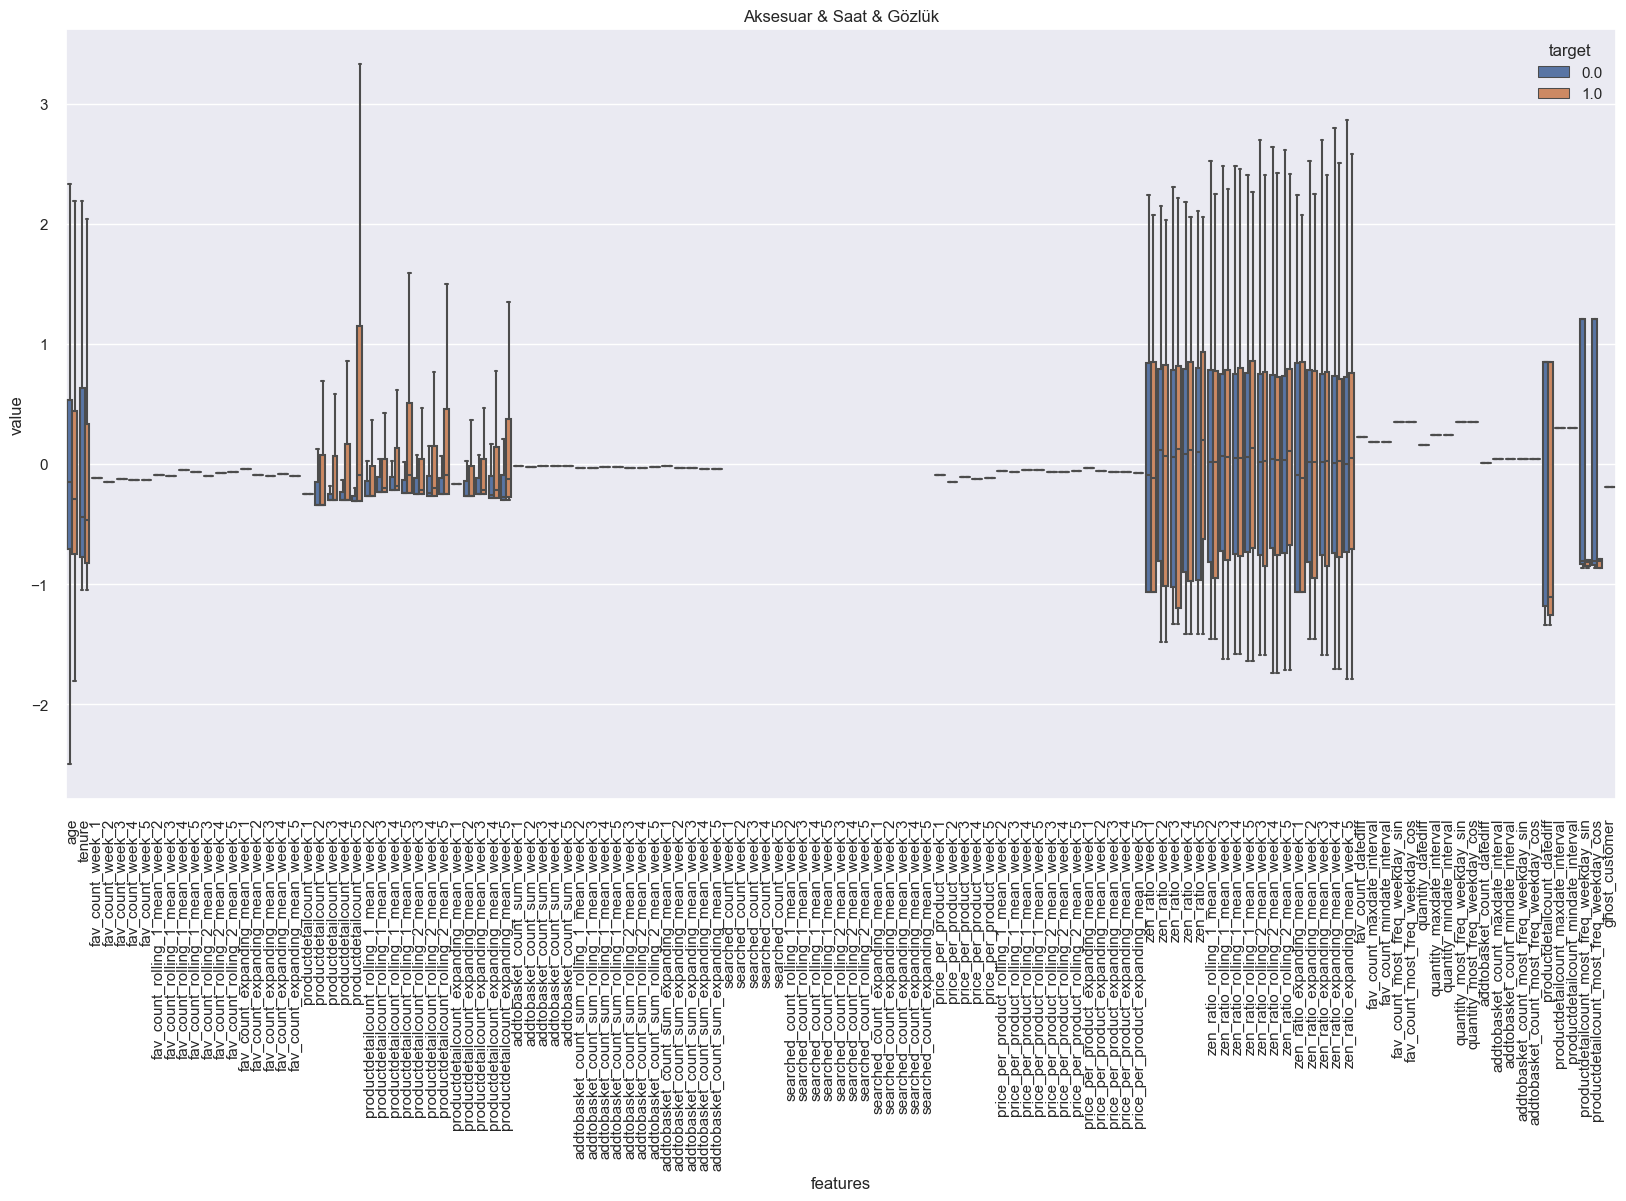

(20402, 125)


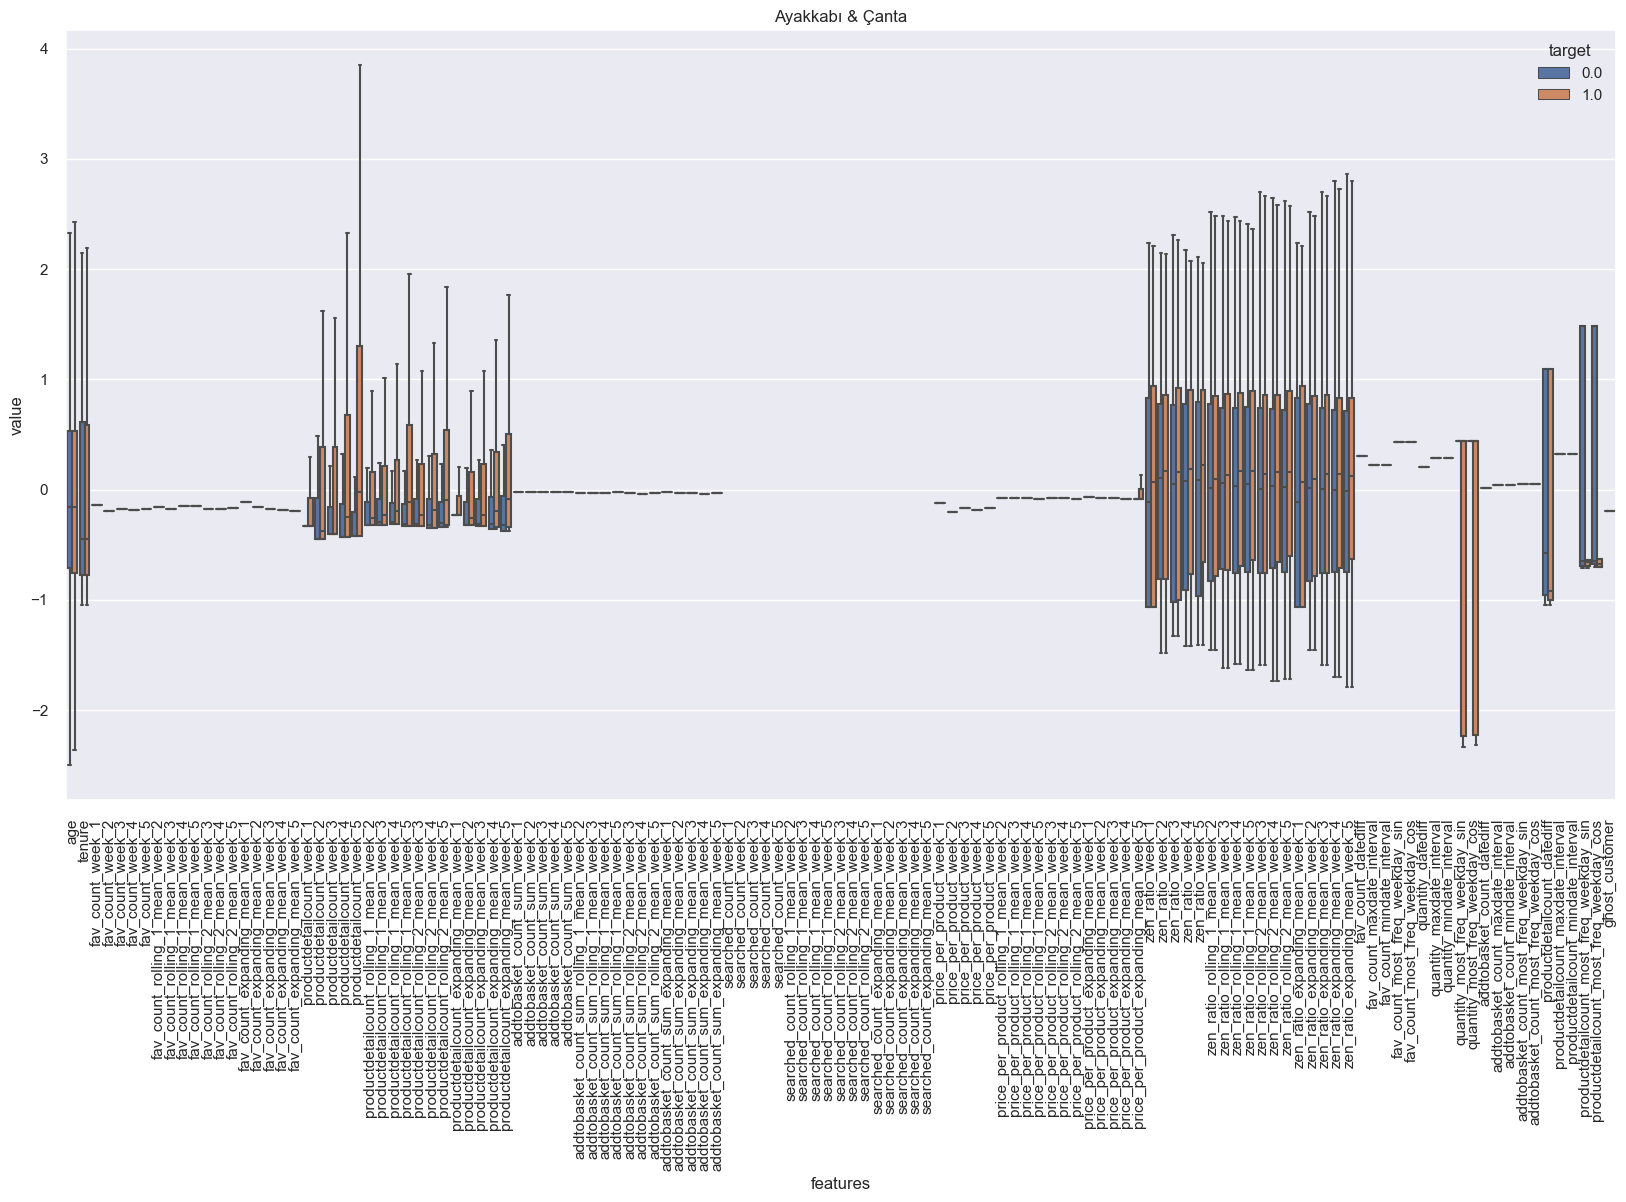

(20402, 125)


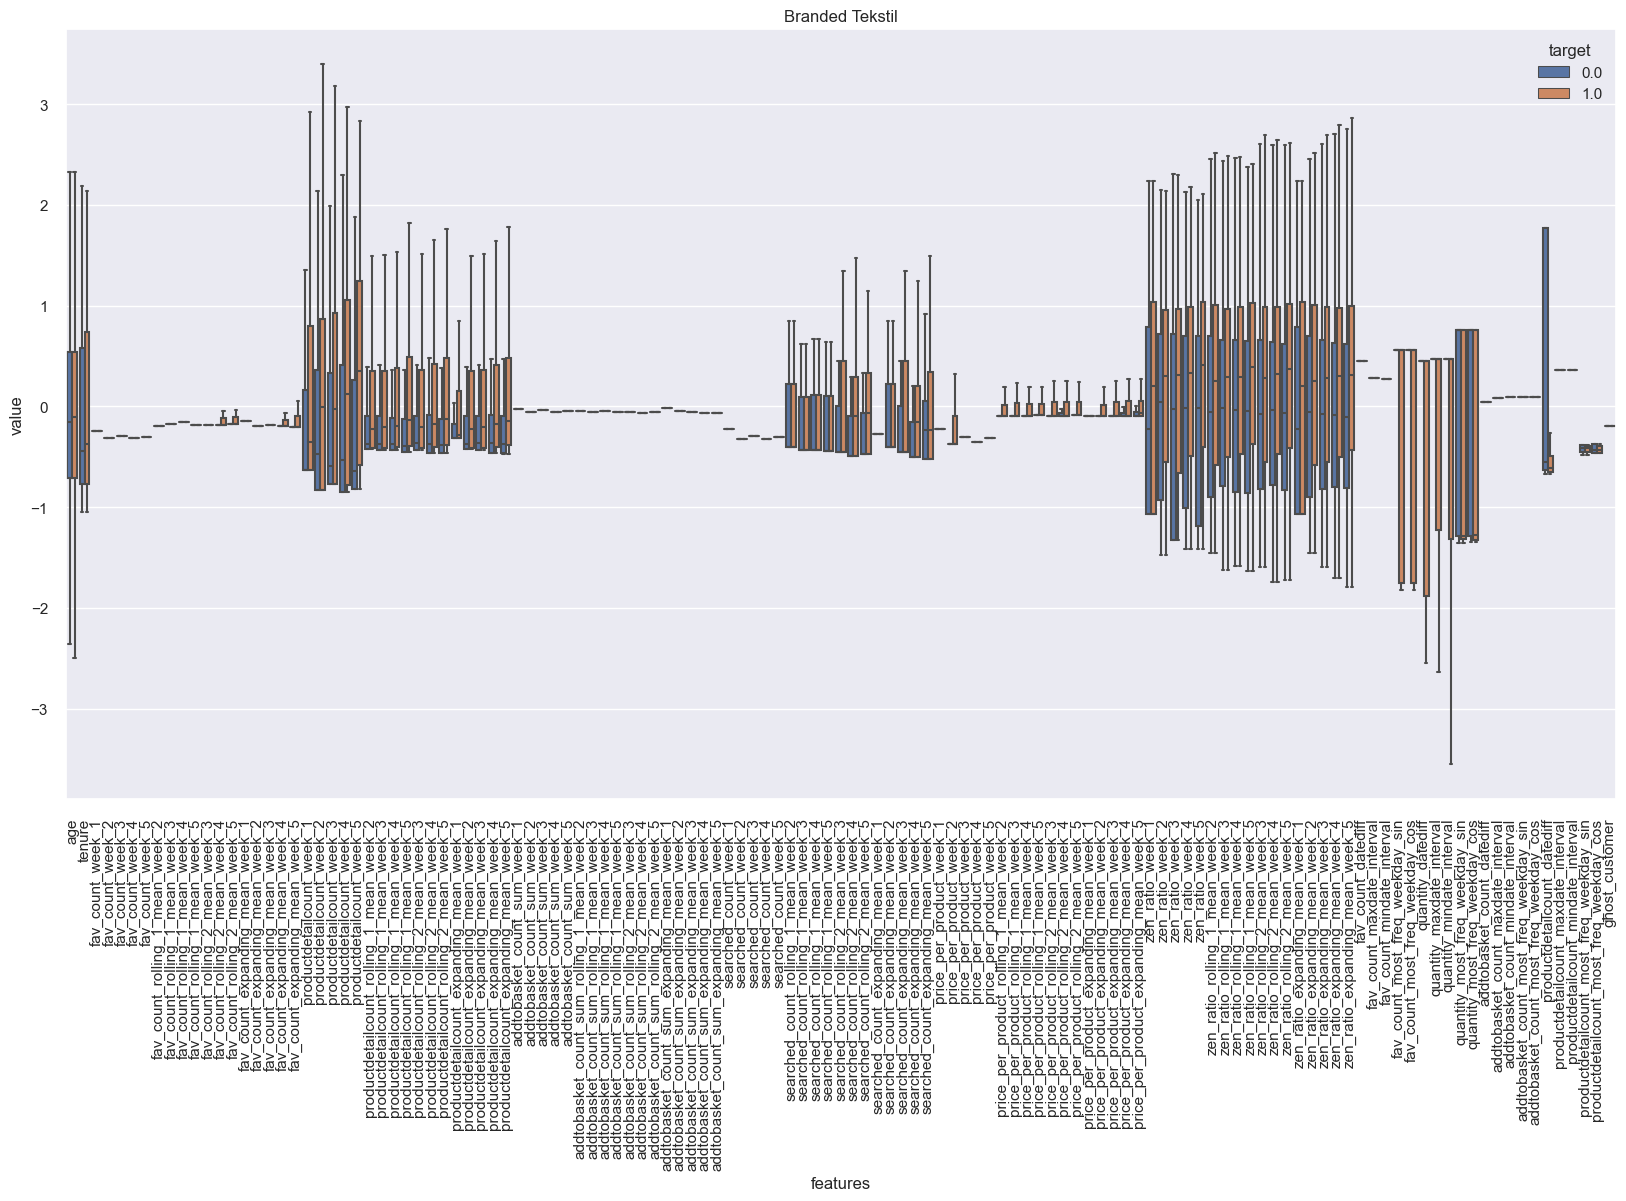

(20402, 125)


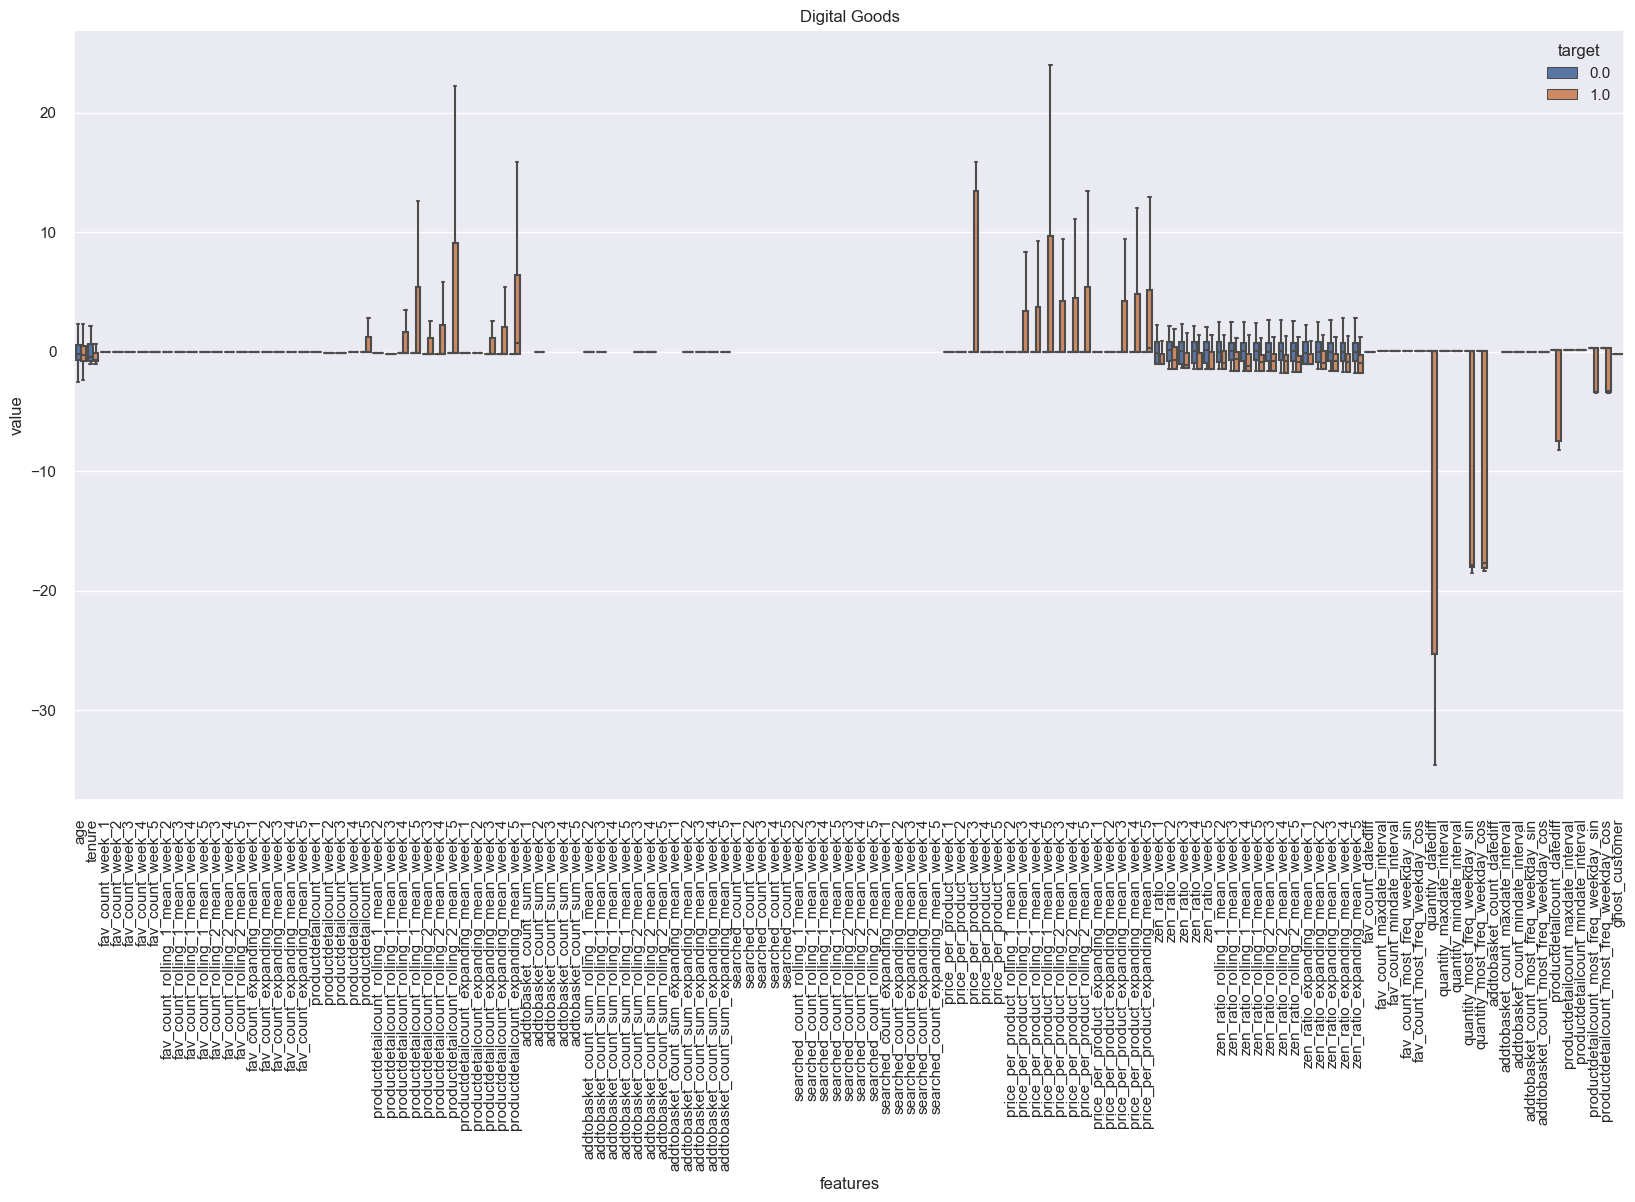

(20402, 125)


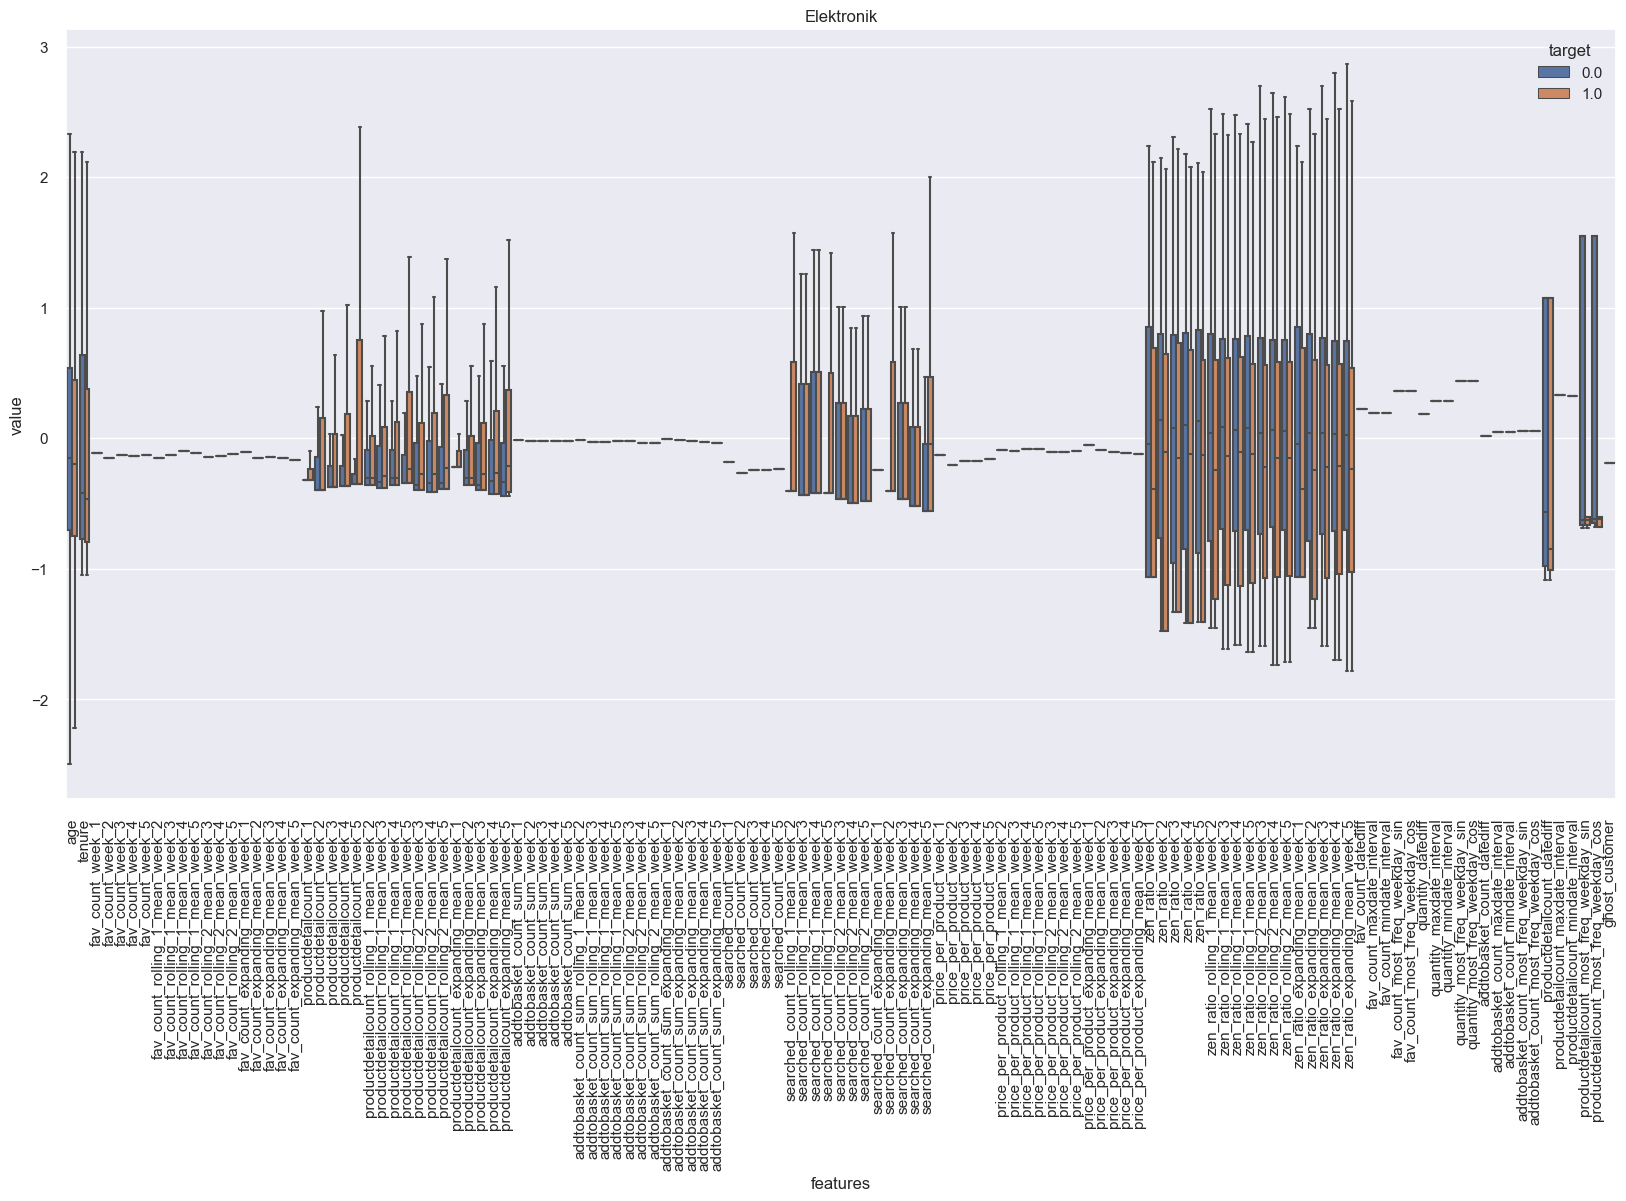

(20402, 125)


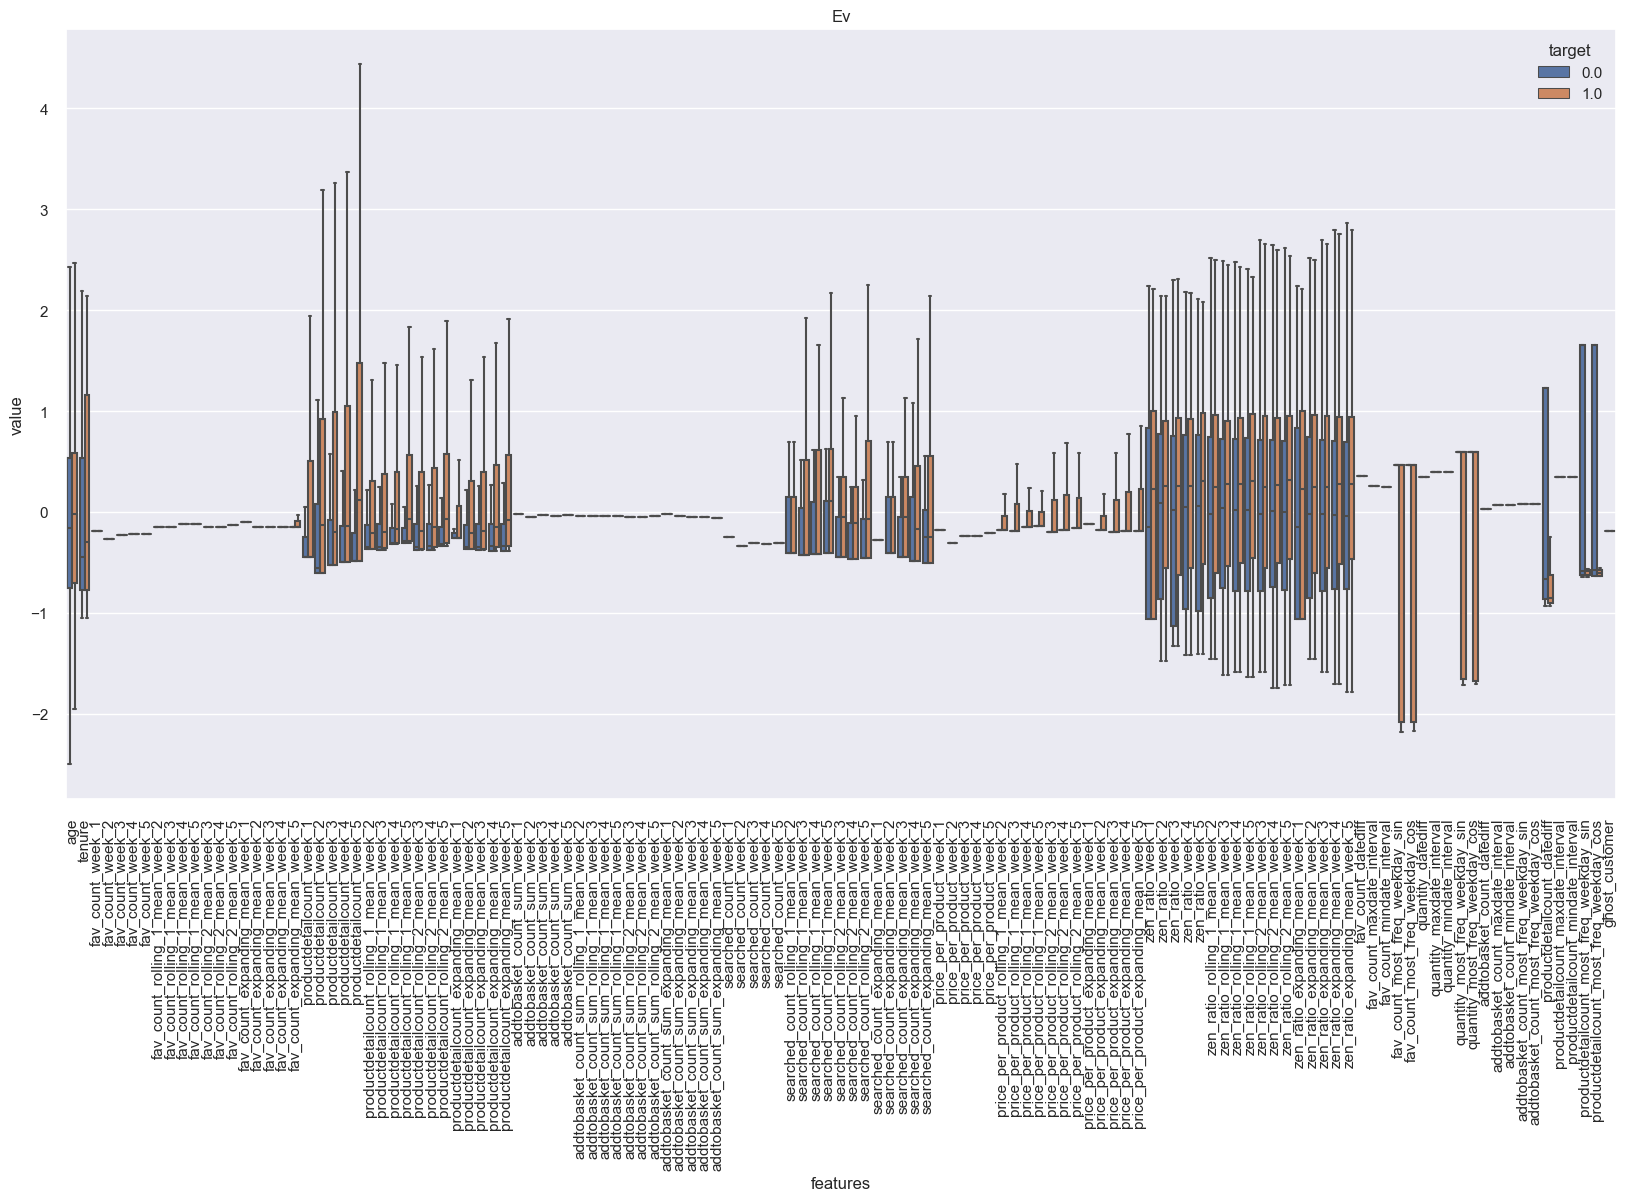

(20402, 125)


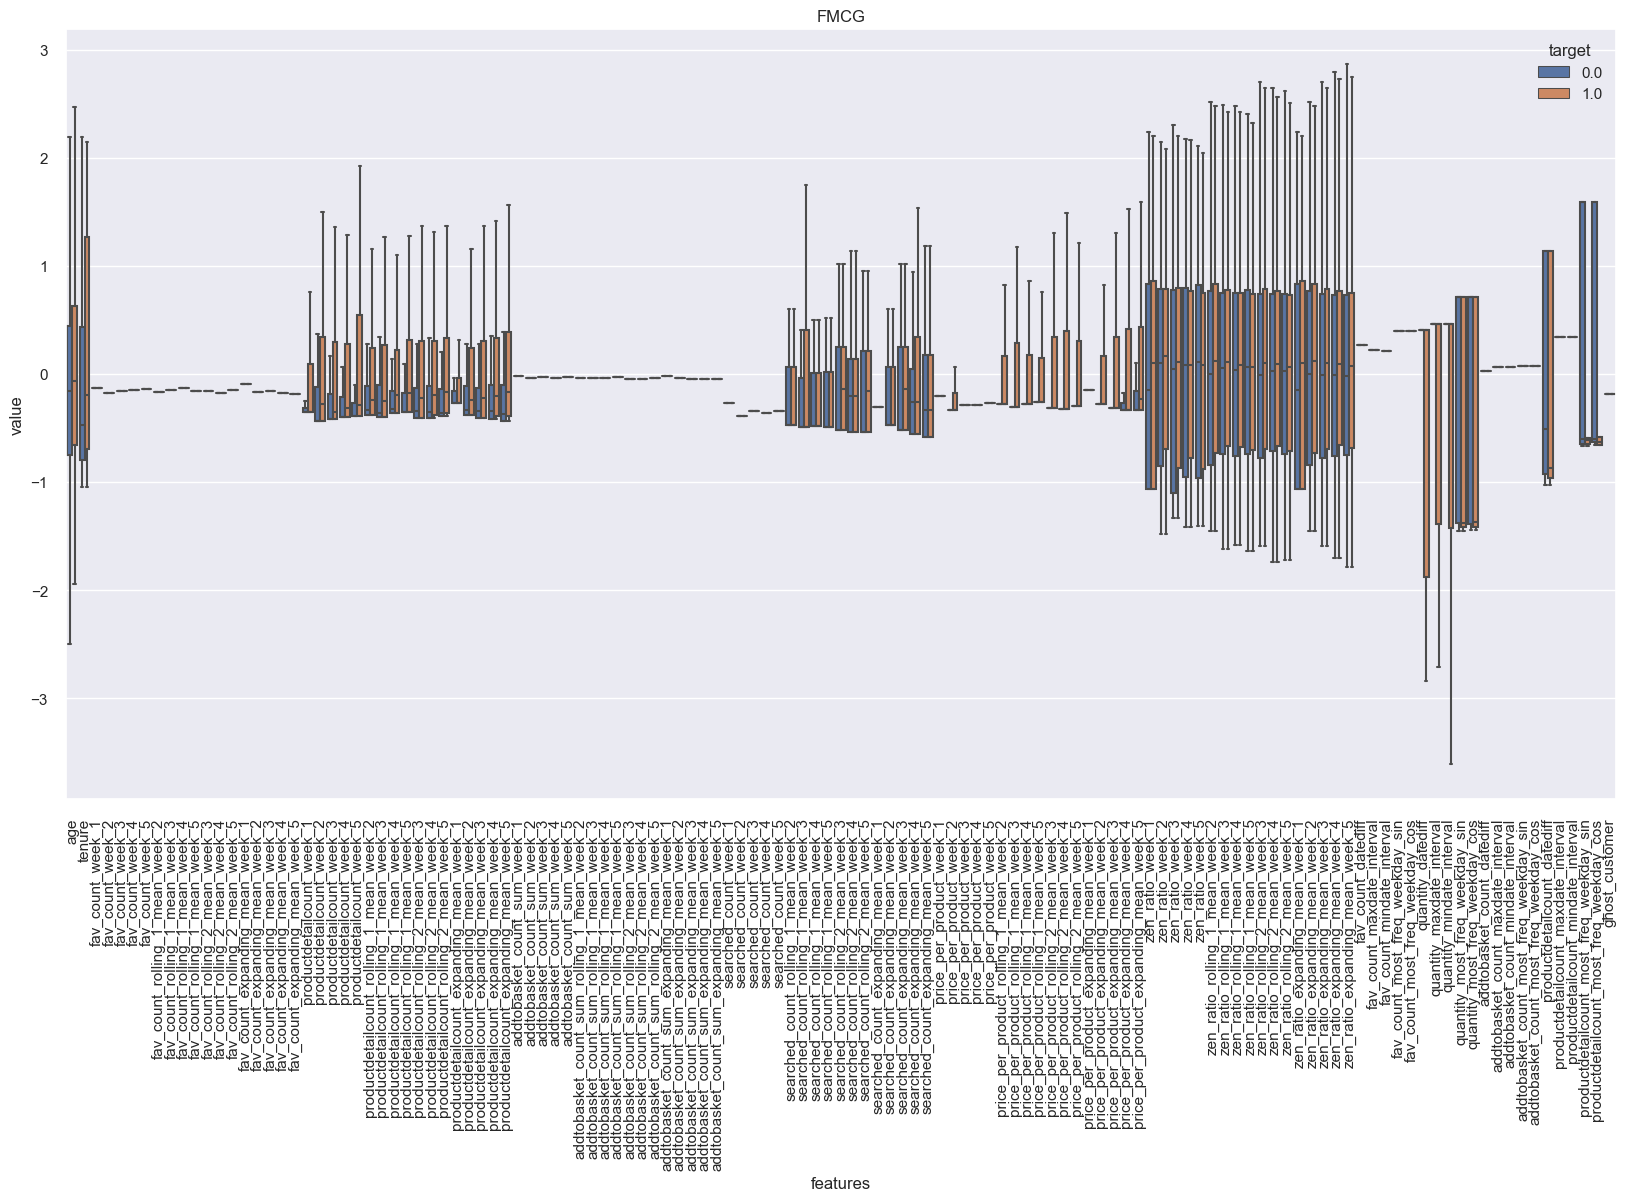

(20402, 125)


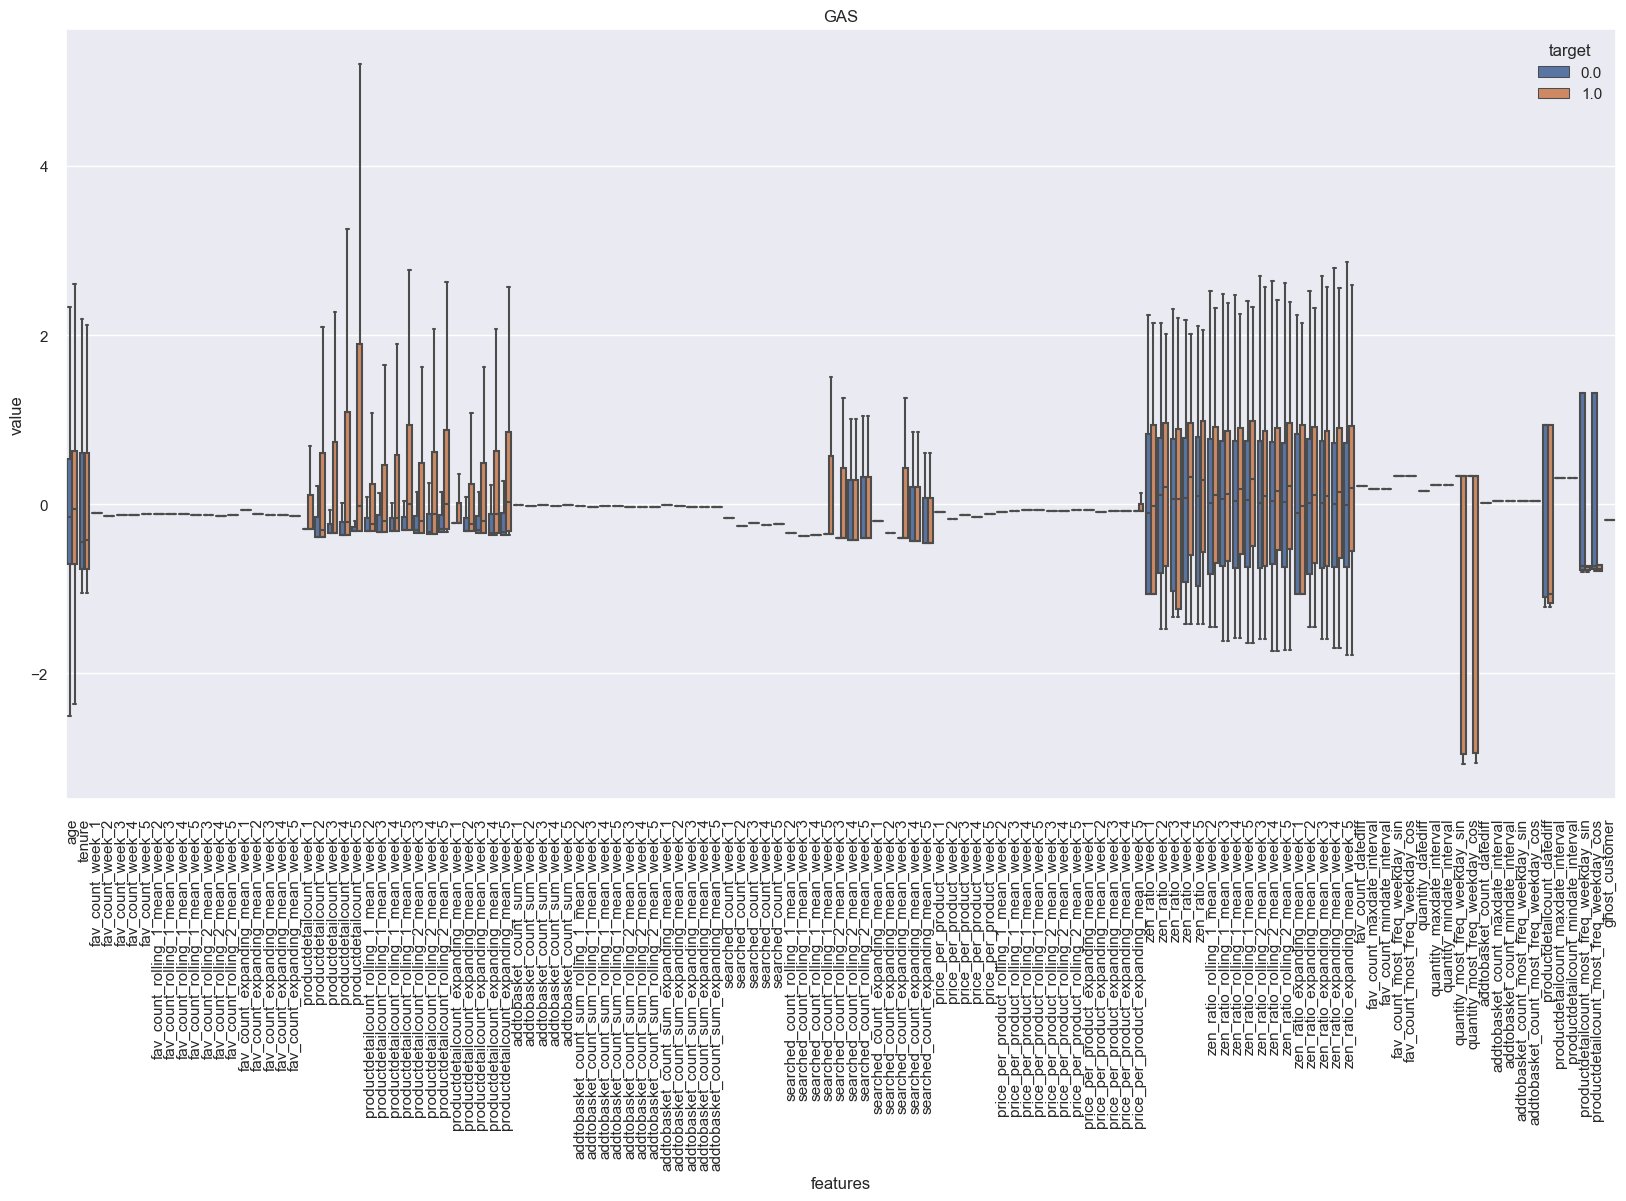

(20402, 125)


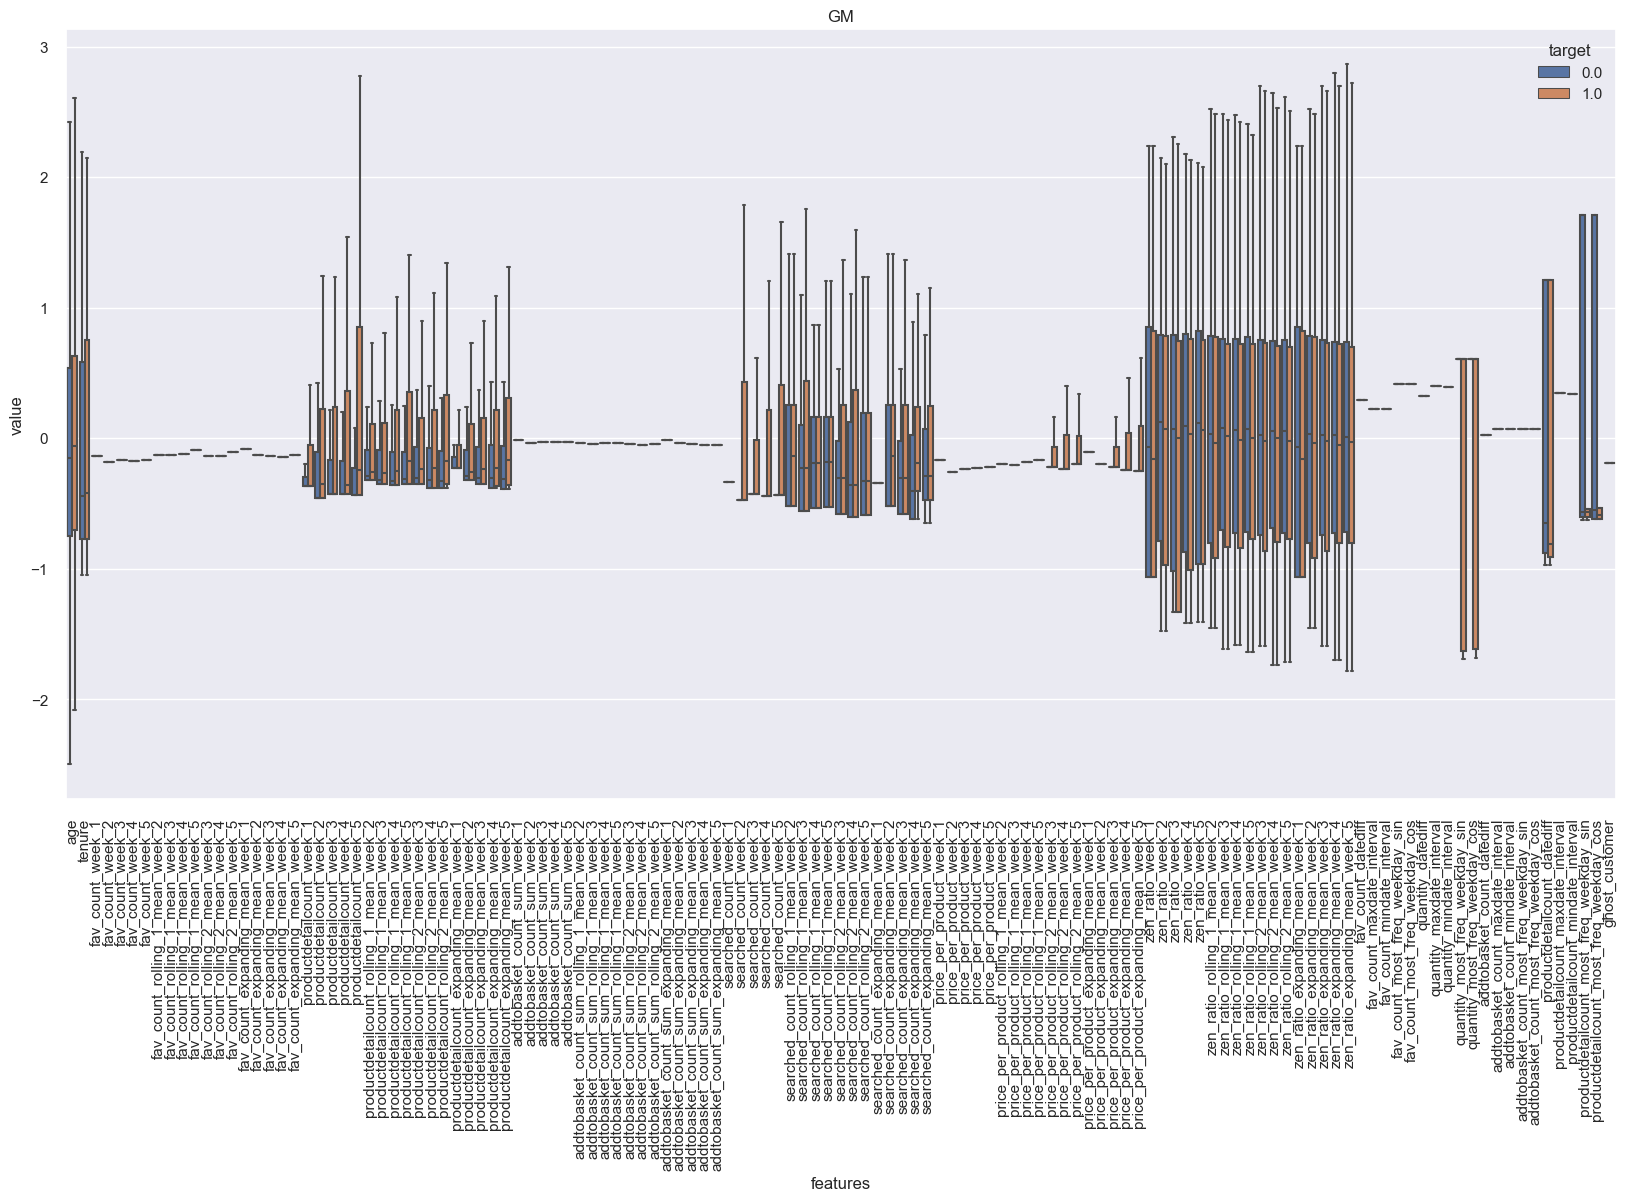

(20402, 125)


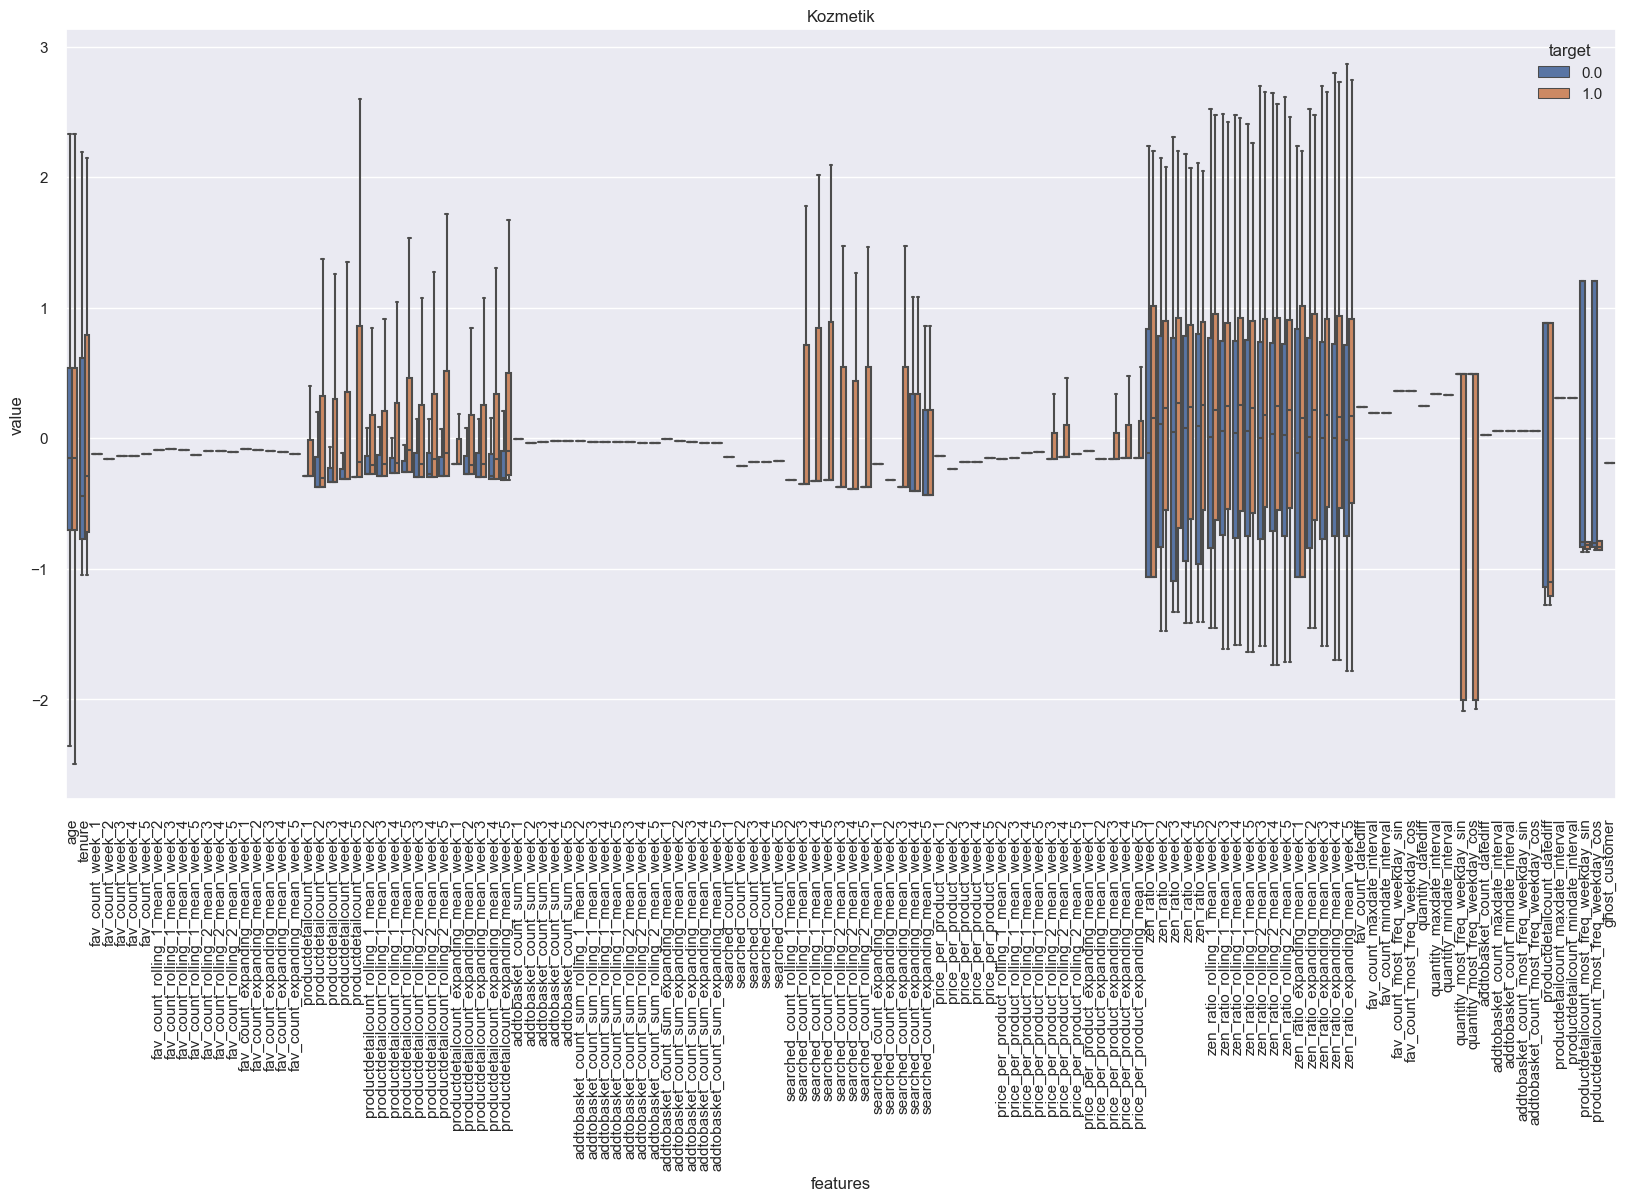

(20402, 125)


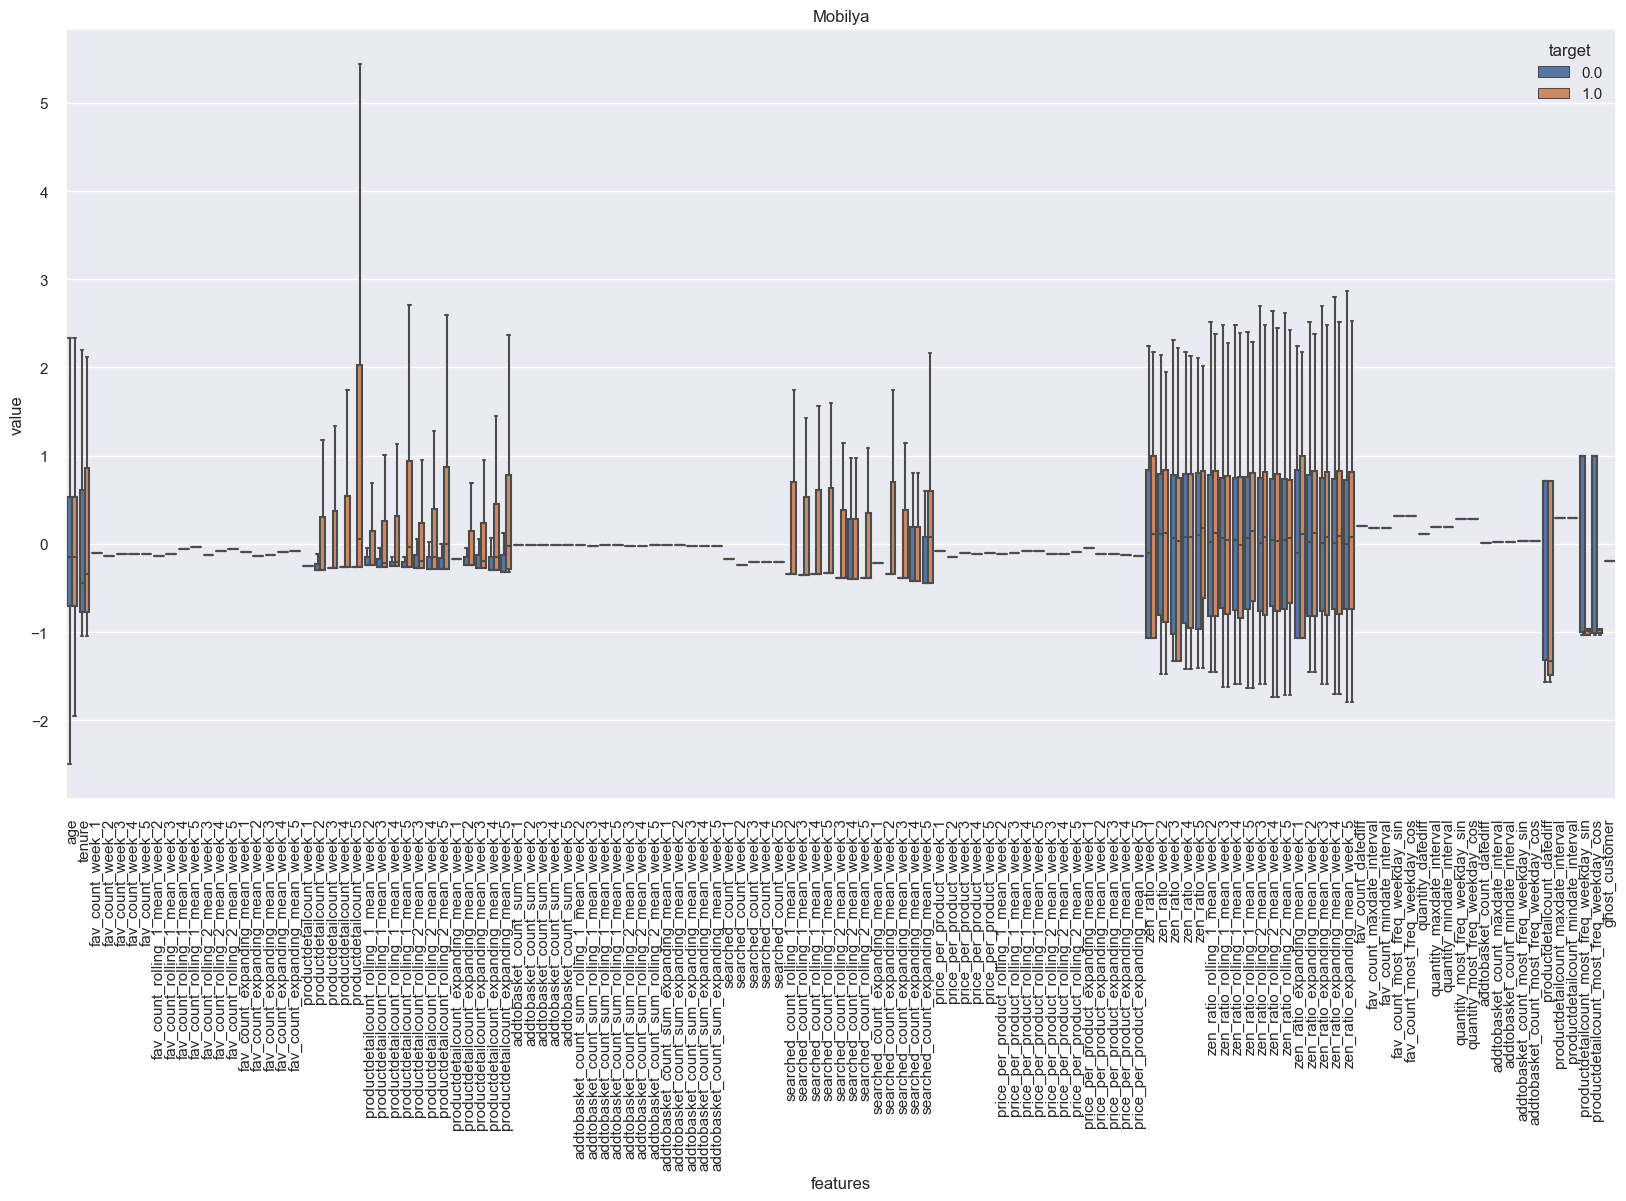

(20402, 125)


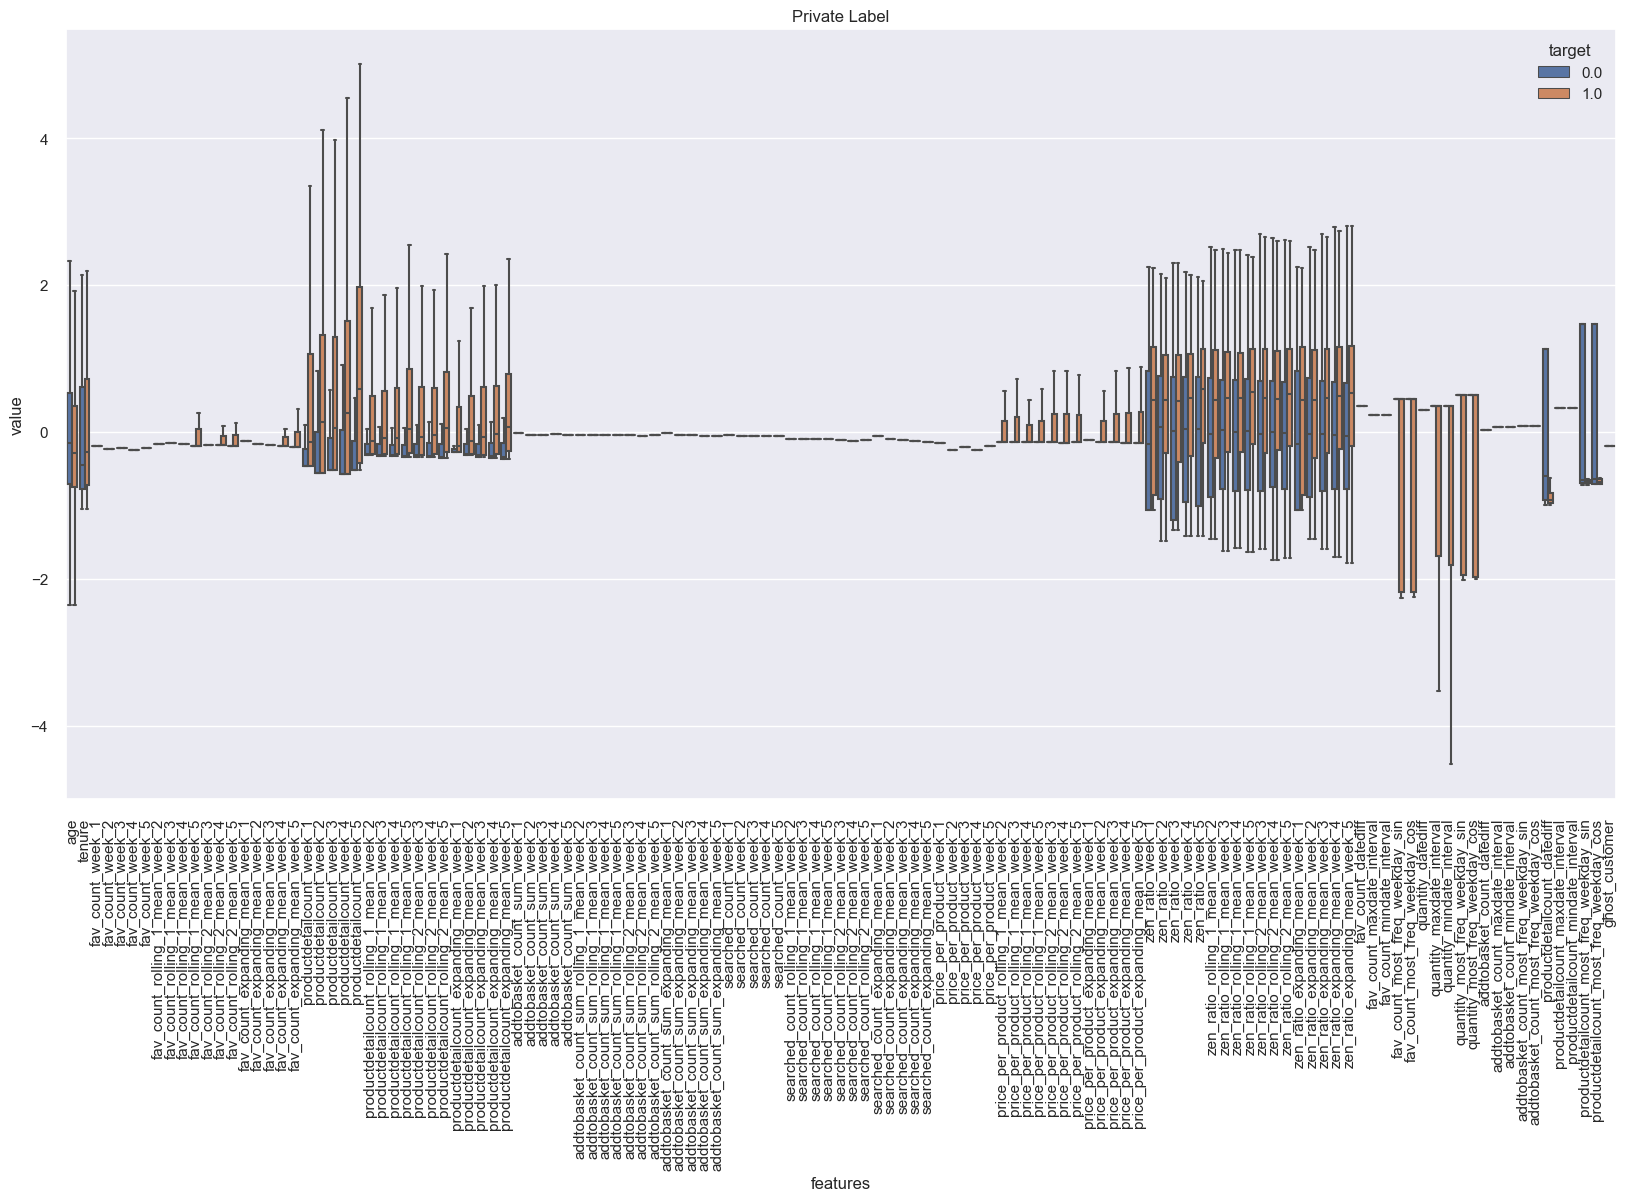

In [86]:
# Let's see each features' contribution to purchase behavior among different BU group.
# All features are scaled for readilibty purposes.
for domain in df_train_melt.currentbugroupname.unique():
    draw_feature_selection_plot(df_final.set_index(["userid", "currentbugroupname"]).xs(domain, level=1).drop(columns=["gender", "target"]), df_final.set_index(["userid", "currentbugroupname"])["target"].xs(domain, level=1), bugroupname=domain)

In [87]:
### Highlighting Notes on some of the features:

# Some of the features such as fav_count_week_n seem useless as predictor. Those will be dropped from the dataset in the later steps.
# Some features are promising, especially for specific BUs (e.g., Branded Tekstil and zen ratio features)
# porductdetailcount columns along with productdetailcount_datediff variable should contribute to purchase behavior patter for Private Label 

### Rest of the features
# Upon examining each BUs seperately I have decided to drop some of the features.

In [88]:
X = df_final.assign(target_group=df_final["currentbugroupname"]).set_index(["userid", "target_group"]).drop(columns=["target"]).dropna(axis=1, how="all")
y = df_final.assign(target_group=df_final["currentbugroupname"]).set_index(["userid", "target_group"])["target"]

In [89]:
X.drop(columns=X.filter(regex="(^addtobasket|expanding_mean_week_\d+$|rolling_2_mean_week_\d+$|fav_count.+_\d+$)").columns, inplace=True)

In [90]:
X.head()

currentbugroupname  gender   age   
userid target_group                                                       
2086   Aksesuar & Saat & Gözlük  Aksesuar & Saat & Gözlük     1.0  44.0  \
12810  Aksesuar & Saat & Gözlük  Aksesuar & Saat & Gözlük     1.0  37.0   
14302  Aksesuar & Saat & Gözlük  Aksesuar & Saat & Gözlük     0.0  34.0   
15148  Aksesuar & Saat & Gözlük  Aksesuar & Saat & Gözlük     1.0  39.0   
32508  Aksesuar & Saat & Gözlük  Aksesuar & Saat & Gözlük     1.0  35.0   

                                 tenure  productdetailcount_week_1   
userid target_group                                                  
2086   Aksesuar & Saat & Gözlük   129.0                        0.0  \
12810  Aksesuar & Saat & Gözlük   128.0                        0.0   
14302  Aksesuar & Saat & Gözlük   127.0                        0.0   
15148  Aksesuar & Saat & Gözlük   127.0                        0.0   
32508  Aksesuar & Saat & Gözlük   127.0                        0.0   

                                 productdetailcount_week_2   
userid target_group                                          
2086   Aksesuar & Saat & Gözlük                   0.000000  \
12810  Aksesuar & Saat & Gözlük                   0.001686   
14302  Aksesuar & Saat & Gözlük                   0.000000   
15148  Aksesuar & Saat & Gözlük                   0.011321   
32508  Aksesuar & Saat & Gözlük                   0.000000   

                                 productdetailcount_week_3   
userid target_group                                          
2086   Aksesuar & Saat & Gözlük                   0.000000  \
12810  Aksesuar & Saat & Gözlük                   0.007143   
14302  Aksesuar & Saat & Gözlük                   0.000000   
15148  Aksesuar & Saat & Gözlük                   0.006849   
32508  Aksesuar & Saat & Gözlük                   0.017857   

                                 productdetailcount_week_4   
userid target_group                                          
2086   Aksesuar & Saat & Gözlük                   0.000000  \
12810  Aksesuar & Saat & Gözlük                   0.003155   
14302  Aksesuar & Saat & Gözlük                   0.000000   
15148  Aksesuar & Saat & Gözlük                   0.000000   
32508  Aksesuar & Saat & Gözlük                   0.061538   

                                 productdetailcount_week_5   
userid target_group                                          
2086   Aksesuar & Saat & Gözlük                       0.00  \
12810  Aksesuar & Saat & Gözlük                       0.00   
14302  Aksesuar & Saat & Gözlük                       0.00   
15148  Aksesuar & Saat & Gözlük                       0.00   
32508  Aksesuar & Saat & Gözlük                       0.05   

                                 productdetailcount_rolling_1_mean_week_2   
userid target_group                                                         
2086   Aksesuar & Saat & Gözlük                                       0.0  \
12810  Aksesuar & Saat & Gözlük                                       0.5   
14302  Aksesuar & Saat & Gözlük                                       0.0   
15148  Aksesuar & Saat & Gözlük                                       1.5   
32508  Aksesuar & Saat & Gözlük                                       0.0   

                                 productdetailcount_rolling_1_mean_week_3   
userid target_group                                                         
2086   Aksesuar & Saat & Gözlük                                       0.0  \
12810  Aksesuar & Saat & Gözlük                                       1.5   
14302  Aksesuar & Saat & Gözlük                                       0.0   
15148  Aksesuar & Saat & Gözlük                                       2.0   
32508  Aksesuar & Saat & Gözlük                                       0.5   

                                 productdetailcount_rolling_1_mean_week_4   
userid target_group                                                         
2086   Aksesuar & Saat & Gözlük                 

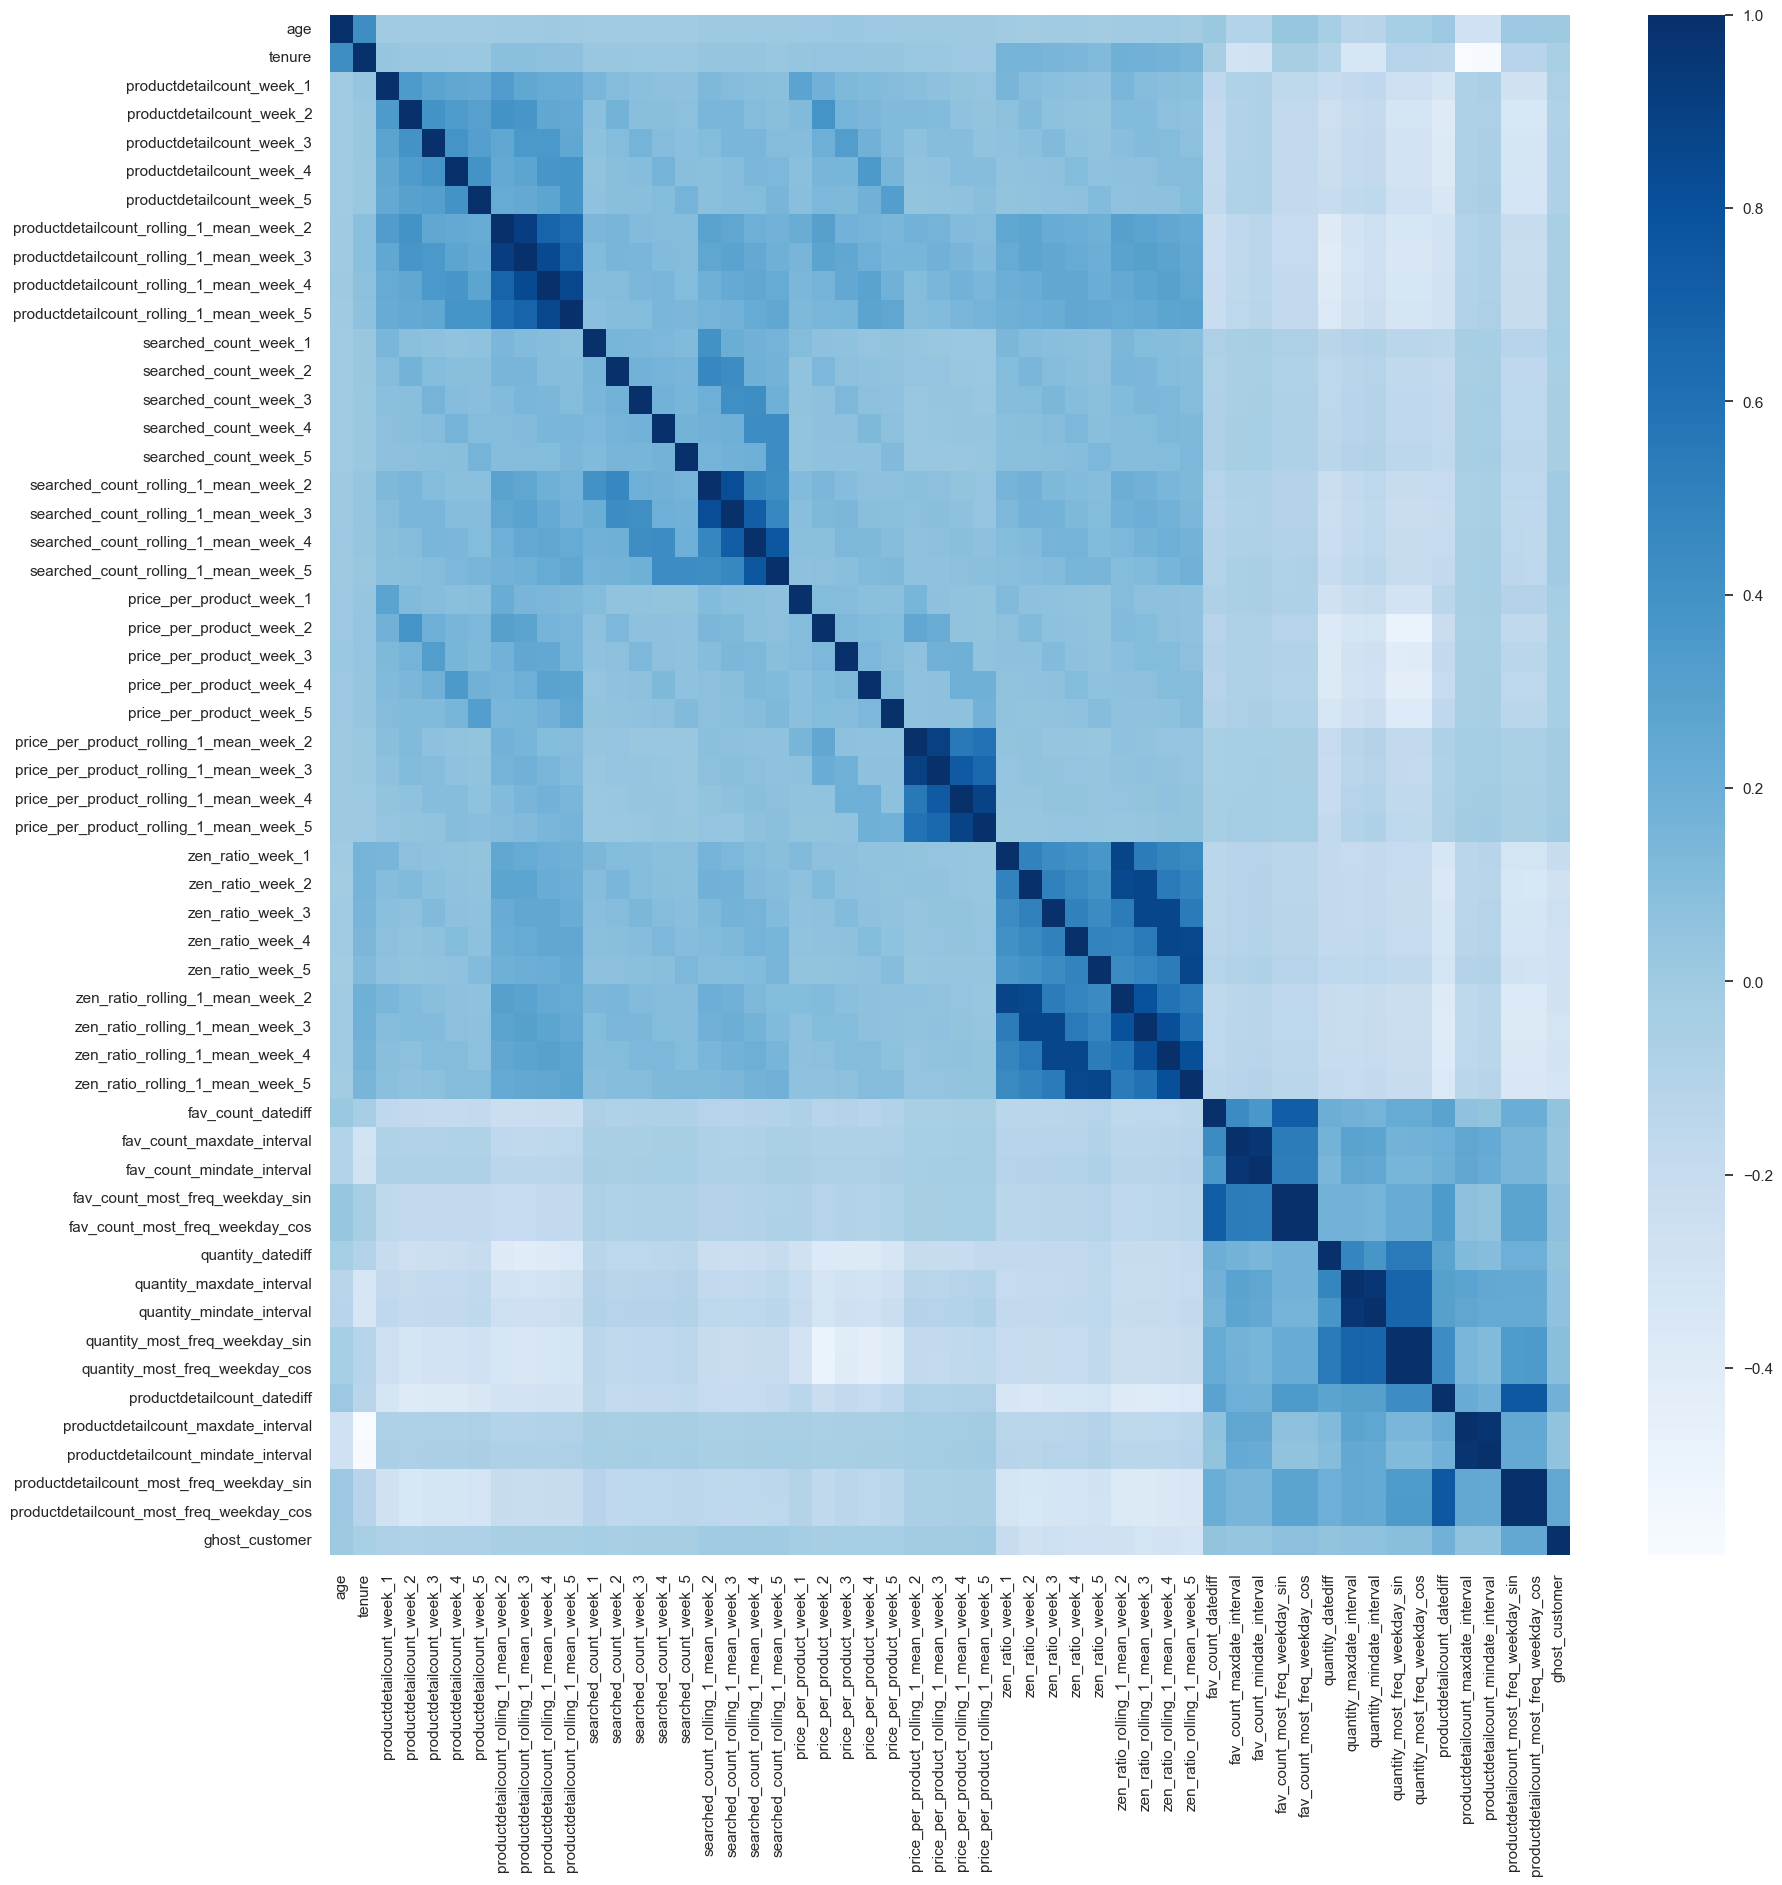

In [91]:
# Now I can check the correlation matrix.
df_corr = X.drop(columns=["currentbugroupname", "gender"]).corr()
plt.figure(figsize=(20, 20))
sns.heatmap(df_corr, cmap="Blues", annot=False);

In [92]:
X.head()

currentbugroupname  gender   age   
userid target_group                                                       
2086   Aksesuar & Saat & Gözlük  Aksesuar & Saat & Gözlük     1.0  44.0  \
12810  Aksesuar & Saat & Gözlük  Aksesuar & Saat & Gözlük     1.0  37.0   
14302  Aksesuar & Saat & Gözlük  Aksesuar & Saat & Gözlük     0.0  34.0   
15148  Aksesuar & Saat & Gözlük  Aksesuar & Saat & Gözlük     1.0  39.0   
32508  Aksesuar & Saat & Gözlük  Aksesuar & Saat & Gözlük     1.0  35.0   

                                 tenure  productdetailcount_week_1   
userid target_group                                                  
2086   Aksesuar & Saat & Gözlük   129.0                        0.0  \
12810  Aksesuar & Saat & Gözlük   128.0                        0.0   
14302  Aksesuar & Saat & Gözlük   127.0                        0.0   
15148  Aksesuar & Saat & Gözlük   127.0                        0.0   
32508  Aksesuar & Saat & Gözlük   127.0                        0.0   

                                 productdetailcount_week_2   
userid target_group                                          
2086   Aksesuar & Saat & Gözlük                   0.000000  \
12810  Aksesuar & Saat & Gözlük                   0.001686   
14302  Aksesuar & Saat & Gözlük                   0.000000   
15148  Aksesuar & Saat & Gözlük                   0.011321   
32508  Aksesuar & Saat & Gözlük                   0.000000   

                                 productdetailcount_week_3   
userid target_group                                          
2086   Aksesuar & Saat & Gözlük                   0.000000  \
12810  Aksesuar & Saat & Gözlük                   0.007143   
14302  Aksesuar & Saat & Gözlük                   0.000000   
15148  Aksesuar & Saat & Gözlük                   0.006849   
32508  Aksesuar & Saat & Gözlük                   0.017857   

                                 productdetailcount_week_4   
userid target_group                                          
2086   Aksesuar & Saat & Gözlük                   0.000000  \
12810  Aksesuar & Saat & Gözlük                   0.003155   
14302  Aksesuar & Saat & Gözlük                   0.000000   
15148  Aksesuar & Saat & Gözlük                   0.000000   
32508  Aksesuar & Saat & Gözlük                   0.061538   

                                 productdetailcount_week_5   
userid target_group                                          
2086   Aksesuar & Saat & Gözlük                       0.00  \
12810  Aksesuar & Saat & Gözlük                       0.00   
14302  Aksesuar & Saat & Gözlük                       0.00   
15148  Aksesuar & Saat & Gözlük                       0.00   
32508  Aksesuar & Saat & Gözlük                       0.05   

                                 productdetailcount_rolling_1_mean_week_2   
userid target_group                                                         
2086   Aksesuar & Saat & Gözlük                                       0.0  \
12810  Aksesuar & Saat & Gözlük                                       0.5   
14302  Aksesuar & Saat & Gözlük                                       0.0   
15148  Aksesuar & Saat & Gözlük                                       1.5   
32508  Aksesuar & Saat & Gözlük                                       0.0   

                                 productdetailcount_rolling_1_mean_week_3   
userid target_group                                                         
2086   Aksesuar & Saat & Gözlük                                       0.0  \
12810  Aksesuar & Saat & Gözlük                                       1.5   
14302  Aksesuar & Saat & Gözlük                                       0.0   
15148  Aksesuar & Saat & Gözlük                                       2.0   
32508  Aksesuar & Saat & Gözlük                                       0.5   

                                 productdetailcount_rolling_1_mean_week_4   
userid target_group                                                         
2086   Aksesuar & Saat & Gözlük                 

In [93]:
X.isna().sum()[X.isna().sum() > 0] / X.shape[0]

searched_count_rolling_1_mean_week_2    0.346535
searched_count_rolling_1_mean_week_3    0.346535
searched_count_rolling_1_mean_week_4    0.346535
searched_count_rolling_1_mean_week_5    0.346535
dtype: float64

In [94]:
# X["age"] = pd.qcut(X["age"], 4, labels=[0, 1, 2, 4]).astype(float)
# X["tenure"] = pd.qcut(X["tenure"], 4, labels=[0, 1, 2, 4]).astype(float)

In [95]:
X.gender.value_counts()

gender
1.000000    187296
0.000000     56832
0.666667       384
0.333333       312
Name: count, dtype: int64

In [96]:
y.value_counts(normalize=True)

target
0.0    0.898972
1.0    0.101028
Name: proportion, dtype: float64

In [97]:
# list of features with lower feature importance that was obtained previous modelling session
low_feature_importance_list = [
       'price_per_product_rolling_1_mean_week_4',
       'searched_count_rolling_1_mean_week_5', 'searched_count_week_2',
       'quantity_mindate_interval', 'price_per_product_week_5',
       'searched_count_week_5', 'fav_count_most_freq_weekday_sin','price_per_product_week_1',
       'searched_count_rolling_1_mean_week_4', 'fav_count_mindate_interval',
       'price_per_product_week_2', 'searched_count_rolling_1_mean_week_3',
       'gender', 'price_per_product_week_4',
       'productdetailcount_most_freq_weekday_cos',
       'productdetailcount_mindate_interval',
       'searched_count_rolling_1_mean_week_2',
       'quantity_most_freq_weekday_cos', 'quantity_maxdate_interval',
       'searched_count_week_1', 'fav_count_maxdate_interval',
       'searched_count_week_3', 'searched_count_week_4',
       'productdetailcount_maxdate_interval',
       'fav_count_most_freq_weekday_cos',
       'price_per_product_week_3'
       ]

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=low_feature_importance_list), y, test_size=0.25, random_state=54, stratify=y)

In [99]:
# Since we are including BU category in df_final we must provide a encoding solution. WOE is essentially a target based encoding technique which takes target value into account.
woe_encoder = ce.WOEEncoder(cols=["currentbugroupname"])
X_train_encoded = woe_encoder.fit_transform(X_train, y_train)
X_test_encoded = woe_encoder.transform(X_test)

In [100]:
X_train_encoded.head()

currentbugroupname        age  tenure   
userid   target_group                                           
13963306 Private Label           -0.032992  38.666667    38.0  \
33980744 Private Label           -0.032992  31.333333     5.0   
8385622  FMCG                     0.823360  41.000000    99.0   
6725992  Ev                       0.293426  40.000000   104.0   
999264   Mobilya                 -1.360995  35.000000   124.0   

                        productdetailcount_week_1  productdetailcount_week_2   
userid   target_group                                                          
13963306 Private Label                   0.000000                   0.000000  \
33980744 Private Label                   0.000000                   0.000000   
8385622  FMCG                            0.000000                   0.000000   
6725992  Ev                              0.575758                   0.037879   
999264   Mobilya                         0.090909                   0.019608   

                        productdetailcount_week_3  productdetailcount_week_4   
userid   target_group                                                          
13963306 Private Label                   0.000000                   0.000000  \
33980744 Private Label                   0.000000                   0.000000   
8385622  FMCG                            0.000000                   0.000000   
6725992  Ev                              0.086331                   0.189189   
999264   Mobilya                         0.259259                   0.000000   

                        productdetailcount_week_5   
userid   target_group                               
13963306 Private Label                        0.0  \
33980744 Private Label                        0.0   
8385622  FMCG                                 0.0   
6725992  Ev                                   0.0   
999264   Mobilya                              0.0   

                        productdetailcount_rolling_1_mean_week_2   
userid   target_group                                              
13963306 Private Label                                       0.0  \
33980744 Private Label                                       0.0   
8385622  FMCG                                                0.0   
6725992  Ev                                                 12.0   
999264   Mobilya                                             1.5   

                        productdetailcount_rolling_1_mean_week_3   
userid   target_group                                              
13963306 Private Label                                       0.0  \
33980744 Private Label                                       0.0   
8385622  FMCG                                                0.0   
6725992  Ev                                                  8.5   
999264   Mobilya                                             4.5   

                        productdetailcount_rolling_1_mean_week_4   
userid   target_group                                              
13963306 Private Label                                       0.0  \
33980744 Private Label                                       0.0   
8385622  FMCG                                                0.0   
6725992  Ev                                                 13.0   
999264   Mobilya                                             3.5   

                        productdetailcount_rolling_1_mean_week_5   
userid   target_group                                              
13963306 Private Label                                       0.0  \
33980744 Private Label                                       0.0   
8385622  FMCG                                                0.0   
6725992  Ev                                                  7.0   
999264   Mobilya                                             0.0   

                        price_per_product_rolling_1_mean_week_2   
userid   target_group                                             
13963306 Private Label          

In [101]:
# X_train_encoded.drop(columns=["currentbugroupname"], inplace=True)
# X_test_encoded.drop(columns=["currentbugroupname"], inplace=True)

In [102]:
X_train_encoded.isna().sum()[X_train_encoded.isna().sum() > 0] / X_train_encoded.shape[0]

Series([], dtype: float64)

In [103]:
y_train.value_counts().loc[0] / y_train.value_counts().loc[1]

8.898544474393532

In [104]:
X_train.shape

(183618, 30)

In [105]:
eval_set = [(X_train_encoded, y_train), (X_test_encoded, y_test)]
eval_metric = ["auc", "logloss"]

In [106]:
# Scale dataset for Logistic Regression model and drop NA values in order to avoid algorithm errors.
X_train_scaled = X_train_encoded.copy().fillna({"age": X_train_encoded.age.median()})
X_test_scaled = X_test_encoded.copy().fillna({"age": X_train_encoded.age.median()})
drop_cols = (X_train_scaled.isna().sum()[X_train_scaled.isna().sum() > 0] / X_train_scaled.shape[0]).index

X_train_scaled.drop(columns=drop_cols, inplace=True)
X_test_scaled.drop(columns=drop_cols, inplace=True)

scaler = StandardScaler()
X_train_scaled.iloc[:, :] = scaler.fit_transform(X_train_scaled)
X_test_scaled.iloc[:, :] = scaler.transform(X_test_scaled)

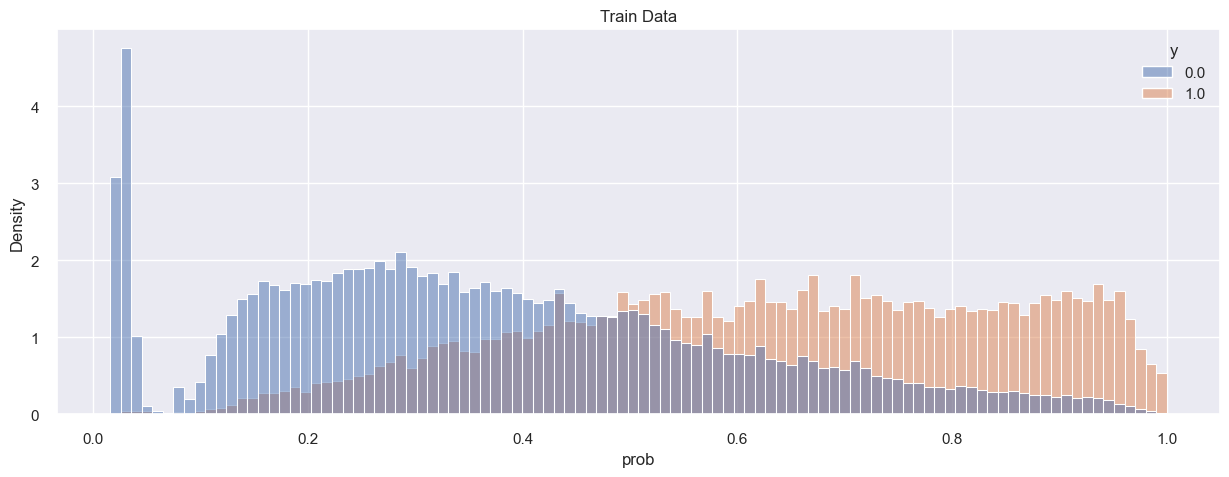

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92    165068
         1.0       0.33      0.43      0.37     18550

    accuracy                           0.86    183618
   macro avg       0.63      0.67      0.65    183618
weighted avg       0.87      0.86      0.86    183618



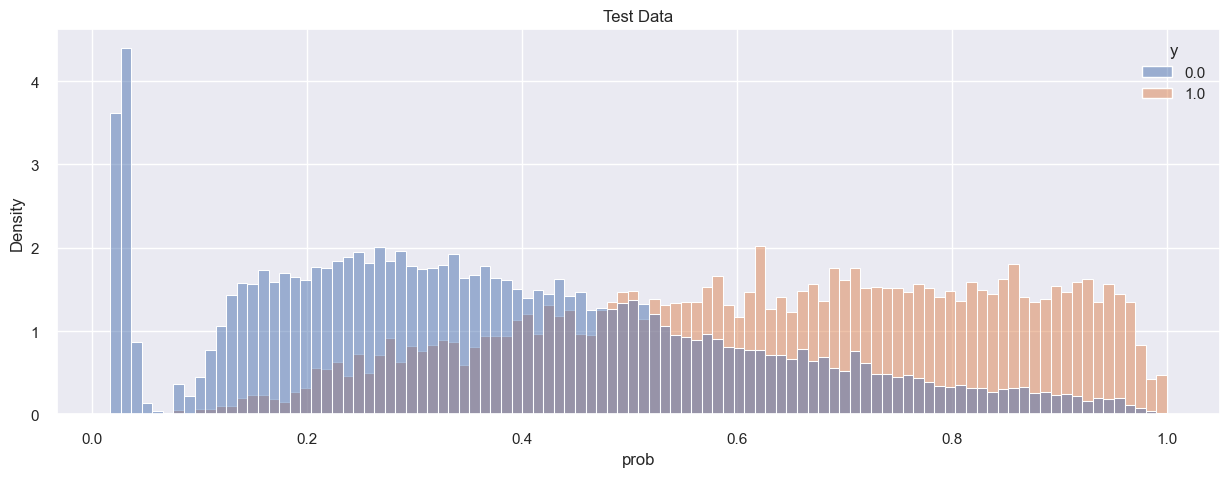

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92     55022
         1.0       0.34      0.44      0.38      6184

    accuracy                           0.86     61206
   macro avg       0.64      0.67      0.65     61206
weighted avg       0.87      0.86      0.86     61206

Train AUC:  0.7968117066775127
Test AUC:  0.7987542443330795


In [107]:
# Benchmark Model
threshold = 0.69

model = LogisticRegression(class_weight="balanced")
model.fit(X_train_scaled, y_train)

result = pd.DataFrame(np.stack((y_train, model.predict_proba(X_train_scaled)[:, 1])).T, columns=["y", "prob"])
plt.figure(figsize=(15, 5))
sns.histplot(x="prob", hue="y", data=result, bins=100, common_norm=False, alpha=0.5, stat="density")
plt.title("Train Data")
plt.show()

y_pred = model.predict_proba(X_train_scaled)[:, 1]
y_pred = np.where(y_pred > threshold, 1, 0)
print(classification_report(y_train, y_pred))

result = pd.DataFrame(np.stack((y_test, model.predict_proba(X_test_scaled)[:, 1])).T, columns=["y", "prob"])
plt.figure(figsize=(15, 5))
sns.histplot(x="prob", hue="y", data=result, bins=100, common_norm=False, alpha=0.5, stat="density")
plt.title("Test Data")
plt.show()

y_pred = model.predict_proba(X_test_scaled)[:, 1]
y_pred = np.where(y_pred > threshold, 1, 0)
print(classification_report(y_test, y_pred))


threshold = 0.65
y_pred = model.predict_proba(X_train_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred, drop_intermediate=True)
y_train_auc = auc(fpr, tpr)
print("Train AUC: ", y_train_auc)

y_pred = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=True)
y_test_auc = auc(fpr, tpr)
print("Test AUC: ", y_test_auc)

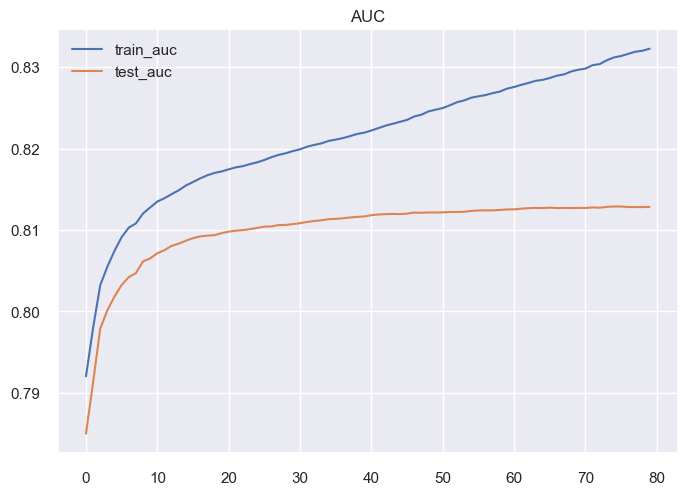

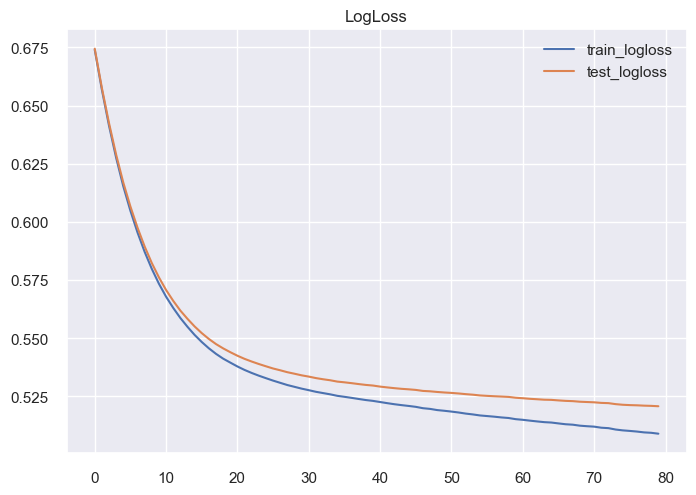

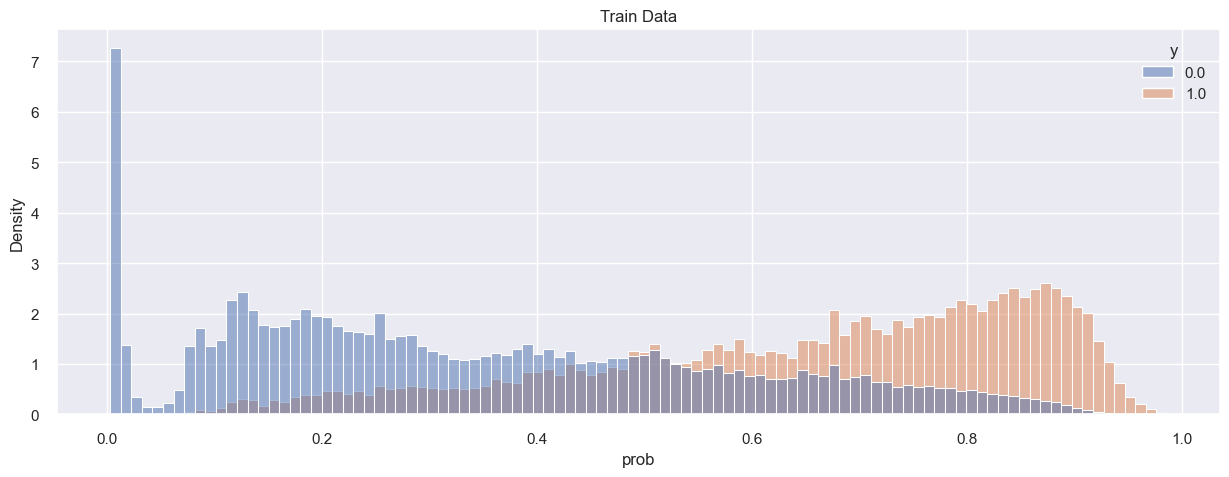

              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92    165068
         1.0       0.37      0.52      0.43     18550

    accuracy                           0.86    183618
   macro avg       0.65      0.71      0.67    183618
weighted avg       0.88      0.86      0.87    183618



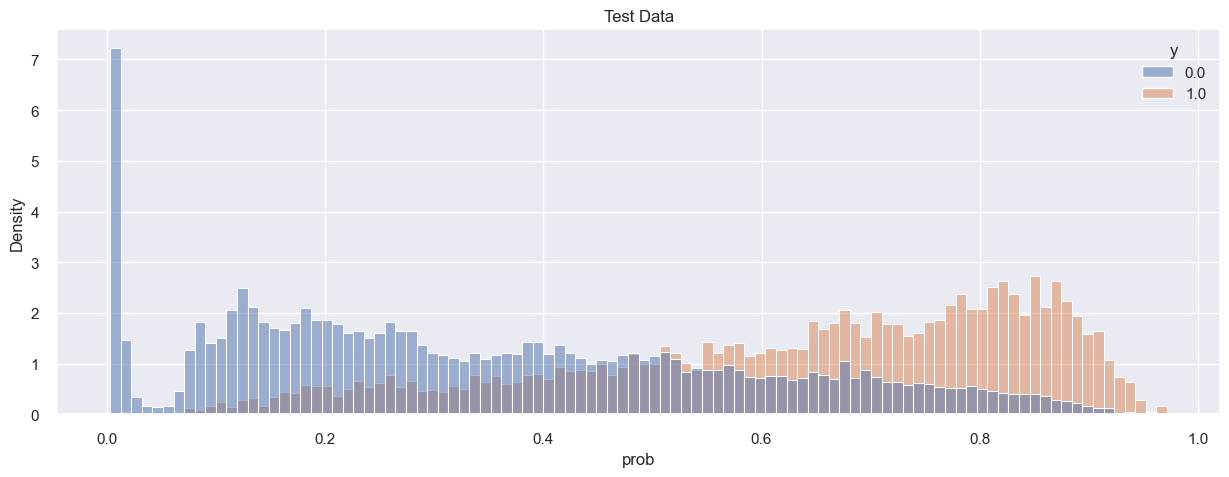

              precision    recall  f1-score   support

         0.0       0.94      0.89      0.92     55022
         1.0       0.34      0.48      0.40      6184

    accuracy                           0.85     61206
   macro avg       0.64      0.69      0.66     61206
weighted avg       0.88      0.85      0.86     61206

Train AUC:  0.8322610281594641
Test AUC:  0.8128345407103535


In [108]:
threshold = 0.69
model = XGBClassifier(n_estimators=80, max_delta_step=1, scale_pos_weight=y_train.value_counts().loc[0] / y_train.value_counts().loc[1], learning_rate=0.1, early_stopping_rounds=False, eval_metric=eval_metric)
model.fit(X_train_encoded, y_train, eval_set=eval_set, verbose=False)

tr = pd.DataFrame(model.evals_result_["validation_0"]).add_prefix("train_")
ts = pd.DataFrame(model.evals_result_["validation_1"]).add_prefix("test_")
eval_result = pd.concat([tr, ts], axis=1)
eval_result.filter(regex="auc").plot(title="AUC")
eval_result.filter(regex="logloss").plot(title="LogLoss")
plt.show()

result = pd.DataFrame(np.stack((y_train, model.predict_proba(X_train_encoded)[:, 1])).T, columns=["y", "prob"])
plt.figure(figsize=(15, 5))
sns.histplot(x="prob", hue="y", data=result, bins=100, common_norm=False, alpha=0.5, stat="density")
plt.title("Train Data")
plt.show()

y_pred = model.predict_proba(X_train_encoded)[:, 1]
y_pred = np.where(y_pred > threshold, 1, 0)
print(classification_report(y_train, y_pred))

result = pd.DataFrame(np.stack((y_test, model.predict_proba(X_test_encoded)[:, 1])).T, columns=["y", "prob"])
plt.figure(figsize=(15, 5))
sns.histplot(x="prob", hue="y", data=result, bins=100, common_norm=False, alpha=0.5, stat="density")
plt.title("Test Data")
plt.show()

y_pred = model.predict_proba(X_test_encoded)[:, 1]
y_pred = np.where(y_pred > threshold, 1, 0)
print(classification_report(y_test, y_pred))

y_pred = model.predict_proba(X_train_encoded)[:, 1]
# y_pred = np.where(y_pred >= threshold, 1, 0)
fpr, tpr, thresholds = roc_curve(y_train, y_pred, drop_intermediate=True)
y_train_auc = auc(fpr, tpr)
print("Train AUC: ", y_train_auc)

y_pred = model.predict_proba(X_test_encoded)[:, 1]
# y_pred = np.where(y_pred >= threshold, 1, 0)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=True)
y_test_auc = auc(fpr, tpr)
print("Test AUC: ", y_test_auc)

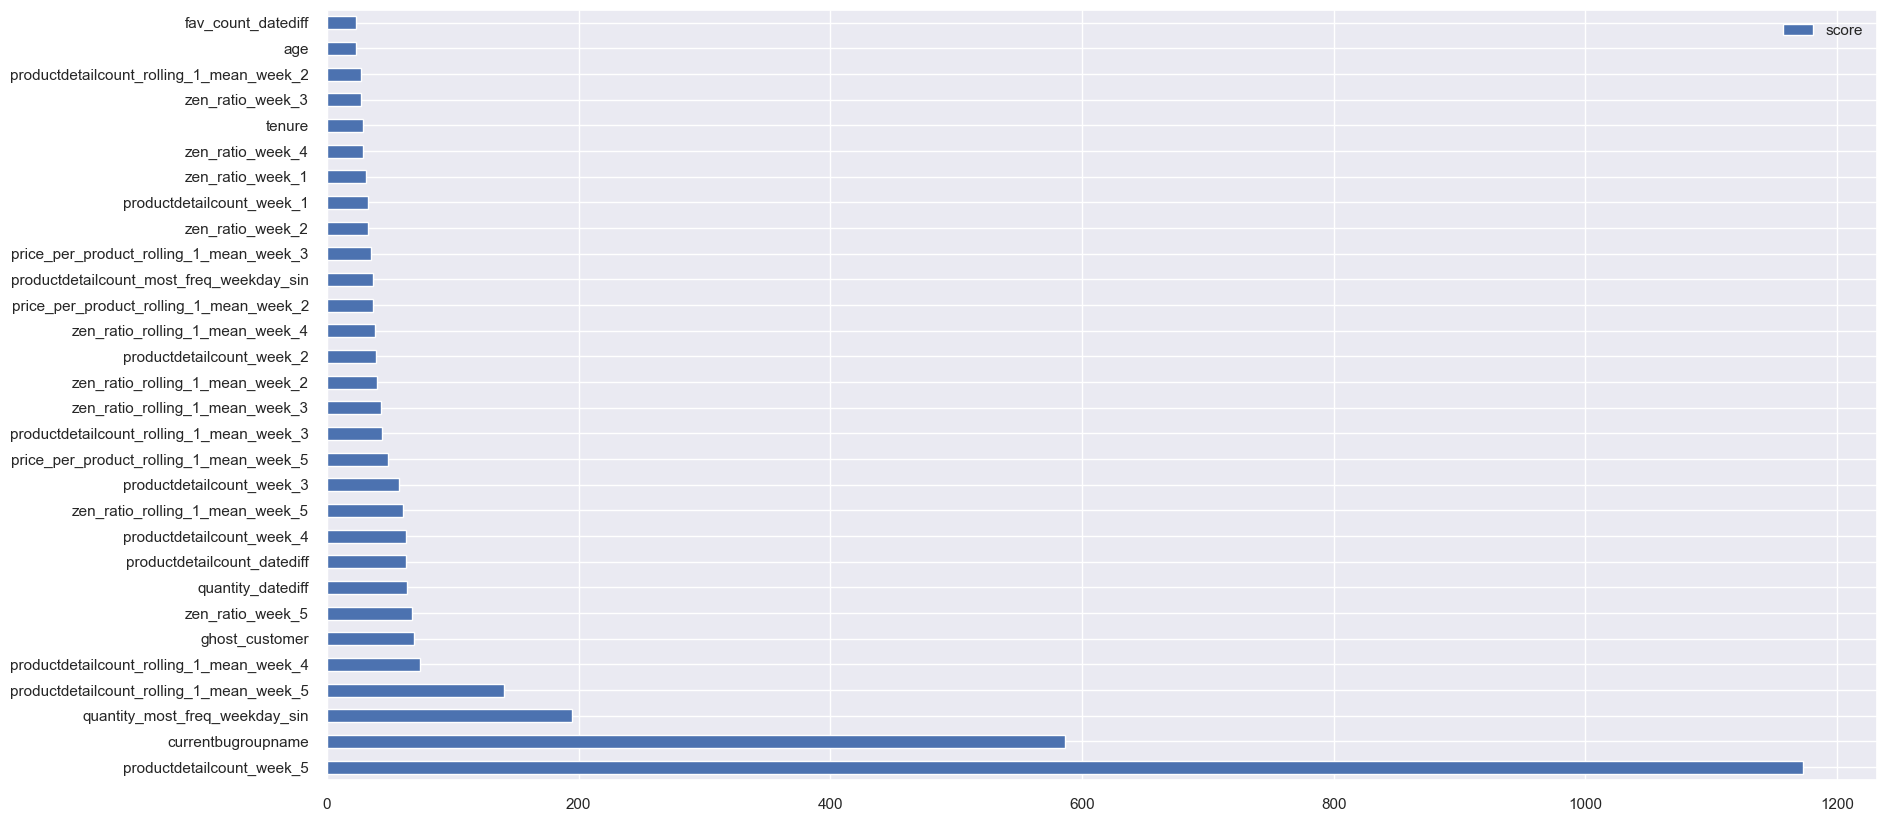

In [121]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(70, columns="score").plot(kind='barh', figsize = (20,10));

In [109]:
def param_tuning(params_dict, threshold = threshold):
    grid = ParameterGrid(params_dict)
    results = []
    for params in tqdm(grid):
        m = XGBClassifier(**params)
        m.fit(X_train_encoded, y_train, verbose=False)

        y_train_pred_proba = m.predict_proba(X_train_encoded)[:, 1]
        y_train_pred = np.where(y_train_pred_proba >= threshold, 1, 0)
        fpr, tpr, _ = roc_curve(y_train, y_train_pred_proba)
        y_train_auc = auc(fpr, tpr)
    
        y_test_pred_proba = m.predict_proba(X_test_encoded)[:, 1]
        y_test_pred = np.where(y_test_pred_proba >= threshold, 1, 0)
        fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
        y_test_auc = auc(fpr, tpr)

        train_metrics = classification_report(y_train, y_train_pred, output_dict=True)["1.0"]
        train_metrics.update({"auc": y_train_auc})
        test_metrics = classification_report(y_test, y_test_pred, output_dict=True)["1.0"]
        test_metrics.update({"auc": y_test_auc})
        results.append([train_metrics, test_metrics, params])

    results_df = pd.DataFrame(results, columns=["train", "test", "params"])
    results_df = pd.concat([pd.json_normalize(results_df["train"]).add_prefix("train_"), pd.json_normalize(results_df["test"]).add_prefix("test_"), pd.json_normalize(results_df["params"])], axis=1)
    return results_df

In [ ]:
params = {
    "learning_rate": [0.05, 0.1],
    "max_depth": [8, None],
    "scale_pos_weight": [y_train.value_counts().loc[0] / y_train.value_counts().loc[1]],
    "n_estimators": [65, 100],
    "max_delta_step": [0.5, None]

}
result = param_tuning(params)

100%|██████████| 16/16 [01:43<00:00,  6.44s/it]


In [ ]:
# Hyper parameter tuning results
result.sort_values("test_auc", ascending=False).reset_index(drop=True)

train_precision  train_recall  train_f1-score  train_support  train_auc   
0          0.319234      0.594016        0.415286          18550   0.829772  \
1          0.330075      0.584367        0.421864          18550   0.832624   
2          0.324585      0.578005        0.415718          18550   0.828404   
3          0.315337      0.589111        0.410788          18550   0.825031   
4          0.313295      0.581294        0.407151          18550   0.822835   
5          0.322865      0.559730        0.409513          18550   0.822587   
6          0.343265      0.593747        0.435026          18550   0.842052   
7          0.353097      0.610296        0.447364          18550   0.848250   
8          0.350956      0.604420        0.444066          18550   0.845110   
9          0.362889      0.618868        0.457507          18550   0.855266   
10         0.370251      0.590566        0.455150          18550   0.848927   
11         0.319177      0.561132        0.406904          18550   0.819447   
12         0.379741      0.608302        0.467585          18550   0.858788   
13         0.348550      0.592722        0.438966          18550   0.839410   
14         0.390818      0.618167        0.478879          18550   0.865010   
15         0.427890      0.638491        0.512395          18550   0.883402   

    test_precision  test_recall  test_f1-score  test_support  test_auc   
0         0.302322     0.570666       0.395251          6184  0.812545  \
1         0.309421     0.558700       0.398271          6184  0.812394   
2         0.309245     0.559832       0.398412          6184  0.812288   
3         0.301879     0.574224       0.395721          6184  0.812005   
4         0.302405     0.571313       0.395478          6184  0.811666   
5         0.311239     0.548997       0.397262          6184  0.811446   
6         0.309487     0.544955       0.394775          6184  0.811366   
7         0.311068     0.546734       0.396528          6184  0.810807   
8         0.309405     0.543661       0.394370          6184  0.810704   
9         0.312343     0.543823       0.396791          6184  0.810660   
10        0.318354     0.516656       0.393958          6184  0.809684   
11        0.307337     0.548674       0.393985          6184  0.809648   
12        0.318394     0.519243       0.394738          6184  0.809571   
13        0.311857     0.539295       0.395189          6184  0.809456   
14        0.319572     0.511966       0.393512          6184  0.807959   
15        0.322926     0.488357       0.388774          6184  0.805455   

    learning_rate  max_delta_step  max_depth  n_estimators  scale_pos_weight  
0            0.10             0.5        NaN           100          8.898544  
1            0.10             NaN        NaN            65          8.898544  
2            0.05             NaN        NaN           100          8.898544  
3            0.10             0.5        NaN            65          8.898544  
4            0.05             0.5        NaN           100          8.898544  
5            0.05             NaN        NaN            65          8.898544  
6            0.10             NaN        NaN           100          8.898544  
7            0.10             0.5        8.0            65          8.898544  
8            0.05             0.5        8.0           100          8.898544  
9            0.10             0.5        8.0           100          8.898544  
10           0.05             NaN        8.0            65          8.898544  
11           0.05             0.5        NaN            65          8.898544  
12           0.05             NaN        8.0           100          8.898544  
13           0.05             0.5        8.0            65          8.898544  
14           0.10             NaN        8.0            65          8.898544  
15           0.10             NaN        8.0           100          8.898544

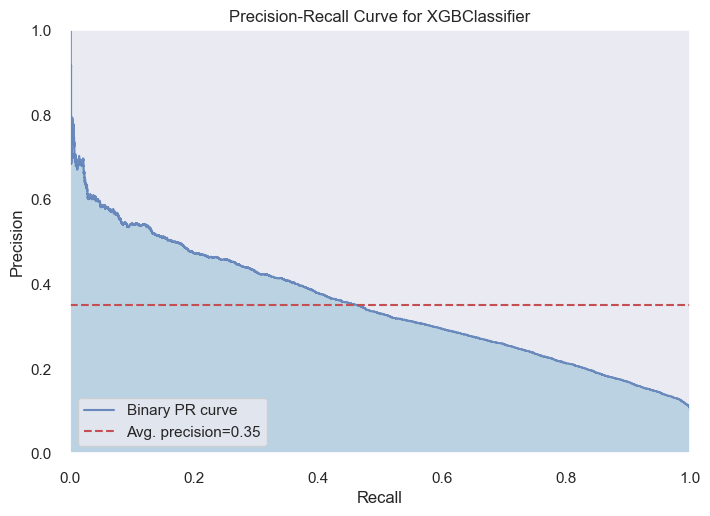

In [ ]:
# Precision Recall Analysis
viz = PrecisionRecallCurve(model)
viz.fit(X_train_encoded, y_train)
viz.score(X_test_encoded, y_test)
viz.show();

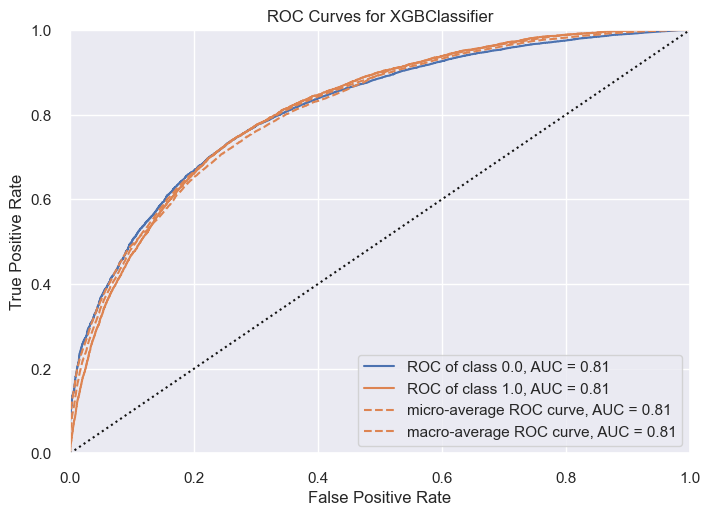

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
# ROC Curve
visualizer = ROCAUC(model)
visualizer.fit(X_train_encoded, y_train)
visualizer.score(X_test_encoded, y_test)
visualizer.show()

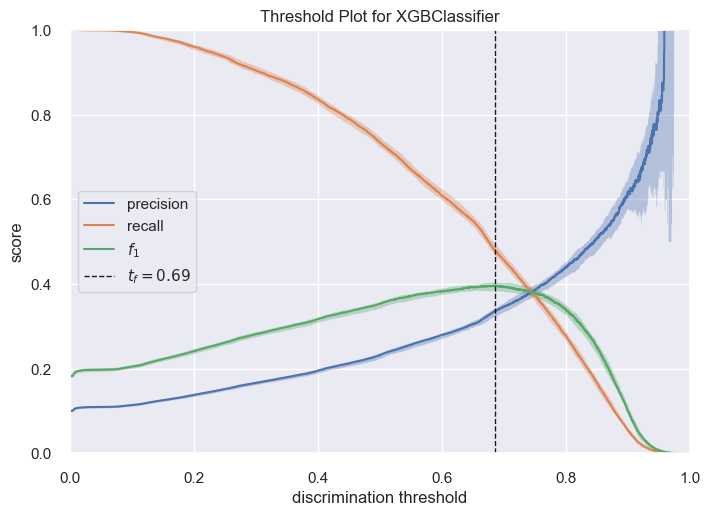

In [ ]:
# Proba Threshold Analysis
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    discrimination_threshold(model, X_train_encoded, y_train, exclude="queue_rate")

In [110]:
from sklearn.model_selection import StratifiedKFold
def custom_cv(X, y, model_params={}, split_number=4, threshold=threshold):
    cv = StratifiedKFold(n_splits=split_number, shuffle=True, random_state=54)
    results = []
    for train_indices, test_indices in cv.split(X, y):
        X_train_split, y_train_split = X.iloc[train_indices], y.iloc[train_indices]
        X_test_split, y_test_split = X.iloc[test_indices], y.iloc[test_indices]

        selected_model = XGBClassifier(**model_params)
        selected_model.fit(X_train_split, y_train_split, verbose=False)

        y_train_pred_proba = selected_model.predict_proba(X_train_split)[:, 1]
        y_train_pred = np.where(y_train_pred_proba >= threshold, 1, 0)
        fpr, tpr, _ = roc_curve(y_train_split, y_train_pred_proba)
        y_train_auc = auc(fpr, tpr)
    
        y_test_pred_proba = selected_model.predict_proba(X_test_split)[:, 1]
        y_test_pred = np.where(y_test_pred_proba >= threshold, 1, 0)
        fpr, tpr, _ = roc_curve(y_test_split, y_test_pred_proba)
        y_test_auc = auc(fpr, tpr)

        train_metrics = classification_report(y_train_split, y_train_pred, output_dict=True)["1.0"]
        train_metrics.update({"auc": y_train_auc})
        test_metrics = classification_report(y_test_split, y_test_pred, output_dict=True)["1.0"]
        test_metrics.update({"auc": y_test_auc})
        results.append([train_metrics, test_metrics, model_params])

    results_df = pd.DataFrame(results, columns=["train", "test", "params"])
    results_df = pd.concat([pd.json_normalize(results_df["train"]).add_prefix("train_"), pd.json_normalize(results_df["test"]).add_prefix("test_"), pd.json_normalize(results_df["params"])], axis=1)
    results_df.loc["mean", results_df.filter(regex="(train|test)").columns] = results_df.filter(regex="(train|test)").mean(axis=0)
    results_df.loc["std", results_df.filter(regex="(train|test)").columns] = results_df.filter(regex="(train|test)").std(axis=0)
    return results_df



In [111]:
X_combined = pd.concat([X_train_encoded, X_test_encoded], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)

custom_cv(X_combined, y_combined, split_number=4, threshold=.65, model_params=dict(n_estimators=80, max_delta_step=1, scale_pos_weight=y_train.value_counts().loc[0] / y_train.value_counts().loc[1], learning_rate=0.1))


train_precision  train_recall  train_f1-score  train_support  train_auc   
0            0.329464      0.581370        0.420583        18551.0   0.831318  \
1            0.330109      0.577651        0.420128        18551.0   0.831480   
2            0.325768      0.592722        0.420451        18550.0   0.832378   
3            0.326808      0.587655        0.420029        18550.0   0.831574   
mean         0.328037      0.584850        0.420298        18550.5   0.831687   
std          0.001802      0.005783        0.000227            0.5   0.000409   

      test_precision  test_recall  test_f1-score  test_support  test_auc   
0           0.313455     0.554262       0.400444        6183.0  0.813122  \
1           0.308405     0.543587       0.393537        6183.0  0.811144   
2           0.300569     0.546895       0.387933        6184.0  0.808298   
3           0.308500     0.551100       0.395566        6184.0  0.810188   
mean        0.307732     0.548961       0.394370        6183.5  0.810688   
std         0.004613     0.004056       0.004485           0.5  0.001739   

      n_estimators  max_delta_step  scale_pos_weight  learning_rate  
0             80.0             1.0          8.898544            0.1  
1             80.0             1.0          8.898544            0.1  
2             80.0             1.0          8.898544            0.1  
3             80.0             1.0          8.898544            0.1  
mean           NaN             NaN               NaN            NaN  
std            NaN             NaN               NaN            NaN

In [112]:
from sklearn.metrics import f1_score
def threshold_optimization(X_data, y_data):
    y_pred_proba = model.predict_proba(X_data)[:, 1]
    optimization_range = np.arange(0.1, 0.95, 0.05)
    results = []
    for thresh in optimization_range:
        y_pred = np.where(y_pred_proba > thresh, 1, 0)
        results.append([thresh, classification_report(y_data, y_pred, output_dict=True, zero_division=0)["1.0"]["f1-score"]])
    
    result_table = pd.DataFrame(results, columns=["threshold", "f1_score"]).set_index("threshold")
    return result_table.f1_score.idxmax()

bu = "Branded Tekstil"
threshold_optimization(X_test_encoded.xs(bu, level=1), y_test.xs(bu, level=1))

0.7500000000000002

In [113]:
threshold_dict = {}
for bu in unique_bu_names:
    bu_thresh = threshold_optimization(X_test_encoded.xs(bu, level=1), y_test.xs(bu, level=1))
    threshold_dict.update({bu: round(bu_thresh, 2)})

In [114]:
df_pred = y_test.copy().to_frame().reset_index()
df_pred["prediction_thresh"] = 0.68
df_pred["proba"] = model.predict_proba(X_test_encoded)[:, 1]
df_pred["pred"] = np.where(df_pred["proba"] >= df_pred["prediction_thresh"], 1, 0)
df_pred.head()

userid      target_group  target  prediction_thresh     proba  pred
0   7282366          Kozmetik     0.0               0.68  0.195320     0
1  13767097              FMCG     0.0               0.68  0.693185     1
2  34429598  Ayakkabı & Çanta     0.0               0.68  0.223035     0
3  33406492           Mobilya     0.0               0.68  0.080477     0
4  21443520                GM     0.0               0.68  0.475979     0

In [115]:
print(classification_report(df_pred["pred"], df_pred["target"]))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     51754
           1       0.50      0.33      0.40      9452

    accuracy                           0.85     61206
   macro avg       0.69      0.64      0.66     61206
weighted avg       0.83      0.85      0.83     61206



In [116]:
# Measuring model performance across different BU groups.
# Since the data is strongly imbalanced I've optimized f1-score.
# As can be seen below Branded Tekstil doing a relatively better job capturing targets
scores = pd.DataFrame()
for bu in df_train_melt.currentbugroupname.unique():
    y_pred = model.predict_proba(X_test_encoded.xs(bu, level=1))[:, 1]
    y_pred = np.where(y_pred > threshold_dict[bu], 1, 0)
    zero = pd.Series(classification_report(y_test.xs(bu, level=1), y_pred, output_dict=True)["0.0"], name=f"{bu}_0")
    one = pd.Series(classification_report(y_test.xs(bu, level=1), y_pred, output_dict=True)["1.0"], name=f"{bu}_1")
    score_table = pd.concat([zero, one],axis=1)
    score_table.columns = pd.MultiIndex.from_tuples(product([bu], ["0", "1"]))
    scores = pd.concat([scores, score_table], axis=1)

scores.T.loc[scores.T.xs("1", level=1).sort_values("f1-score", ascending=False).index]

precision    recall  f1-score  support
Digital Goods            0   0.999020  0.999608  0.999314   5101.0
                         1   0.666667  0.444444  0.533333      9.0
Branded Tekstil          0   0.856233  0.670428  0.752024   3811.0
                         1   0.409497  0.670000  0.508316   1300.0
FMCG                     0   0.874658  0.714463  0.786486   4024.0
                         1   0.370756  0.621671  0.464494   1089.0
GM                       0   0.883744  0.815985  0.848514   4304.0
                         1   0.329949  0.457746  0.383481    852.0
Ev                       0   0.917760  0.819554  0.865881   4439.0
                         1   0.301656  0.514881  0.380429    672.0
Private Label            0   0.946386  0.862565  0.902534   4584.0
                         1   0.292929  0.538144  0.379360    485.0
Ayakkabı & Çanta         0   0.943645  0.825790  0.880792   4684.0
                         1   0.210832  0.485523  0.293999    449.0
Elektronik               0   0.935813  0.901070  0.918113   4579.0
                         1   0.250000  0.347926  0.290944    434.0
GAS                      0   0.968063  0.972813  0.970432   4892.0
                         1   0.303665  0.269767  0.285714    215.0
Mobilya                  0   0.979802  0.979802  0.979802   4951.0
                         1   0.270073  0.270073  0.270073    137.0
Kozmetik                 0   0.950219  0.908576  0.928931   4769.0
                         1   0.212996  0.342029  0.262514    345.0
Aksesuar & Saat & Gözlük 0   0.970459  0.948403  0.959304   4884.0
                         1   0.181818  0.284264  0.221782    197.0

In [117]:
# Final results
df_test_set_processed = df_test_set.copy()
df_test_set_processed["target_group"] = df_test_set_processed["currentbugroupname"]
df_test_set_processed = df_test_set_processed.set_index(["userid", "target_group"])[X_train.columns.tolist()]
X_testset_encoded = woe_encoder.transform(df_test_set_processed)
X_testset_encoded.head()


currentbugroupname        age  tenure   
userid   target_group                                           
20152944 Private Label           -0.032992  25.000000    21.0  \
6662068  Private Label           -0.032992  36.333333   104.0   
11941706 Private Label           -0.032992  32.000000    55.0   
12406170 Private Label           -0.032992  26.666667    50.0   
20939786 Private Label           -0.032992  26.666667    19.0   

                        productdetailcount_week_1  productdetailcount_week_2   
userid   target_group                                                          
20152944 Private Label                   0.000000                   0.461538  \
6662068  Private Label                   0.000000                   0.000000   
11941706 Private Label                   0.363636                   0.780488   
12406170 Private Label                   0.000000                   0.000000   
20939786 Private Label                   0.000000                   0.000000   

                        productdetailcount_week_3  productdetailcount_week_4   
userid   target_group                                                          
20152944 Private Label                   1.000000                   0.750000  \
6662068  Private Label                   0.000000                   0.333333   
11941706 Private Label                   0.604651                   0.409091   
12406170 Private Label                   0.000000                   0.000000   
20939786 Private Label                   0.163265                   0.000000   

                        productdetailcount_week_5   
userid   target_group                               
20152944 Private Label                   1.000000  \
6662068  Private Label                   0.020576   
11941706 Private Label                   0.372807   
12406170 Private Label                   0.000000   
20939786 Private Label                   0.000000   

                        productdetailcount_rolling_1_mean_week_2   
userid   target_group                                              
20152944 Private Label                                       9.0  \
6662068  Private Label                                       0.0   
11941706 Private Label                                      18.0   
12406170 Private Label                                       0.0   
20939786 Private Label                                       0.0   

                        productdetailcount_rolling_1_mean_week_3   
userid   target_group                                              
20152944 Private Label                                      12.0  \
6662068  Private Label                                       0.0   
11941706 Private Label                                      29.0   
12406170 Private Label                                       0.0   
20939786 Private Label                                       4.0   

                        productdetailcount_rolling_1_mean_week_4   
userid   target_group                                              
20152944 Private Label                                       9.0  \
6662068  Private Label                                      19.5   
11941706 Private Label                                      17.5   
12406170 Private Label                                       0.0   
20939786 Private Label                                       4.0   

                        productdetailcount_rolling_1_mean_week_5   
userid   target_group                                              
20152944 Private Label                                      38.0  \
6662068  Private Label                                      22.0   
11941706 Private Label                                      47.0   
12406170 Private Label                                       0.0   
20939786 Private Label                                       0.0   

                        price_per_product_rolling_1_mean_week_2   
userid   target_group                                             
20152944 Private Label          

In [118]:
y_pred_prob = model.predict_proba(X_testset_encoded)[:, 1]
y_pred = np.where(y_pred_prob > threshold, 1, 0)

X_testset_encoded["probability"] = y_pred_prob
X_testset_encoded["target"] = y_pred


In [119]:
final_result = X_testset_encoded[["probability", "target"]].reset_index()
final_result

userid   target_group  probability  target
0       20152944  Private Label     0.940902       1
1        6662068  Private Label     0.449909       0
2       11941706  Private Label     0.837054       1
3       12406170  Private Label     0.127051       0
4       20939786  Private Label     0.325148       0
...          ...            ...          ...     ...
244831  24094896  Digital Goods     0.009298       0
244832   3625552  Digital Goods     0.005646       0
244833  17383254  Digital Goods     0.017767       0
244834  26909708  Digital Goods     0.005186       0
244835  28564690  Digital Goods     0.013966       0

[244836 rows x 4 columns]

In [122]:
final_result.target.value_counts()

target
0    209678
1     35158
Name: count, dtype: int64

In [ ]:
final_result.to_csv("df_test_output.csv", index=False)